# **Analyse exploratoire sur les radiations naturelles ([OpenRadiation](https://request.openradiation.net/download.html))**

Dans ce notebook, nous allons analyser un fichier de données contenant les radiations naturelles prises dans l'environnement. Ce fichier contient plus de 900 000 lignes de données et plus d'une dizaine de colonnes. Pour répartir notre notebook, nous allons d'abord importer et comprendre nos données. Ensuite, on fera une préparation puis une analyse exploratoire sur nos données. Pour terminer, on fera une carte interactivez (Folium) permettant de voir les différentes zones de radiations (les plus élevées) et on créera un modèle permettant de prédire le taux de radiation à partir d'un modèle de régression.
https://request.openradiation.net/openradiation_dataset.tar.gz

Utilisation de git lfs pour le stockage de grands fichiers :
https://git-lfs.com/

## **Importation des données**
Dans cette sous-partie, on va importer les données et comprendre la structure de celle-ci. On va utiliser les librairies *Pandas, Plotnine et Numpy*.  

In [59]:
# Chargement des librairies
import pandas as pd
import numpy as np
import requests
import tarfile 
import plotnine as plt
#import plotnine_prism as pr
import os

Les données transmises par l'Application OpenRadiation à la Base OpenRadiation correspondent aux données que vous saisissez, ainsi que des informations sur le modèle et l'identifiant du capteur utilisé, le modèle et l'identifiant du téléphone, votre nom d'utilisateur, ainsi que la position GPS au moment de la mesure. Ainsi, en passant par l'application OpenRadiation les données suivantes sont systématiquement transmises :

- apparatusId : identifiant du capteur utilisé pour la mesure
- apparatusVersion : modèle du capteur
- apparatusSensorType : geiger ou photodiode
- apparatusTubeType : type du tube lorsque le capteur est de type geiger
- temperature : température durant la mesure
- value : mesure en µSv/h
- hitsNumber : nombre de coups durant la mesure
- calibrationFunction : fonction de calibration utilisée pour estimée le débit de dose à partir du nombre de coups
- startTime : date et heure de début de la mesure (ISO GMT)
- endTime : date et heure de fin de la mesure (ISO GMT)
- latitude : latitude (en décimal)
- longitude : longitude (en décimal)
- accuracy : précision de la position GPS
- altitude : altitude en mètres au-dessus du niveau de la mer
- altitudeAccuracy : précision de l'altitude
- endLatitude : latitude (en décimal) à la fin de la mesure
- endLongitude : longitude (en décimal) à la fin de la mesure
- endAccuracy : précision de la position GPS à la fin de la mesure
- endAltitude : altitude en mètres au-dessus du niveau de la mer à la fin de la mesure
- endAltitudeAccuracy : précision de l'altitude à la fin de la mesure
- deviceUuid : identifiant de l'appareil mobile (Android : entier généré au premier démarrage de l'appareil, Apple : UUID unique pour l'application - voir https://www.npmjs.com/package/@stevegill/cordova-plugin-device)
- devicePlatform : plateforme de l'appareil mobile (Android, iOS, ...)
- deviceVersion : version du système de l'appareil mobile
- deviceModel : modèle d'appareil mobile
- reportUuid : identifiant unique de la mesure
- manualReporting : vrai si l'envoi de la mesure a été fait manuellement
- organisationReporting : version de l'application permettant l'envoi de la mesure

### **Commentaire :**
Les données concernant les mesures de radiocativité sont dans une réquête HTML qui permet de télécharger un fichier compressé de type ".tar.gz". 
Ce fichier compressé contient un fichier "zip" qui lui-même contient trois fichiers CSV qu'on veut extraires et les mettre dans le dossier Data où se trouve le script.

In [60]:
# Création du dossier de destination si ce n'est pas encore fait :
os.makedirs("Data", exist_ok=True)
os.makedirs("temp", exist_ok=True)  # Pour fichiers intermédiaires (tar.gz et .zip)

In [61]:
# Indication de la requête HTML et du chemin pour enregistrer temporairement le fichier compressé
url = "https://request.openradiation.net/openradiation_dataset.tar.gz"
tar_gz_path = "temp/openradiation_dataset.tar.gz"

In [62]:
# Téléchargement du fichier compressé
print("Téléchargement...")
response = requests.get(url, stream=True)
with open(tar_gz_path, "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
print("Téléchargement finie")

Téléchargement...
Téléchargement finie


In [63]:
# Extraction du contenu du fichier compressé dans le dossier temporaire
print("Extraction du .tar.gz...")
with tarfile.open(tar_gz_path, "r:gz") as tar:
    tar.extractall(path="Data")
print("Extraction du fichier compressé terminé")

Extraction du .tar.gz...
Extraction du fichier compressé terminé


In [64]:
# Les fichiers sont extraites, maintenant lisons les mesures dans un DataFrame Pandas (23 secondes de lectures)
dataset = pd.read_csv("Data/out/measurements.csv", 
            sep=";", # séparateur des colonnes
            decimal=".", # séparateur décimal
            header=0) # première ligne en en-tête

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\878928672.py:2: DtypeWarning: Columns (3,7,20,21,22,23,27,29,33,34,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.


In [65]:
# Vérification du succès de l'opération
print(dataset.head(2))

                            apparatusId apparatusVersion apparatusSensorType  \
0  b183cbc2-e56f-4308-862a-3fd17716e5b1      RadMon v1.6              geiger   
1  b183cbc2-e56f-4308-862a-3fd17716e5b1      RadMon v1.6              geiger   

  apparatusTubeType  temperature     value  hitsNumber  \
0            SBM-20          NaN  0.111353       255.0   
1            SBM-20          NaN  0.106787       248.0   

                                 calibrationFunction  \
0  0.000001*(cps-0.14)^3+0.0025*(cps-0.14)^2+0.39...   
1  0.000001*(cps-0.14)^3+0.0025*(cps-0.14)^2+0.39...   

                  startTime                   endTime  ...  firstLongitude  \
0  2025-07-22T04:53:06.000Z  2025-07-22T05:03:06.000Z  ...             NaN   
1  2025-07-22T04:43:05.000Z  2025-07-22T04:53:05.000Z  ...             NaN   

   midLatitude  midLongitude  lastLatitude  lastLongitude  \
0          NaN           NaN           NaN            NaN   
1          NaN           NaN           NaN            NaN 

# **Préparation des données**

In [66]:
# Les dimensions du DataFrame
print(f"Dimensions du DataFrame : {dataset.shape}")

Dimensions du DataFrame : (1006997, 60)


In [67]:
# Les 20 premières colonnes concernées
print(dataset.dtypes[0:20])


apparatusId             object
apparatusVersion        object
apparatusSensorType     object
apparatusTubeType       object
temperature            float64
value                  float64
hitsNumber             float64
calibrationFunction     object
startTime               object
endTime                 object
latitude               float64
longitude              float64
accuracy               float64
altitude               float64
altitudeAccuracy       float64
endLatitude            float64
endLongitude           float64
endAccuracy            float64
endAltitude            float64
endAltitudeAccuracy    float64
dtype: object


### Les colonnes à ne pas garder :
apparatusId, apparatusVersion, calibrationFunction apparatusTubeType sont des colonnes qui ne seront pas utilse pour la suite de notre analyse de données.

In [68]:
# Les 20 autres colonnes concernées
print(dataset.dtypes[20:40])

deviceUuid                 object
devicePlatform             object
deviceVersion              object
deviceModel                object
reportUuid                 object
manualReporting             int64
organisationReporting      object
description                object
measurementHeight         float64
enclosedObject             object
userId                     object
measurementEnvironment     object
rain                      float64
flightNumber               object
seatNumber                 object
windowSeat                float64
storm                     float64
flightId                  float64
refinedLatitude           float64
refinedLongitude          float64
dtype: object


### Les colonnes à ne pas garder :
deviceUuid, devicePlatform, deviceVersion, deviceModel, manualReporting, organisationReporting, description, enclosedObject, userId, flightNumber, seatNumber, windowSeat, flightId, refinedLatitude et refinedLongitude sont des colonnes qui ne seront pas utilse pour la suite de notre analyse de données.

In [69]:
dataset[~dataset["refinedLatitude"].isna()][["latitude", "refinedLatitude"]]

,latitude,refinedLatitude
8387,0.000000,34.240219
8389,0.000000,34.635352
8391,0.000000,35.080449
8393,0.000000,35.338771
8394,0.000000,35.476802
...,...,...
871684,49.758933,50.005907
871685,49.767744,49.766835
871686,49.039436,49.306053
871687,48.994218,49.023900


In [70]:
print(dataset.dtypes[40:])

refinedAltitude             float64
refinedEndLatitude          float64
refinedEndLongitude         float64
refinedEndAltitude          float64
departureTime                object
arrivalTime                  object
airportOrigin                object
airportDestination           object
aircraftType                 object
firstLatitude               float64
firstLongitude              float64
midLatitude                 float64
midLongitude                float64
lastLatitude                float64
lastLongitude               float64
dateAndTimeOfCreation        object
qualification                object
qualificationVotesNumber      int64
reliability                   int64
atypical                      int64
dtype: object


### Les colonnes à ne pas garder :
refinedAltitude, refinedEndLatitude, refinedEndLongitude, refinedEndAltitude, departureTime, arrivalTime, airportOrigin, airportDestination, aircraftType, firstLatitude, firstLongitude, midLatitude, midLongitude, lastLatitude, lastLongitude et dateAndTimeOfCreation sont des colonnes qui ne seront pas utilse pour la suite de notre analyse de données.

In [71]:
# Sélection des colonnes qui nous intéressent
colonnes_a_ne_pas_garder = [
    "apparatusId",
    "accuracy",
    "endAltitudeAccuracy",
    "endAccuracy",
    "endAltitude",
    "endLongitude",
    "endLatitude",
    "altitudeAccuracy",
    "apparatusVersion", 
    "calibrationFunction",
    "apparatusTubeType",
    "deviceUuid", 
    "devicePlatform", 
    "deviceVersion", 
    "deviceModel", 
    "manualReporting", 
    "organisationReporting", 
    "description", 
    "enclosedObject", 
    "userId", 
    "flightNumber", 
    "seatNumber", 
    "windowSeat", 
    "flightId", 
    "refinedLatitude",
    "refinedLongitude",
    "refinedAltitude", 
    "refinedEndLatitude", 
    "refinedEndLongitude", 
    "refinedEndAltitude", 
    "departureTime", 
    "arrivalTime", 
    "airportOrigin", 
    "airportDestination", 
    "aircraftType", 
    "firstLatitude", 
    "firstLongitude", 
    "midLatitude", 
    "midLongitude", 
    "lastLatitude", 
    "lastLongitude",
    "dateAndTimeOfCreation"
]

In [72]:
# Sélection de colonnes
open_radiation = dataset[[c for c in dataset.columns if not c in colonnes_a_ne_pas_garder]]

In [73]:
# Vérification du succès de l'opération
open_radiation.head(5)

,apparatusSensorType,temperature,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,measurementEnvironment,rain,storm,qualification,qualificationVotesNumber,reliability,atypical
0,geiger,NaN,0.111353,255.0,2025-07-22T04:53:06.000Z,2025-07-22T05:03:06.000Z,50.672861,3.204542,42.0,0fbe593e-3e9e-910a-f7c6-b1fe530ec6fe,1.0,inside,NaN,NaN,groundlevel,0,91,0
1,geiger,NaN,0.106787,248.0,2025-07-22T04:43:05.000Z,2025-07-22T04:53:05.000Z,50.672861,3.204542,42.0,73a09d2c-56b4-d9af-58a2-8de649cb1b1f,1.0,inside,NaN,NaN,groundlevel,0,91,0
2,geiger,NaN,0.105482,246.0,2025-07-22T04:33:05.000Z,2025-07-22T04:43:05.000Z,50.672861,3.204542,42.0,03de25e5-a5b2-69fe-11af-cd725936b408,1.0,inside,NaN,NaN,groundlevel,0,91,0
3,geiger,NaN,0.115920,262.0,2025-07-22T04:23:04.000Z,2025-07-22T04:33:04.000Z,50.672861,3.204542,42.0,83d16655-556a-b2e3-17bf-77a831d02eed,1.0,inside,NaN,NaN,groundlevel,0,91,0
4,geiger,NaN,0.099613,237.0,2025-07-22T04:13:04.000Z,2025-07-22T04:23:04.000Z,50.672861,3.204542,42.0,09494c5b-aa79-9d65-e5b8-89bb532024a0,1.0,inside,NaN,NaN,groundlevel,0,91,0


In [74]:
# Revoir les types de colonnes
open_radiation.dtypes

apparatusSensorType          object
temperature                 float64
value                       float64
hitsNumber                  float64
startTime                    object
endTime                      object
latitude                    float64
longitude                   float64
altitude                    float64
reportUuid                   object
measurementHeight           float64
measurementEnvironment       object
rain                        float64
storm                       float64
qualification                object
qualificationVotesNumber      int64
reliability                   int64
atypical                      int64
dtype: object

In [75]:
# Conversion en Datetime pour startTime et endTime
for col in ["startTime", "endTime"]:
    open_radiation[col] = pd.to_datetime(open_radiation[col], # la colonne concernée
                format="%Y-%m-%dT%H:%M:%S.%fZ", # format du datetime
                errors="coerce") # convertir en NaT si erreur dans la conversion

# Conversion en variable catégorique pour "atypical"
open_radiation["atypical"] = open_radiation["atypical"].astype("category")

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\308570179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\308570179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\308570179.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [76]:
# Description des variables quantitatives
open_radiation.dtypes

apparatusSensorType                 object
temperature                        float64
value                              float64
hitsNumber                         float64
startTime                   datetime64[ns]
endTime                     datetime64[ns]
latitude                           float64
longitude                          float64
altitude                           float64
reportUuid                          object
measurementHeight                  float64
measurementEnvironment              object
rain                               float64
storm                              float64
qualification                       object
qualificationVotesNumber             int64
reliability                          int64
atypical                          category
dtype: object

In [77]:
# Vérifier si la conversion s'est bien passée
open_radiation[["startTime", "endTime"]].head()

,startTime,endTime
0,2025-07-22 04:53:06,2025-07-22 05:03:06
1,2025-07-22 04:43:05,2025-07-22 04:53:05
2,2025-07-22 04:33:05,2025-07-22 04:43:05
3,2025-07-22 04:23:04,2025-07-22 04:33:04
4,2025-07-22 04:13:04,2025-07-22 04:23:04


In [78]:
# Importation de la librairie pour décrire les données
from skimpy import skim

In [79]:
# Description des données (librairie skimpy : https://aeturrell.github.io/skimpy/features.html)
skim(open_radiation)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types               Categories                                       │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓                               │
│ ┃ Dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃                               │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩                               │
│ │ Number of rows    │ 1006997 │ │ float64     │ 9     │ │ atypical              │                               │
│ │ Number of columns │ 18      │ │ string      │ 4     │ └───────────────────────┘                               │
│ └───────────────────┴─────────┘ │ datetime64  │ 2     │                                                         │
│                                 │ int64       │ 2     │                                                         │
│                                 │ category    │ 1     │                                                         │
│                                 └─────────────┴───────┘                                                         │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column     ┃ NA     ┃ NA %      ┃ mean      ┃ sd      ┃ p0      ┃ p25   ┃ p50    ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ temperatur │ 643058 │ 63.858978 │     20.02 │   14.63 │    -273 │    15 │     19 │    26 │    288 │     ▇  │  │
│ │ e          │        │  72585519 │           │         │         │       │        │       │        │        │  │
│ │ value      │      0 │         0 │     1.089 │   2.348 │ -0.1686 │ 0.087 │ 0.1081 │ 0.174 │    227 │   ▇    │  │
│ │ hitsNumber │   4511 │ 0.4479655 │     128.8 │   836.7 │       0 │    39 │     52 │   203 │ 245400 │   ▇    │  │
│ │            │        │ 848031325 │           │         │         │       │        │       │        │        │  │
│ │ latitude   │      0 │         0 │     43.88 │      15 │  -66.66 │ 45.18 │   48.8 │  49.3 │  84.07 │     ▇  │  │
│ │ longitude  │      0 │         0 │     4.162 │    40.9 │  -179.9 │ 2.273 │  2.293 │ 3.205 │  179.9 │   ▁▁▇  │  │
│ │ altitude   │  37205 │ 3.6946485 │      1051 │    2839 │   -1382 │    57 │    132 │   198 │  29350 │  ▇ ▁   │  │
│ │            │        │ 441366756 │           │         │         │       │        │       │        │        │  │
│ │ measuremen │ 272512 │ 27.061848 │     47.66 │   653.8 │      -1 │     1 │      1 │     1 │  11000 │   ▇    │  │
│ │ tHeight    │        │ 247810072 │           │         │         │       │        │       │        │        │  │
│ │ rain       │ 528966 │ 52.529054 │   0.09507 │  0.2933 │       0 │     0 │      0 │     0 │      1 │ ▇    ▁ │  │
│ │            │        │  20770866 │           │         │         │       │        │       │        │        │  │
│ │ storm      │ 877767 │ 87.166793 │     0.054 │   0.226 │       0 │     0 │      0 │     0 │      1 │   ▇    │  │
│ │            │        │  94278235 │           │         │         │       │        │       │        │        │  │
│ │ qualificat │      0 │         0 │ 0.0003327 │ 0.01872 │       0 │     0 │      0 │     0 │      3 │   ▇    │  │
│ │ ionVotesNu │        │           │           │         │         │       │        │       │        │        │  │
│ │ mber       │        │           │           │         │         │       │        │       │        │        │  │
│ │ reliabilit │      0 │         0 │     93.57 │   10.62 │       6 │    85 │     95 │   100 │    126 │    ▅▇▂ │  │
│ │ y          │        │           │           │       

### Commentaire sur la description :
- Observation de certaines colonne qui ont beaucoup de données manquantes (rain (52%), storm (87%), temperature (60%))
- Présence de date de fin de mesure plus élevée que sur la date d'aujourd'hui et de données manquantes (endTime), à filtrer pour ne garder que ceux qui respectent la durée
- qualificationVotesNumber : colonne qui n'a pas d'intérêt car ne possèdent que des 0 à 75% de nos données
 

In [80]:
# Enlever les colonnes qui ne vont plus nous servir
colonnes_a_ne_pas_garder = ["rain", "storm", "temperature", "qualificationVotesNumber"]
open_radiation_desc = open_radiation[[c for c in open_radiation.columns if not c in colonnes_a_ne_pas_garder]]

In [81]:
# Vérification du succès de l'opération
open_radiation_desc.head(5)

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,measurementEnvironment,qualification,reliability,atypical
0,geiger,0.111353,255.0,2025-07-22 04:53:06,2025-07-22 05:03:06,50.672861,3.204542,42.0,0fbe593e-3e9e-910a-f7c6-b1fe530ec6fe,1.0,inside,groundlevel,91,0
1,geiger,0.106787,248.0,2025-07-22 04:43:05,2025-07-22 04:53:05,50.672861,3.204542,42.0,73a09d2c-56b4-d9af-58a2-8de649cb1b1f,1.0,inside,groundlevel,91,0
2,geiger,0.105482,246.0,2025-07-22 04:33:05,2025-07-22 04:43:05,50.672861,3.204542,42.0,03de25e5-a5b2-69fe-11af-cd725936b408,1.0,inside,groundlevel,91,0
3,geiger,0.115920,262.0,2025-07-22 04:23:04,2025-07-22 04:33:04,50.672861,3.204542,42.0,83d16655-556a-b2e3-17bf-77a831d02eed,1.0,inside,groundlevel,91,0
4,geiger,0.099613,237.0,2025-07-22 04:13:04,2025-07-22 04:23:04,50.672861,3.204542,42.0,09494c5b-aa79-9d65-e5b8-89bb532024a0,1.0,inside,groundlevel,91,0


In [82]:
# Filtrage des dates de fin
open_radiation_filtre = open_radiation_desc[
    open_radiation_desc["endTime"].notna() # enlever les dates vides
    & 
    (open_radiation_desc[col] <= pd.Timestamp.today()) # enlever les dates de fin supérieures à aujourd'hui
]

In [83]:
# Perte de données
nb_lignes_avant = open_radiation_desc.shape[0]
nb_lignes_apres = open_radiation_filtre.shape[0]
nb_lignes_perdues = nb_lignes_avant - nb_lignes_apres

print(f"Pourcentage de perte de données : {100 - nb_lignes_apres / nb_lignes_avant * 100}")
print(f"Nombre de lignes : {nb_lignes_perdues}")

Pourcentage de perte de données : 0.3665353521410708
Nombre de lignes : 3691


## Calcul de la durée de la mesure et ajout d'informations supplémentaires à partir des dates
On va ajouter plusieurs informations concernant ce DataFrame notamment :
- la durée de la mesure 
- l'année
- le mois
- le jour de la semaine
- le jour de l'année
- le numéro de semaine


### *Ajout de la durée*

In [84]:
# Calcul de la durée
open_radiation_filtre["dure"] = open_radiation_filtre["endTime"] - open_radiation_filtre["startTime"]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\2749499308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [85]:
# Description de la variable nouvellement créée
open_radiation_filtre["dure"].describe()

count                       1003306
mean      0 days 00:15:30.786788655
std      23 days 14:25:24.935421386
min           -15275 days +00:01:30
25%                 0 days 00:01:00
50%                 0 days 00:01:01
75%          0 days 00:03:41.996000
max             15275 days 00:04:17
Name: dure, dtype: object

In [86]:
# Conversion de la durée en minute
open_radiation_filtre["dure_min_float"] = open_radiation_filtre["dure"].dt.total_seconds() / 60

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\4123104277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [87]:
# Description de la variable nouvellement créée
open_radiation_filtre["dure_min_float"].describe()

count    1.003306e+06
mean     1.551311e+01
std      3.398542e+04
min     -2.199600e+07
25%      1.000000e+00
50%      1.016667e+00
75%      3.699933e+00
max      2.199600e+07
Name: dure_min_float, dtype: float64

#### Commentaire :
- Observation de durées négatives et des durées très élevées
- Observer l'impact si on filtre les durées négatives et les durées très élevées (>20 min)

In [88]:
# Regardons ceux qui ont une durée négative
duree_neg = open_radiation_filtre[open_radiation_filtre["dure_min_float"] < 0]

In [89]:
# Nombre de lignes concernées par des durées négatives
duree_neg.shape
# 26 lignes concernées

(29, 16)

In [90]:
# Regardons ceux qui ont une durée très élevée (dépassant d'une journée)
open_radiation_filtre[open_radiation_filtre["dure"].dt.days > 0].shape
# 38 lignes sont concernées

(41, 16)

In [91]:
# Filtrage pour ne garder les lignes qui ont une durée normale (moins d'une journée et qui est positif)
open_radiation_duree = open_radiation_filtre[(open_radiation_filtre["dure_min_float"] > 0) & (open_radiation_filtre["dure"].dt.days == 0)]

In [92]:
open_radiation_duree.shape

(1003184, 16)

In [93]:
# Description de la variable quantitative après suppresion
open_radiation_duree["dure_min_float"].describe()

count    1.003184e+06
mean     3.440961e+00
std      1.133595e+01
min      1.666667e-02
25%      1.000000e+00
50%      1.016667e+00
75%      3.699933e+00
max      1.439917e+03
Name: dure_min_float, dtype: float64

In [94]:
# Proportion de la catégorie atypique
open_radiation_duree["atypical"].value_counts(normalize=True)

atypical
0    0.772854
1    0.227146
Name: proportion, dtype: float64

### *Ajout du mois, du jour, du numéro de semaine*

In [95]:
# Ajout du jour de l'année
open_radiation_duree["jour_ann_fin"] = open_radiation_duree["endTime"].dt.day_of_year
# Ajout du mois
open_radiation_duree["mois_fin"] = open_radiation_duree["endTime"].dt.month
# Ajout de l'année
open_radiation_duree["ann_fin"] = open_radiation_duree["endTime"].dt.year
# Ajout du mois
open_radiation_duree["trim_fin"] = open_radiation_duree["endTime"].dt.quarter
# Ajout du numéro de semaine
open_radiation_duree["sem_fin"] = open_radiation_duree["endTime"].dt.isocalendar().week
# Ajout du numéro de semaine
open_radiation_duree["jour_sem_fin"] = open_radiation_duree["endTime"].dt.day_of_week

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\3366972824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\3366972824.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\3366972824.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [96]:
# Vérification du succès de l'opération
open_radiation_duree[["jour_ann_fin", "mois_fin", "ann_fin", "trim_fin", "sem_fin", "jour_sem_fin"]].head()

,jour_ann_fin,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin
0,203,7,2025,3,30,1
1,203,7,2025,3,30,1
2,203,7,2025,3,30,1
3,203,7,2025,3,30,1
4,203,7,2025,3,30,1


In [97]:
# Transformation des colonnes créées en catégorie
for col in ["jour_ann_fin", "mois_fin", "ann_fin", "trim_fin", 
            "sem_fin", "jour_sem_fin", "measurementEnvironment", "qualification", "apparatusSensorType"]:
    open_radiation_duree[col] = open_radiation_duree[col].astype('category')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\4077632987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\4077632987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\4077632987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [98]:
# Descripton à nouveau des données
skim(open_radiation_duree)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                 Data Types                Categories                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━━┓                              │
│ ┃ Dataframe         ┃ Values  ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables  ┃                              │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━━┩                              │
│ │ Number of rows    │ 1003184 │ │ category    │ 10    │ │ apparatusSensorType    │                              │
│ │ Number of columns │ 22      │ │ float64     │ 7     │ │ measurementEnvironment │                              │
│ └───────────────────┴─────────┘ │ datetime64  │ 2     │ │ qualification          │                              │
│                                 │ string      │ 1     │ │ atypical               │                              │
│                                 │ int64       │ 1     │ │ jour_ann_fin           │                              │
│                                 │ timedelta64 │ 1     │ │ mois_fin               │                              │
│                                 └─────────────┴───────┘ │ ann_fin                │                              │
│                                                         │ trim_fin               │                              │
│                                                         │ sem_fin                │                              │
│                                                         │ jour_sem_fin           │                              │
│                                                         └────────────────────────┘                              │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column       ┃ NA     ┃ NA %         ┃ mean  ┃ sd    ┃ p0       ┃ p25   ┃ p50    ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ value        │      0 │            0 │ 1.093 │ 2.347 │ -0.03721 │ 0.087 │ 0.1087 │ 0.174 │    227 │   ▇    │  │
│ │ hitsNumber   │    794 │ 0.0791479927 │ 128.6 │ 821.9 │        0 │    39 │     52 │   203 │ 245400 │   ▇    │  │
│ │              │        │      9095361 │       │       │          │       │        │       │        │        │  │
│ │ latitude     │      0 │            0 │ 43.87 │ 15.03 │   -66.66 │ 45.17 │   48.8 │ 49.34 │  84.07 │     ▇  │  │
│ │ longitude    │      0 │            0 │ 4.153 │ 40.97 │   -179.9 │ 2.272 │  2.289 │ 3.205 │  179.9 │   ▁▁▇  │  │
│ │ altitude     │  33604 │ 3.3497344455 │  1052 │  2839 │    -1382 │    57 │    132 │   198 │  29350 │  ▇ ▁   │  │
│ │              │        │        25447 │       │       │          │       │        │       │        │        │  │
│ │ measurementH │ 268895 │ 26.804155568 │ 47.67 │ 653.9 │       -1 │     1 │      1 │     1 │  11000 │   ▇    │  │
│ │ eight        │        │        66936 │       │       │          │       │        │       │        │        │  │
│ │ reliability  │      0 │            0 │ 93.82 │ 9.796 │       17 │    85 │     95 │   100 │    126 │    ▅▇▂ │  │
│ │ dure_min_flo │      0 │            0 │ 3.441 │ 11.34 │  0.01667 │     1 │  1.017 │   3.7 │   1440 │   ▇    │  │
│ │ at           │        │              │       │       │          │       │        │       │        │        │  │
│ └──────────────┴────────┴──────────────┴───────┴───────┴──────────┴───────┴────────┴───────┴────────┴────────┘  │
│                                                    category                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━

# Analyse descriptive des mesures qui n'ont une durée de moins d'une journée

Maintenant que les données sont préparées, observons maintenant ces différentes variables en les reliant avec la variable "value".

In [99]:
# Les colonnes à analyser
open_radiation_duree.dtypes

apparatusSensorType              category
value                             float64
hitsNumber                        float64
startTime                  datetime64[ns]
endTime                    datetime64[ns]
latitude                          float64
longitude                         float64
altitude                          float64
reportUuid                         object
measurementHeight                 float64
measurementEnvironment           category
qualification                    category
reliability                         int64
atypical                         category
dure                      timedelta64[ns]
dure_min_float                    float64
jour_ann_fin                     category
mois_fin                         category
ann_fin                          category
trim_fin                         category
sem_fin                          category
jour_sem_fin                     category
dtype: object

## *Description des mesures de radioactivitées obtenues (mesure en µSv/h)*

#### **Sur les mesures spécifiquement**

In [100]:
# Observation de valeurs négative (ce qui n'est pas normal)
open_radiation_duree["value"].describe()

count    1.003184e+06
mean     1.092725e+00
std      2.346753e+00
min     -3.720666e-02
25%      8.700000e-02
50%      1.087000e-01
75%      1.740000e-01
max      2.270000e+02
Name: value, dtype: float64

In [101]:
# Regarder le nombre de lignes concernées
open_radiation_duree[open_radiation_duree["value"] <= 0]

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,...,reliability,atypical,dure,dure_min_float,jour_ann_fin,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin
99660,geiger,-0.005411,51.0,2025-05-28 07:47:25.678,2025-05-28 07:54:10.039,48.793359,2.272200,NaN,769c64d4-a6f1-461d-9919-37200aa20432,1.0,...,95,0,0 days 00:06:44.361000,6.73935,148,5,2025,2,22,2
181038,geiger,0.000000,0.0,2024-12-05 08:32:28.000,2024-12-05 08:33:28.000,45.861234,1.271640,366.0,876cca72-9422-49d9-9c6a-0b7632cfdcc3,1.0,...,51,0,0 days 00:01:00,1.00000,340,12,2024,4,49,3
181039,geiger,0.000000,0.0,2024-12-05 08:32:23.000,2024-12-05 08:33:23.000,45.861234,1.271640,366.0,89cc7a3c-c456-45d9-93c0-51caa22013cc,1.0,...,51,0,0 days 00:01:00,1.00000,340,12,2024,4,49,3
181040,geiger,0.000000,0.0,2024-12-05 08:32:18.000,2024-12-05 08:33:18.000,45.861234,1.271640,366.0,86b2f0d4-78b6-4216-b970-de58c170037f,1.0,...,51,0,0 days 00:01:00,1.00000,340,12,2024,4,49,3
181041,geiger,0.000000,0.0,2024-12-05 08:32:13.000,2024-12-05 08:33:13.000,45.861234,1.271640,366.0,5e40a391-eb7a-4e87-b83a-1ecbaf14e400,1.0,...,51,0,0 days 00:01:00,1.00000,340,12,2024,4,49,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006992,geiger,0.000000,0.0,1970-01-21 00:28:48.269,1970-01-21 00:29:48.269,45.861240,1.271643,366.0,a686f0d7-f183-4b65-8ca4-812b2ce0037a,1.0,...,51,0,0 days 00:01:00,1.00000,21,1,1970,1,4,2
1006993,geiger,0.000000,0.0,1970-01-21 00:28:48.264,1970-01-21 00:29:48.264,45.861240,1.271643,366.0,18fb6fad-4cf9-4795-922f-f4bc419d1862,1.0,...,51,0,0 days 00:01:00,1.00000,21,1,1970,1,4,2
1006994,geiger,0.000000,0.0,1970-01-21 00:28:48.259,1970-01-21 00:29:48.259,45.861240,1.271643,366.0,5b57fbd7-0e64-4c2a-8559-099f3013a936,1.0,...,51,0,0 days 00:01:00,1.00000,21,1,1970,1,4,2
1006995,geiger,0.000000,0.0,1970-01-21 00:28:48.254,1970-01-21 00:29:48.254,45.861240,1.271643,366.0,91a1da77-226e-4166-9862-36aef7b367d9,1.0,...,51,0,0 days 00:01:00,1.00000,21,1,1970,1,4,2


In [102]:
# Enlever ces lignes qui ne sont pas intéressantes pour nous
open_radiation_mesure = open_radiation_duree[open_radiation_duree["value"] > 0]

In [103]:
# Après filtrage, regardons les mesures
open_radiation_mesure["value"].describe()

count    1.003041e+06
mean     1.092881e+00
std      2.346884e+00
min      1.562813e-04
25%      8.700000e-02
50%      1.087000e-01
75%      1.740000e-01
max      2.270000e+02
Name: value, dtype: float64

In [ ]:
# Voir sur un histogramme
#(
#    plt.ggplot(open_radiation_mesure, plt.aes(x="value"))
#    + plt.geom_histogram(color="black", fill="blue")
#)

### Commentaire : 
Observation de valeurs très atypiques qui ne rends pas un visuel incroyable, nous allons réduire au fur et à mesure l'échelle des mesures prises.

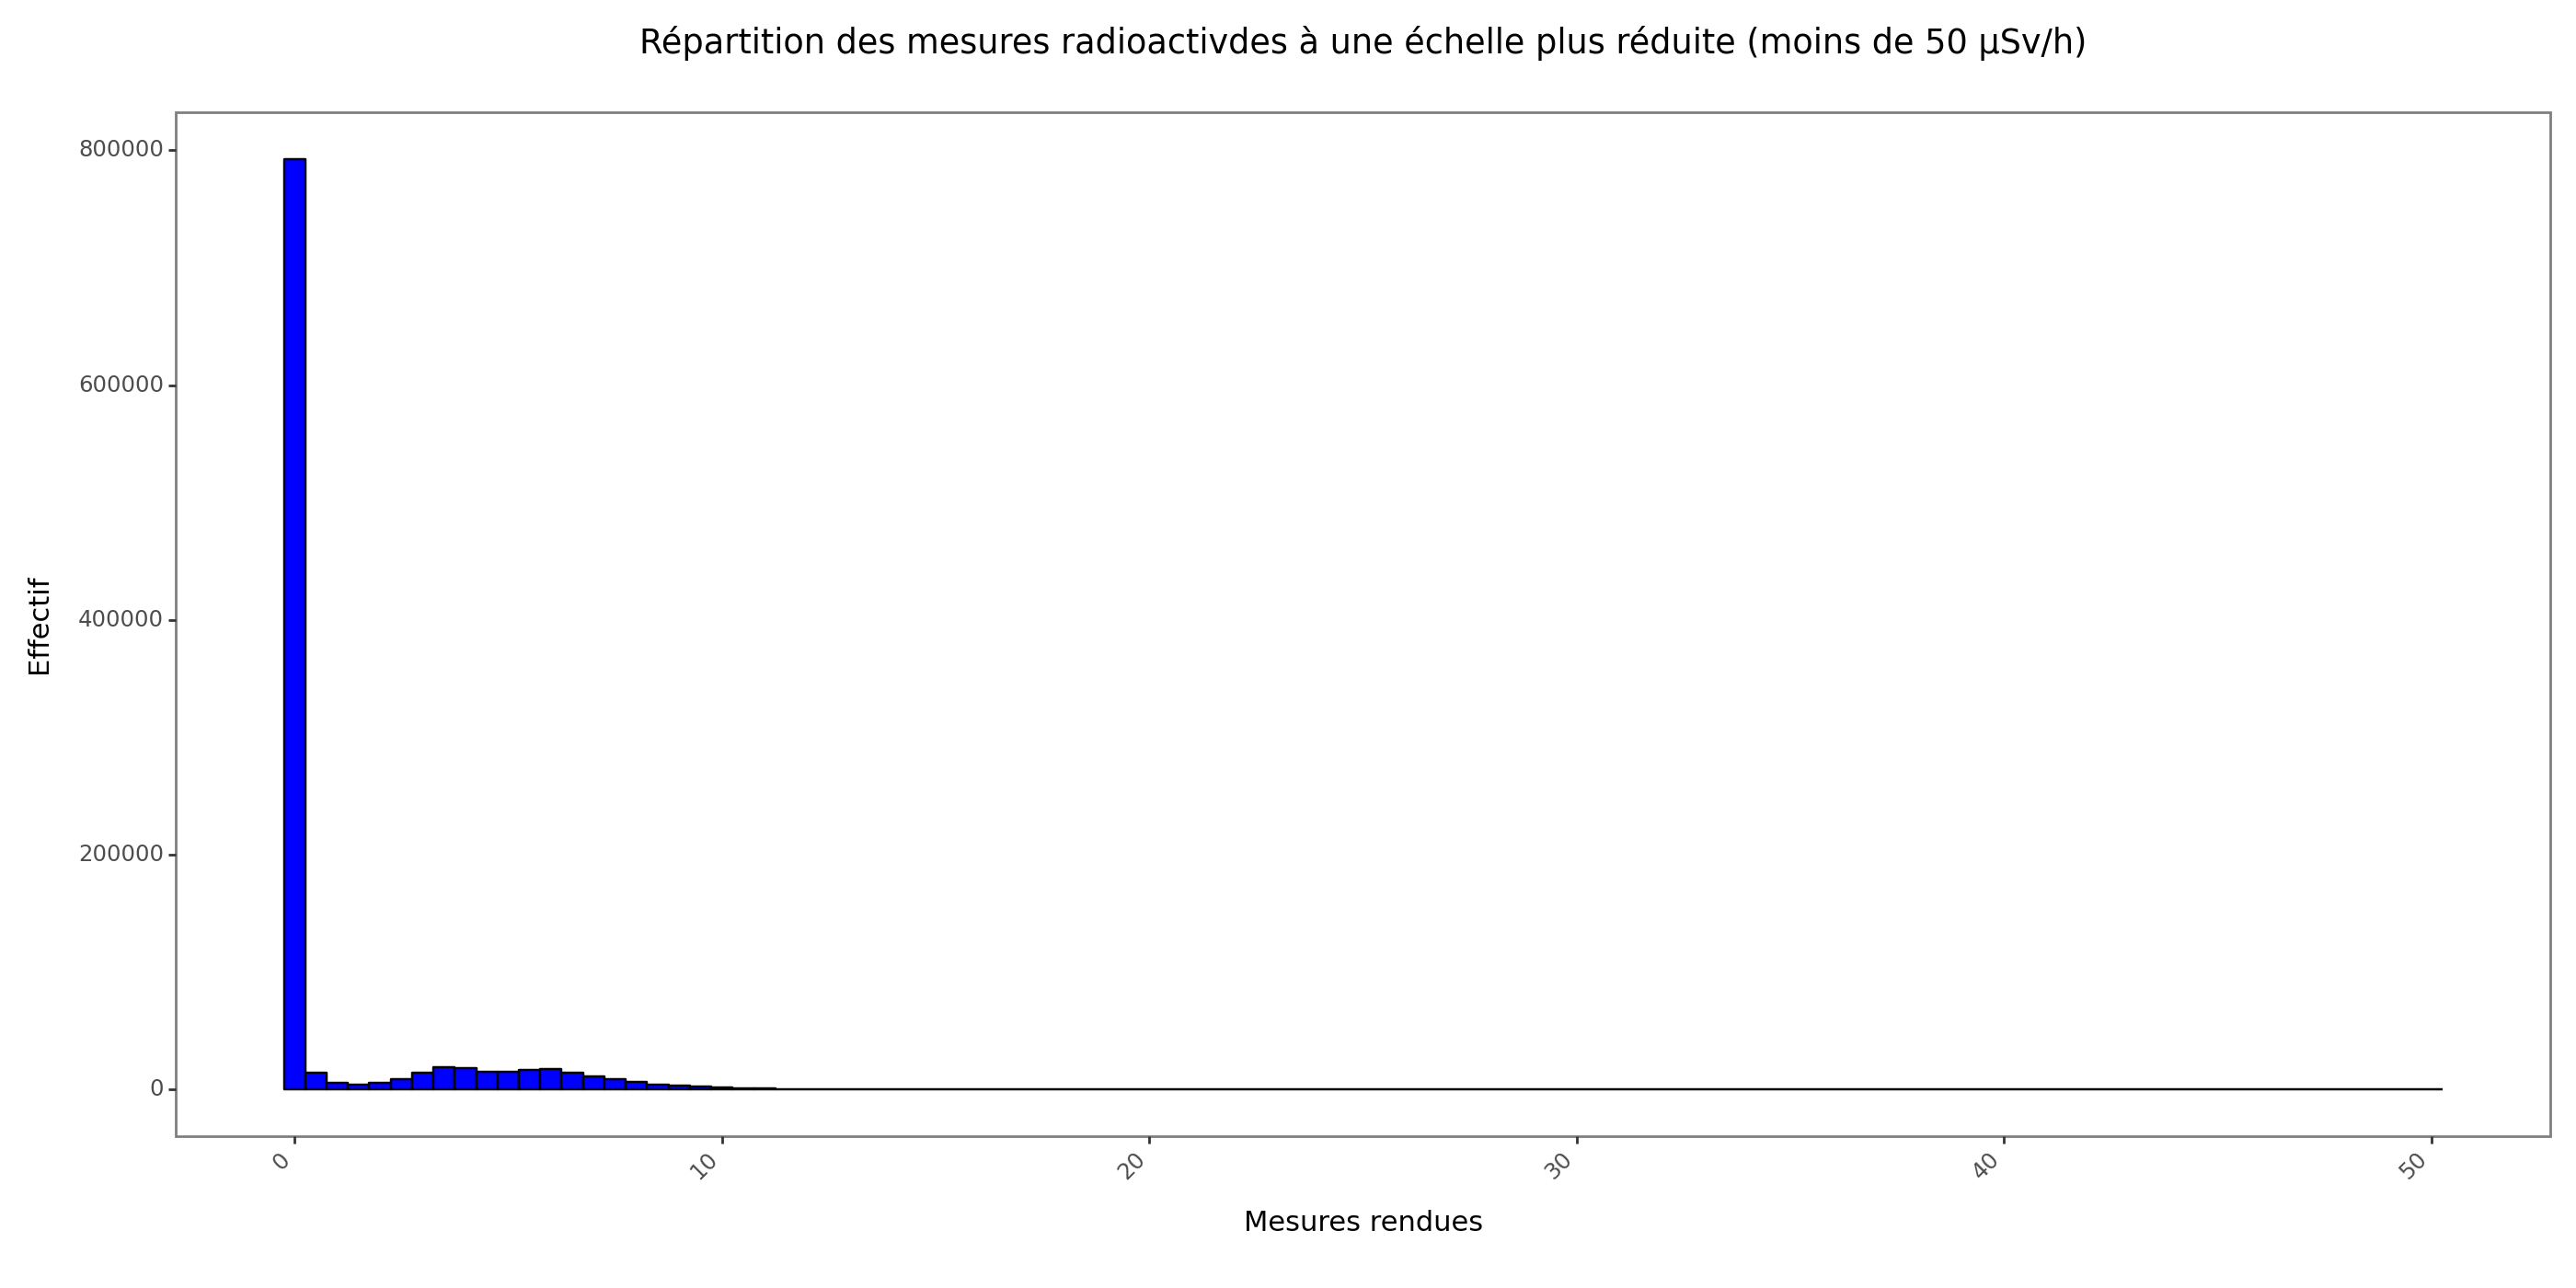

<Figure Size: (1400 x 700)>

: 

In [ ]:
# Voir sur un histogramme avec une échelle plus réduite
(
    plt.ggplot(open_radiation_mesure[open_radiation_mesure["value"] < 50], plt.aes(x="value"))
    + plt.geom_histogram(binwidth=0.5, color="black", fill="blue")
    + plt.labs(title="Répartition des mesures radioactivdes à une échelle plus réduite (moins de 50 µSv/h)",
               x = "Mesures rendues",
               y = "Effectif") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

In [ ]:
# Distribution en boxplot des mesures de radioactivités
(
    plt.ggplot(open_radiation_mesure)
    + plt.geom_boxplot(plt.aes(y="value"))
    + plt.labs(title="Répartition des mesures radioactivdes",
               y = "Mesures rendues (µSv/h)",
               x = "") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

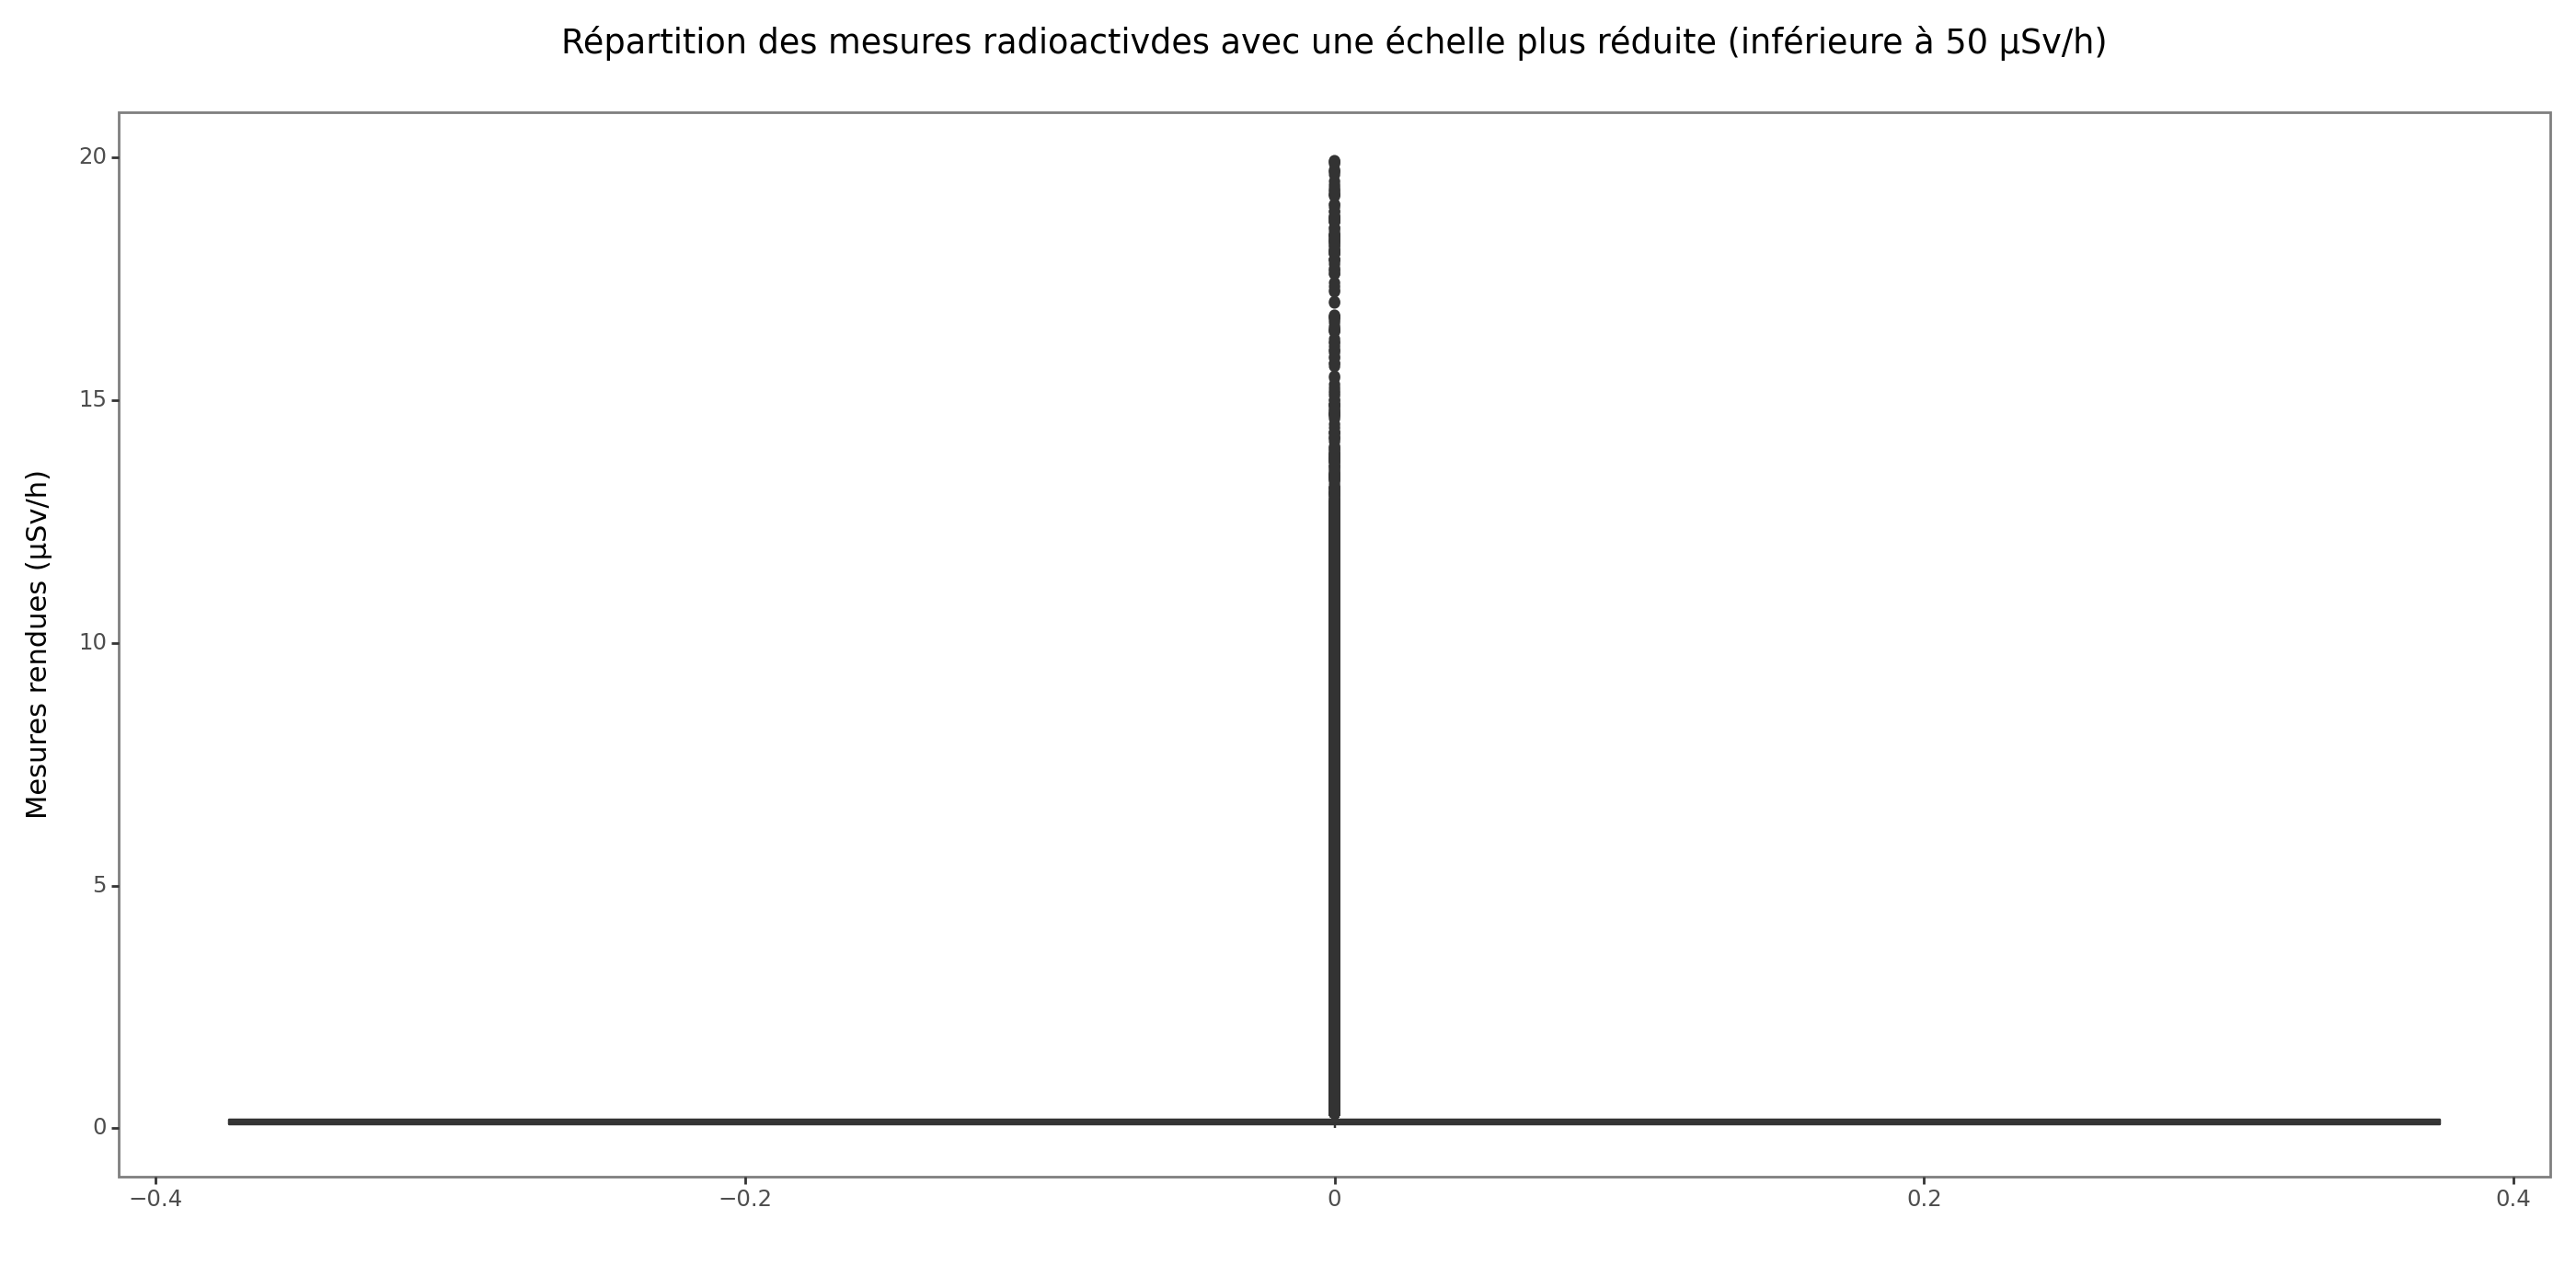

<Figure Size: (1400 x 700)>

In [ ]:
# Distribution en boxplot des mesures de radioactivités
(
    plt.ggplot(open_radiation_mesure[open_radiation_mesure["value"] < 20])
    + plt.geom_boxplot(plt.aes(y="value"))
    + plt.labs(title="Répartition des mesures radioactivdes avec une échelle plus réduite (inférieure à 50 µSv/h)",
               y = "Mesures rendues (µSv/h)",
               x = "") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

### Commentaire :
- la majorité de ces mesures de radioactivité sont très faibles (entre 0 et 1 µSv/h).
- observation malgré tout la présence de certaines mesures dépassant très largement des 1 µSv/h.

In [104]:
open_radiation_mesure[open_radiation_mesure["value"] >= 1].head()

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,...,reliability,atypical,dure,dure_min_float,jour_ann_fin,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin
8394,geiger,2.332322,203.0,2025-07-13 23:53:35.214,2025-07-13 23:55:14.437,0.0,0.0,10000.0,2d891769-fd70-4320-a18b-5e412d4df359,NaN,...,87,1,0 days 00:01:39.223000,1.653717,194,7,2025,3,28,6
8397,geiger,2.507753,205.0,2025-07-13 23:52:02.004,2025-07-13 23:53:35.195,0.0,0.0,10000.0,9209f039-b5e7-48c1-b484-81a213685567,NaN,...,87,1,0 days 00:01:33.191000,1.553183,194,7,2025,3,28,6
8398,geiger,2.858141,201.0,2025-07-13 23:50:41.812,2025-07-13 23:52:01.983,0.0,0.0,10000.0,a4e8352b-ba4f-4039-ae42-e4112426c9f6,NaN,...,87,1,0 days 00:01:20.171000,1.336183,194,7,2025,3,28,6
8399,geiger,3.007876,201.0,2025-07-13 23:49:25.612,2025-07-13 23:50:41.792,0.0,0.0,10000.0,ed99bc71-e951-456c-9d4b-5edd50c67321,NaN,...,87,1,0 days 00:01:16.180000,1.269667,194,7,2025,3,28,6
8401,geiger,3.313091,201.0,2025-07-13 23:48:16.459,2025-07-13 23:49:25.621,0.0,0.0,10000.0,d6e57e35-1179-49ec-b8d5-db804fcdfcd2,NaN,...,87,1,0 days 00:01:09.162000,1.152700,194,7,2025,3,28,6


In [105]:
# Observation de la description de la variable quantitative selon si la mesure est considérée comme atypique ou non
open_radiation_atypique = open_radiation_mesure[open_radiation_mesure["atypical"] == 1]
open_radiation_non_atypique = open_radiation_mesure[open_radiation_mesure["atypical"] == 0]

In [106]:
# Voir la différence entre mesure atypique et non atypique
print(f"dimensions du DataFrame contenant les mesures considérées 'atypiques' : {open_radiation_atypique.shape}")
print(f"dimensions du DataFrame contenant les mesures considérées 'non atypiques' : {open_radiation_non_atypique.shape}")

dimensions du DataFrame contenant les mesures considérées 'atypiques' : (227869, 22)
dimensions du DataFrame contenant les mesures considérées 'non atypiques' : (775172, 22)


In [107]:
print("Les mesures de radioactivité quand les mesures sont atypiques : ")
print(open_radiation_atypique["value"].describe())
print("\nLes mesures de radioactivité quand les mesures sont non atypiques : ")
print(open_radiation_non_atypique["value"].describe())
print(f"\nProportion des mesures atypiques : {round(open_radiation_atypique.shape[0] / open_radiation_non_atypique.shape[0] * 100, 2)} %")

Les mesures de radioactivité quand les mesures sont atypiques : 
count    227869.000000
mean          4.463620
std           3.088651
min           0.200000
25%           2.779000
50%           4.464540
75%           6.225944
max         227.000000
Name: value, dtype: float64

Les mesures de radioactivité quand les mesures sont non atypiques : 
count    775172.000000
mean          0.102021
std           0.030367
min           0.000156
25%           0.081000
50%           0.099000
75%           0.117000
max           0.199988
Name: value, dtype: float64

Proportion des mesures atypiques : 29.4 %


### Commentaire :
- À peu près un tiers de nos mesures sont considérées comme atypique (29.57%)

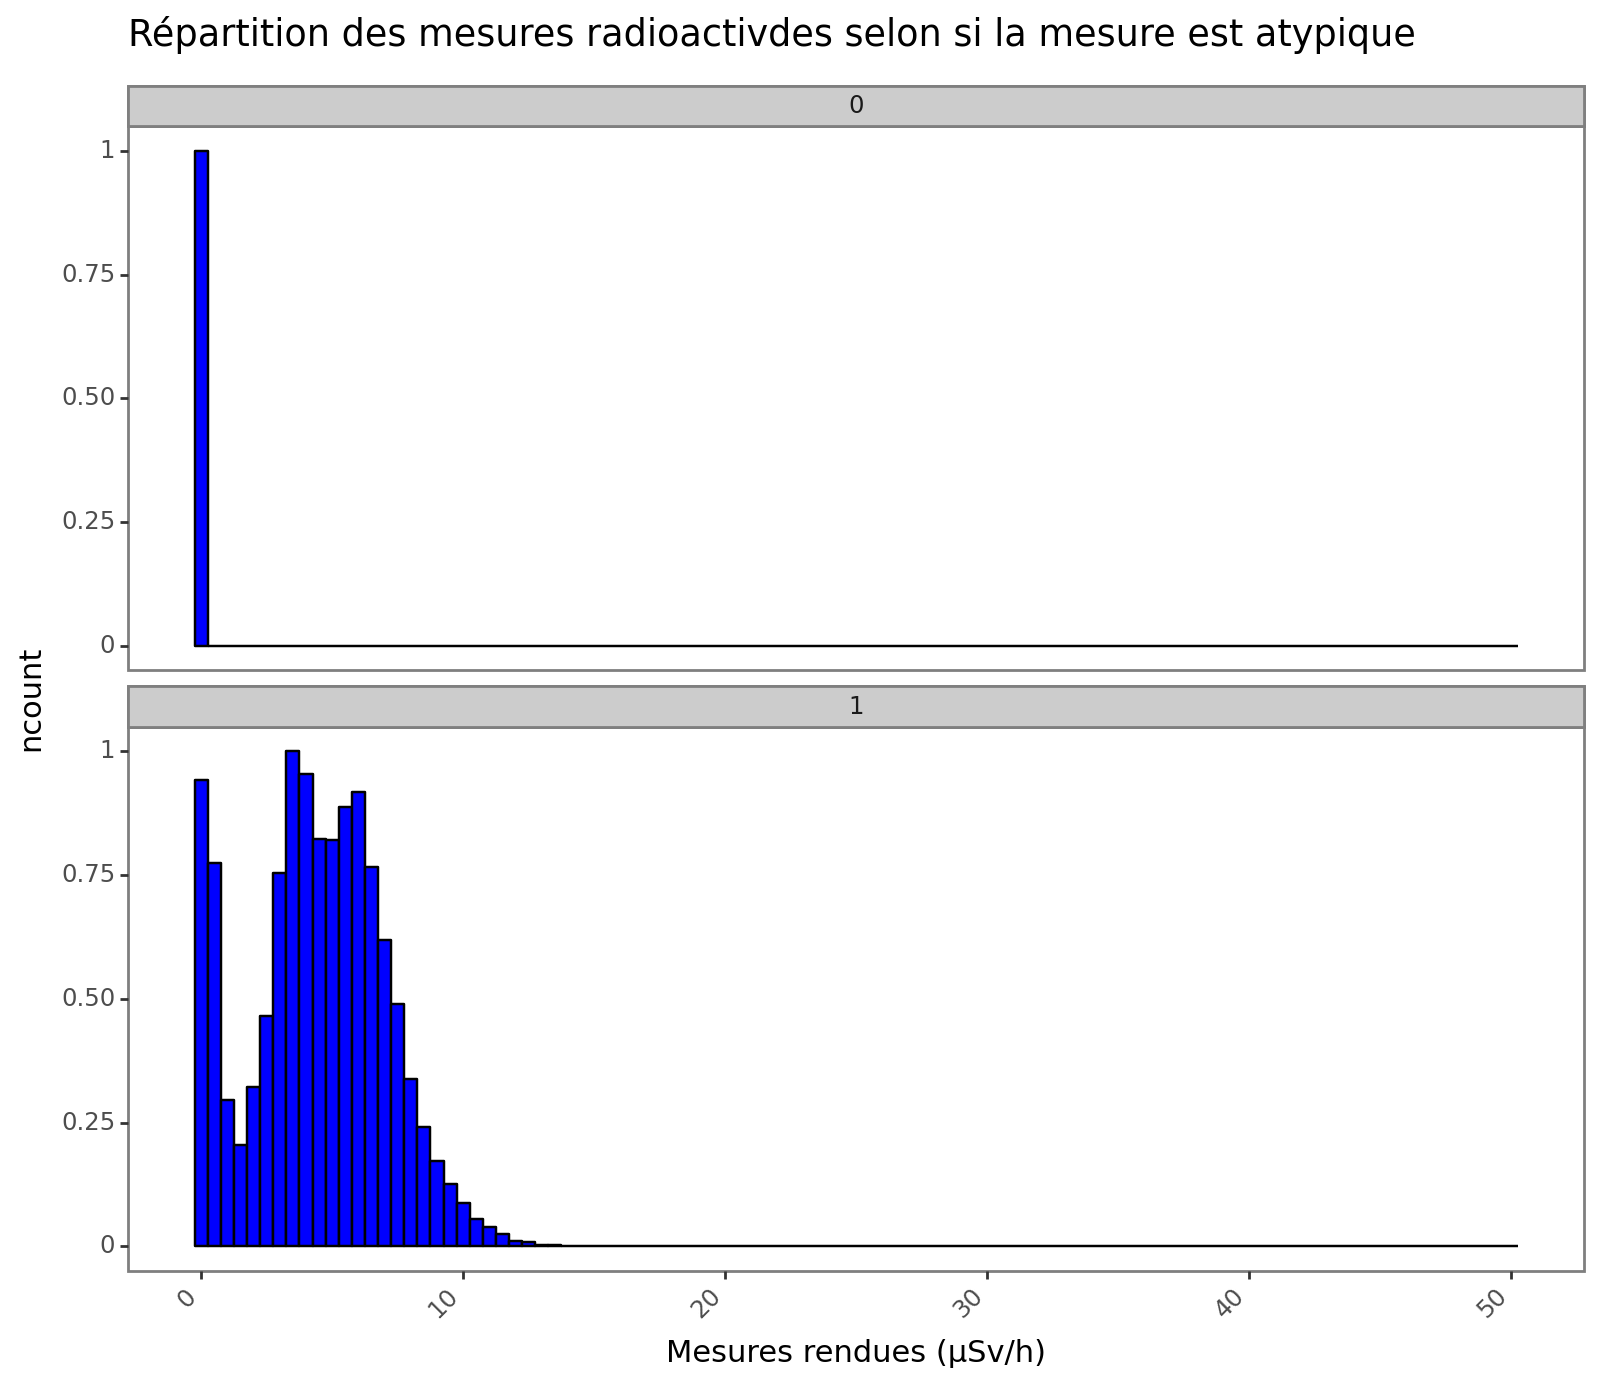

<Figure Size: (800 x 700)>

In [108]:
# Faire les deux histogrammes pour observer la différence entre atypique et non atypique
(
    plt.ggplot(open_radiation_mesure[open_radiation_mesure["value"] < 50], plt.aes(x="value", y=plt.after_stat("ncount")))
    + plt.geom_histogram(color="black", fill="blue", binwidth=0.5)
    + plt.facet_wrap("atypical", ncol=1, nrow=2)
    + plt.labs(title="Répartition des mesures radioactivdes selon si la mesure est atypique",
               x = "Mesures rendues (µSv/h)") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(8, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

### Commentaire :
- Les mesures atypiques ont toujours des mesures plus élevées contrairement aux mesures non "atypiques"

In [109]:
# Séparation en plusieurs intervalles avec notre variable quantitatives (source : https://www.openradiation.org/fr/dashboard)
# Source de la méthode de pandas : https://pandas.pydata.org/docs/reference/api/pandas.cut.html
open_radiation_mesure["intervalle_mesure"] = pd.cut(open_radiation_mesure["value"], bins=[0, 0.020, 0.040, 0.060, 0.080, 0.120, 0.130, 0.140, 0.160, 0.180, 0.2, np.inf], right=False, include_lowest=True, ordered=False,
                                                     labels=["0-0,020", "0,020-0,040", 
                                                             "0,040-0,060", "0,060-0,080", "0,080-0,120", "0,120-0,130", 
                                                             "0,130-0,140", "0,140-0,160", "0,160-0,180", "0,180-0,200", "0,200 et plus"])

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\785126931.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
# Calcul de l'effectif pour chaque modalité
open_radiation_mesure["intervalle_mesure"].value_counts()

intervalle_mesure
0,080-0,120      418813
0,200 et plus    227869
0,060-0,080      137790
0,120-0,130       57893
0,140-0,160       44642
0,130-0,140       31211
0,040-0,060       30772
0,160-0,180       27540
0,180-0,200       19528
0,020-0,040        6236
0-0,020             747
Name: count, dtype: int64

In [111]:
# Conversion en pourcentage
series_percent = open_radiation_mesure["intervalle_mesure"].value_counts(normalize=True) * 100
print(series_percent)

intervalle_mesure
0,080-0,120      41.754325
0,200 et plus    22.717815
0,060-0,080      13.737225
0,120-0,130       5.771748
0,140-0,160       4.450666
0,130-0,140       3.111638
0,040-0,060       3.067871
0,160-0,180       2.745650
0,180-0,200       1.946880
0,020-0,040       0.621709
0-0,020           0.074474
Name: proportion, dtype: float64


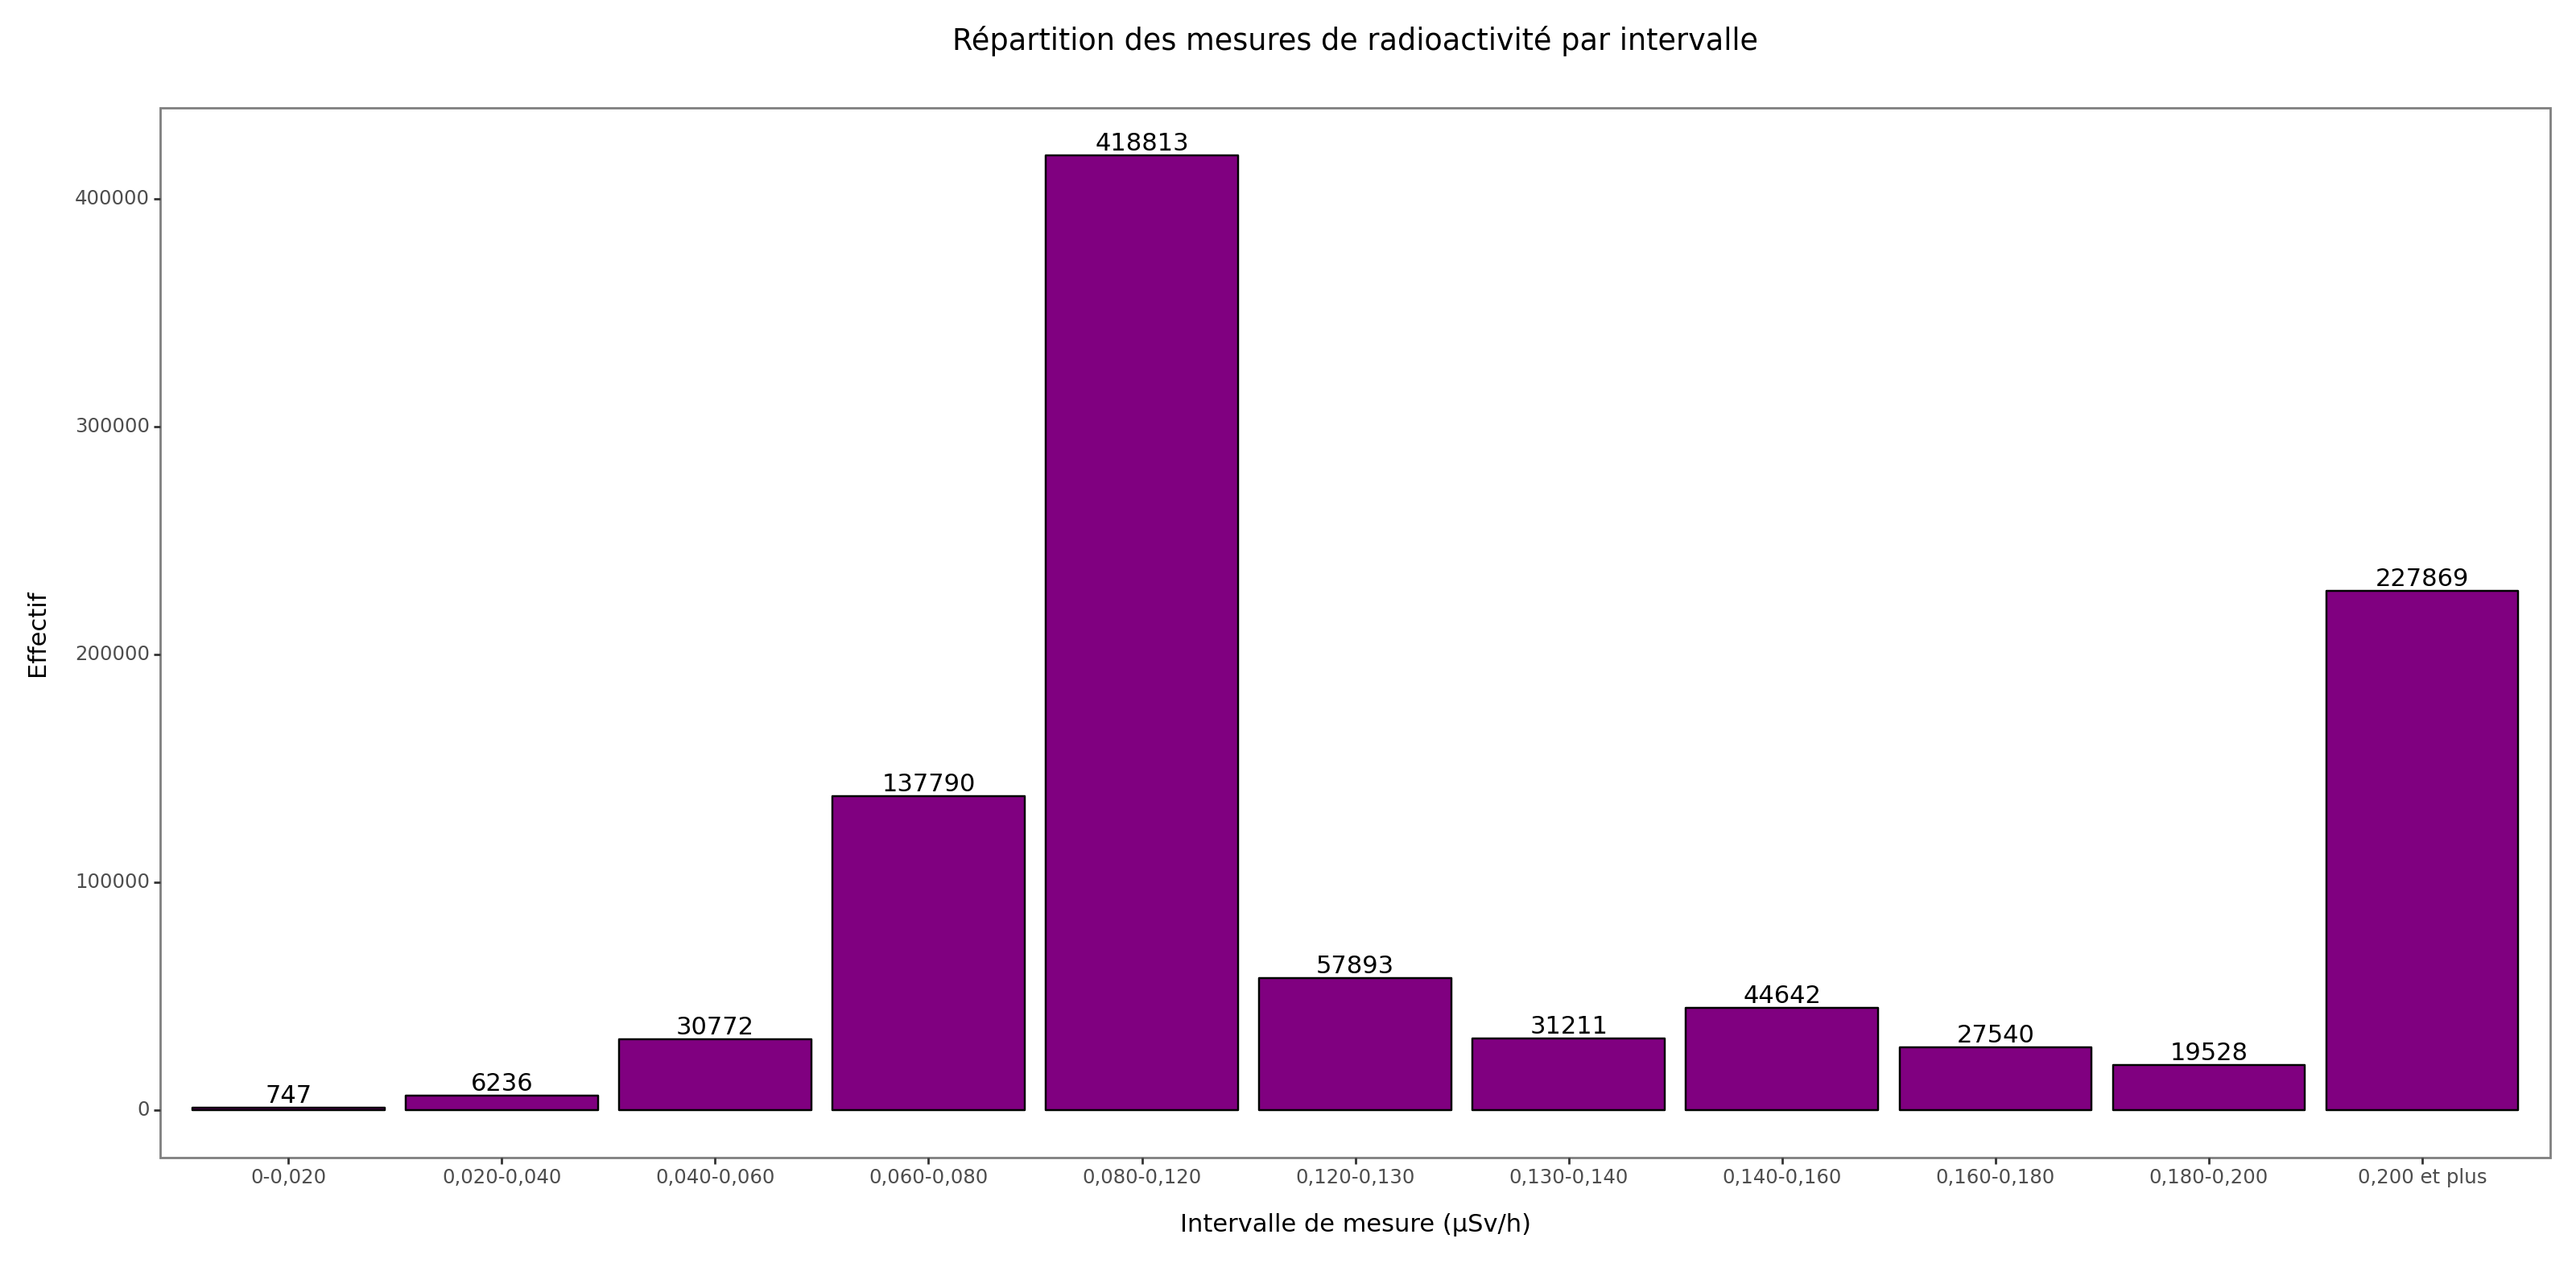

<Figure Size: (1600 x 800)>

In [112]:
# Visuel graphique sur les intervalles de mesures
(
plt.ggplot(open_radiation_mesure, plt.aes(x="factor(intervalle_mesure)")) # Jeu de données
    + plt.geom_bar(color="black",
                   fill="purple") # Ajout du type de graphique avec couleur des bordures + barres
    + plt.labs(title="Répartition des mesures de radioactivité par intervalle",
               x = "Intervalle de mesure (µSv/h)",
               y = "Effectif") # Ajout des titres
    + plt.geom_text(
        plt.aes(label=plt.after_stat("count")), stat="count", nudge_y=0.125, va="bottom"
    ) # Ajout des effectifs (labels)
    + plt.theme_bw() # Thème utilisé
    + plt.theme(figure_size=(16, 8), # Taille de la figure
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

In [113]:
# Transformation en dataframe
df_percent = series_percent.reset_index()
df_percent.columns = ["Intervalle de mesure", "percent"]

In [114]:
df_percent

,Intervalle de mesure,percent
0,"0,080-0,120",41.754325
1,"0,200 et plus",22.717815
2,"0,060-0,080",13.737225
3,"0,120-0,130",5.771748
4,"0,140-0,160",4.450666
5,"0,130-0,140",3.111638
6,"0,040-0,060",3.067871
7,"0,160-0,180",2.745650
8,"0,180-0,200",1.946880
9,"0,020-0,040",0.621709


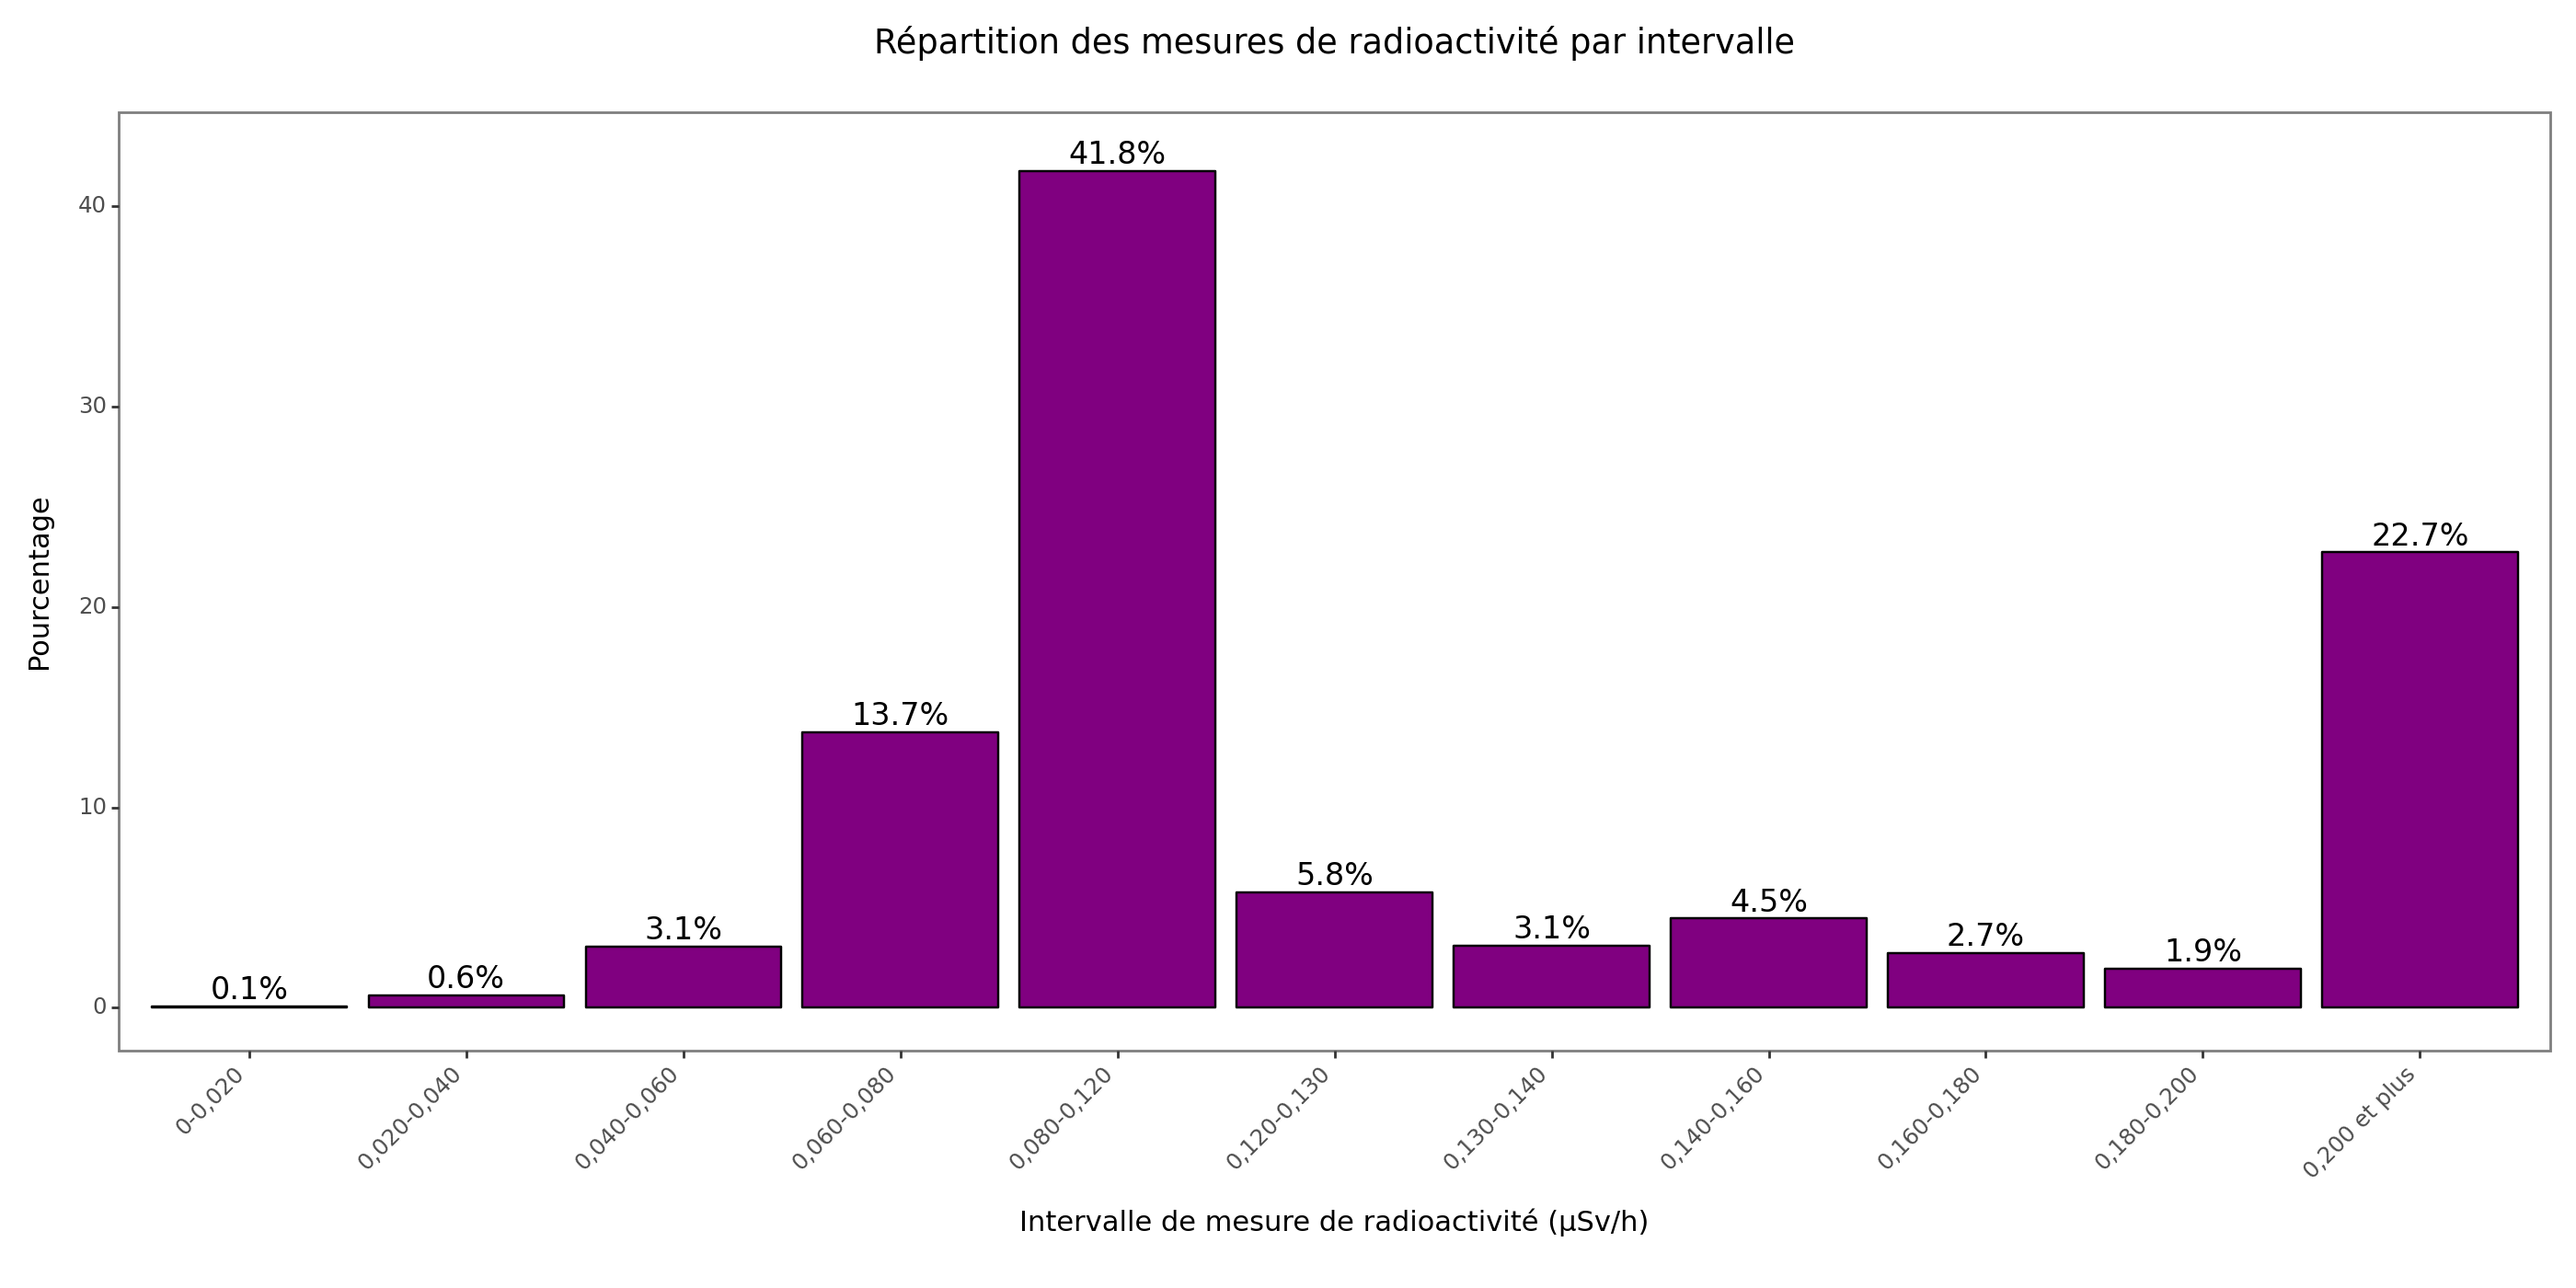

<Figure Size: (1400 x 700)>

In [115]:
# Visuel graphique en pourcentage
(
plt.ggplot(df_percent, plt.aes(x="Intervalle de mesure", y="percent")) # Jeu de données
    + plt.geom_bar(stat = "identity",
                   color="black",
                   fill="purple") # Ajout du type de graphique avec couleur des bordures + barres
    + plt.labs(title="Répartition des mesures de radioactivité par intervalle",
               x = "Intervalle de mesure de radioactivité (µSv/h)",
               y = "Pourcentage") # Ajout des titres
    + plt.geom_text(
        plt.aes(label = "percent"),
        size = 12,
        nudge_y=0.8,
        format_string="{:.1f}%") # Ajout des pourcentages (labels), format_string=format de la chaîne de caractère
    + plt.theme_bw() # Thème utilisé
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

### Commentaire :
- 41,6% des mesures ont une valeur entre 0,080 inclus et 0,120 exclus (µSv/h).
- 22,8% de nos mesures ont une valeur entre 0.200 et plus en µSv/h

In [116]:
open_radiation_mesure.dtypes

apparatusSensorType              category
value                             float64
hitsNumber                        float64
startTime                  datetime64[ns]
endTime                    datetime64[ns]
latitude                          float64
longitude                         float64
altitude                          float64
reportUuid                         object
measurementHeight                 float64
measurementEnvironment           category
qualification                    category
reliability                         int64
atypical                         category
dure                      timedelta64[ns]
dure_min_float                    float64
jour_ann_fin                     category
mois_fin                         category
ann_fin                          category
trim_fin                         category
sem_fin                          category
jour_sem_fin                     category
intervalle_mesure                category
dtype: object

Regardons maintenant selon la valeur si elle est atypique ou non.

In [117]:
# Calcul des profils lignes
prof_lign_atyp = pd.crosstab(open_radiation_mesure["intervalle_mesure"], open_radiation_mesure["atypical"], normalize="index")

In [118]:
# Vérification du succès de l'opération
round(prof_lign_atyp * 100, 2)

atypical,0,1
intervalle_mesure,,
"0-0,020",100.0,0.0
"0,020-0,040",100.0,0.0
"0,040-0,060",100.0,0.0
"0,060-0,080",100.0,0.0
"0,080-0,120",100.0,0.0
"0,120-0,130",100.0,0.0
"0,130-0,140",100.0,0.0
"0,140-0,160",100.0,0.0
"0,160-0,180",100.0,0.0


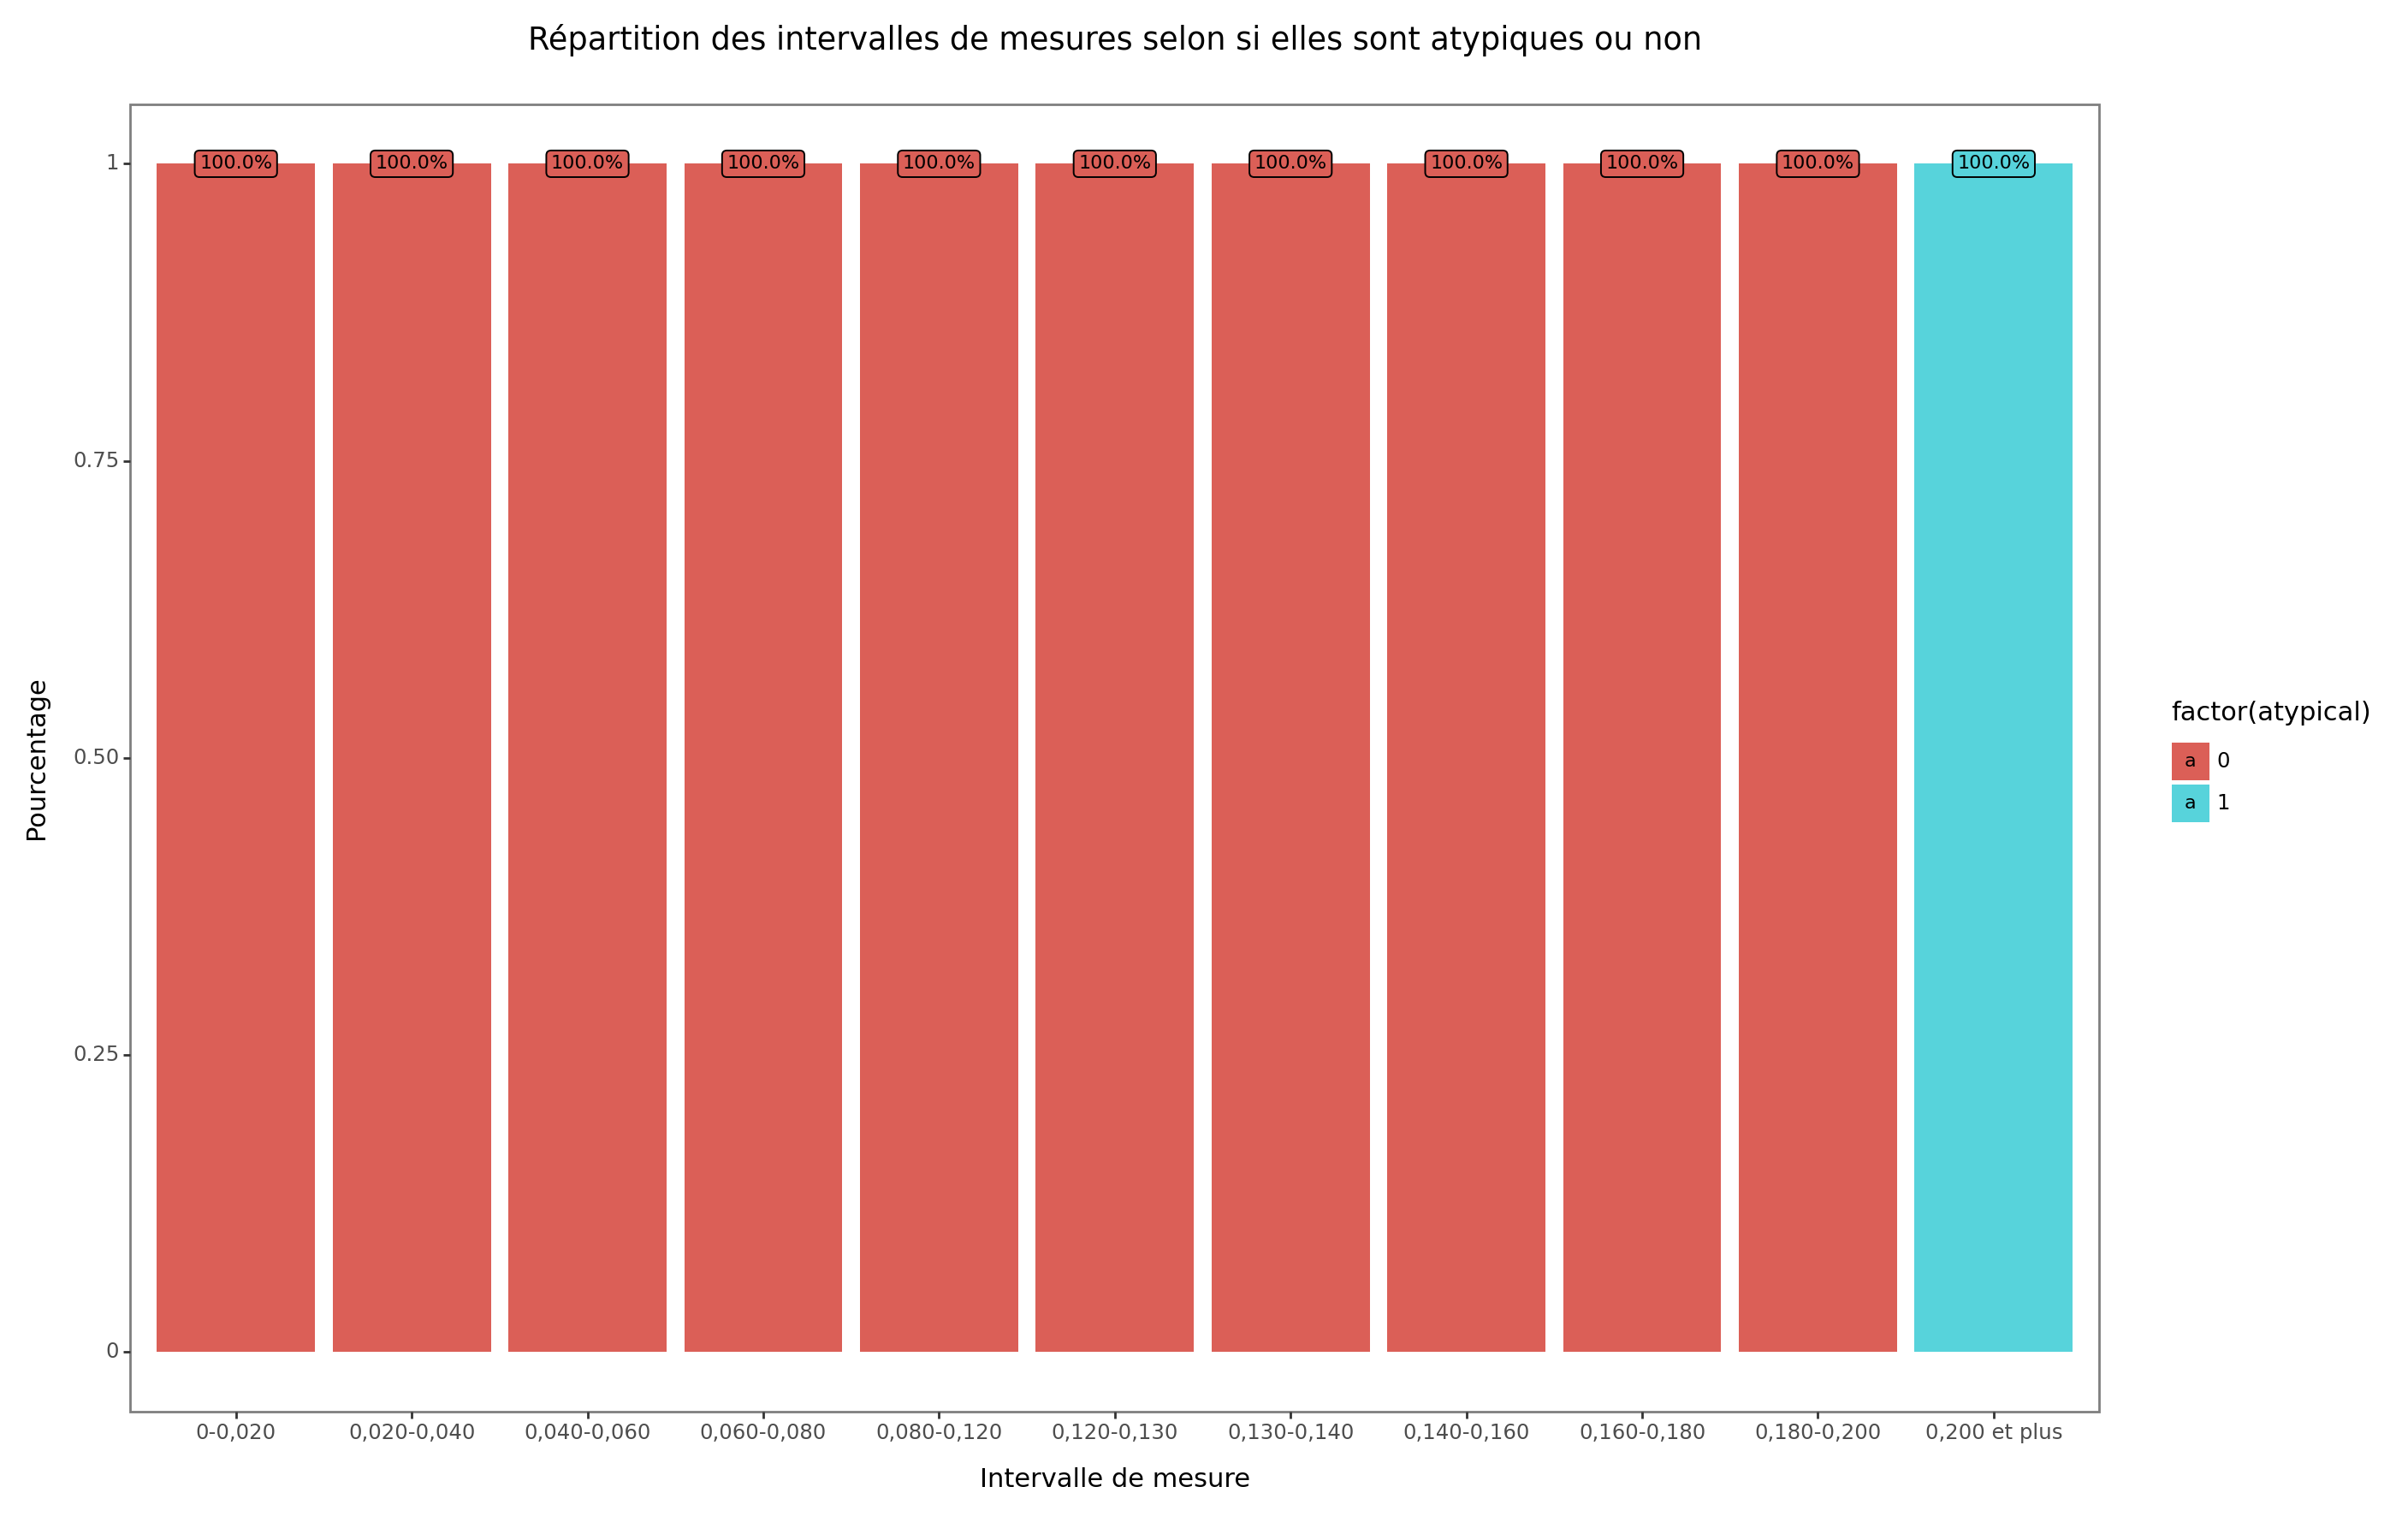

<Figure Size: (1400 x 900)>

In [119]:
# Création du graphique en barre 100%
# Création d'une fonction de calcul
def prop_per_x(x, count):
    """
    Calcul des profils-lignes
    """
    df = pd.DataFrame({"x": x, "count": count})
    prop = df["count"] / df.groupby("x")["count"].transform("sum")
    return prop

(
    plt.ggplot(open_radiation_mesure, plt.aes("factor(intervalle_mesure)", fill="factor(atypical)"))
    + plt.geom_bar(position="fill")
    + plt.geom_label(
        plt.aes(label=plt.after_stat("prop_per_x(x, count) * 100")),
        stat="count",
        position="fill",
        format_string="{:.1f}%",
        size=8,
    )
    + plt.labs(
        title="Répartition des intervalles de mesures selon si elles sont atypiques ou non",
        x = "Intervalle de mesure",
        y = "Pourcentage"
    )
    + plt.theme_bw()
    + plt.theme(
        figure_size=(14, 9),
        plot_title=plt.element_text(ha='center'),
        panel_grid=plt.element_blank()
    )

)

### Commentaire :
- Toutes les mesures atypiques se trouvent dans l'intervalle 0,200 et plus en µSv/h

### **Mesures prises par mois**

In [120]:
# Calcul en proportion des mesures prises par mois
series_percent = open_radiation_mesure["mois_fin"].value_counts(normalize=True) * 100
print(series_percent)

mois_fin
6     20.827862
7     13.305737
5     11.210210
3      8.254498
4      7.050958
8      7.006194
12     6.565135
2      6.458161
10     5.191712
9      5.158413
11     4.763115
1      4.208003
Name: proportion, dtype: float64


In [121]:
# Transformation en dataframe
df_percent = series_percent.reset_index()
df_percent.columns = ["Mois", "percent"]

In [122]:
df_percent

,Mois,percent
0,6,20.827862
1,7,13.305737
2,5,11.210210
3,3,8.254498
4,4,7.050958
5,8,7.006194
6,12,6.565135
7,2,6.458161
8,10,5.191712
9,9,5.158413


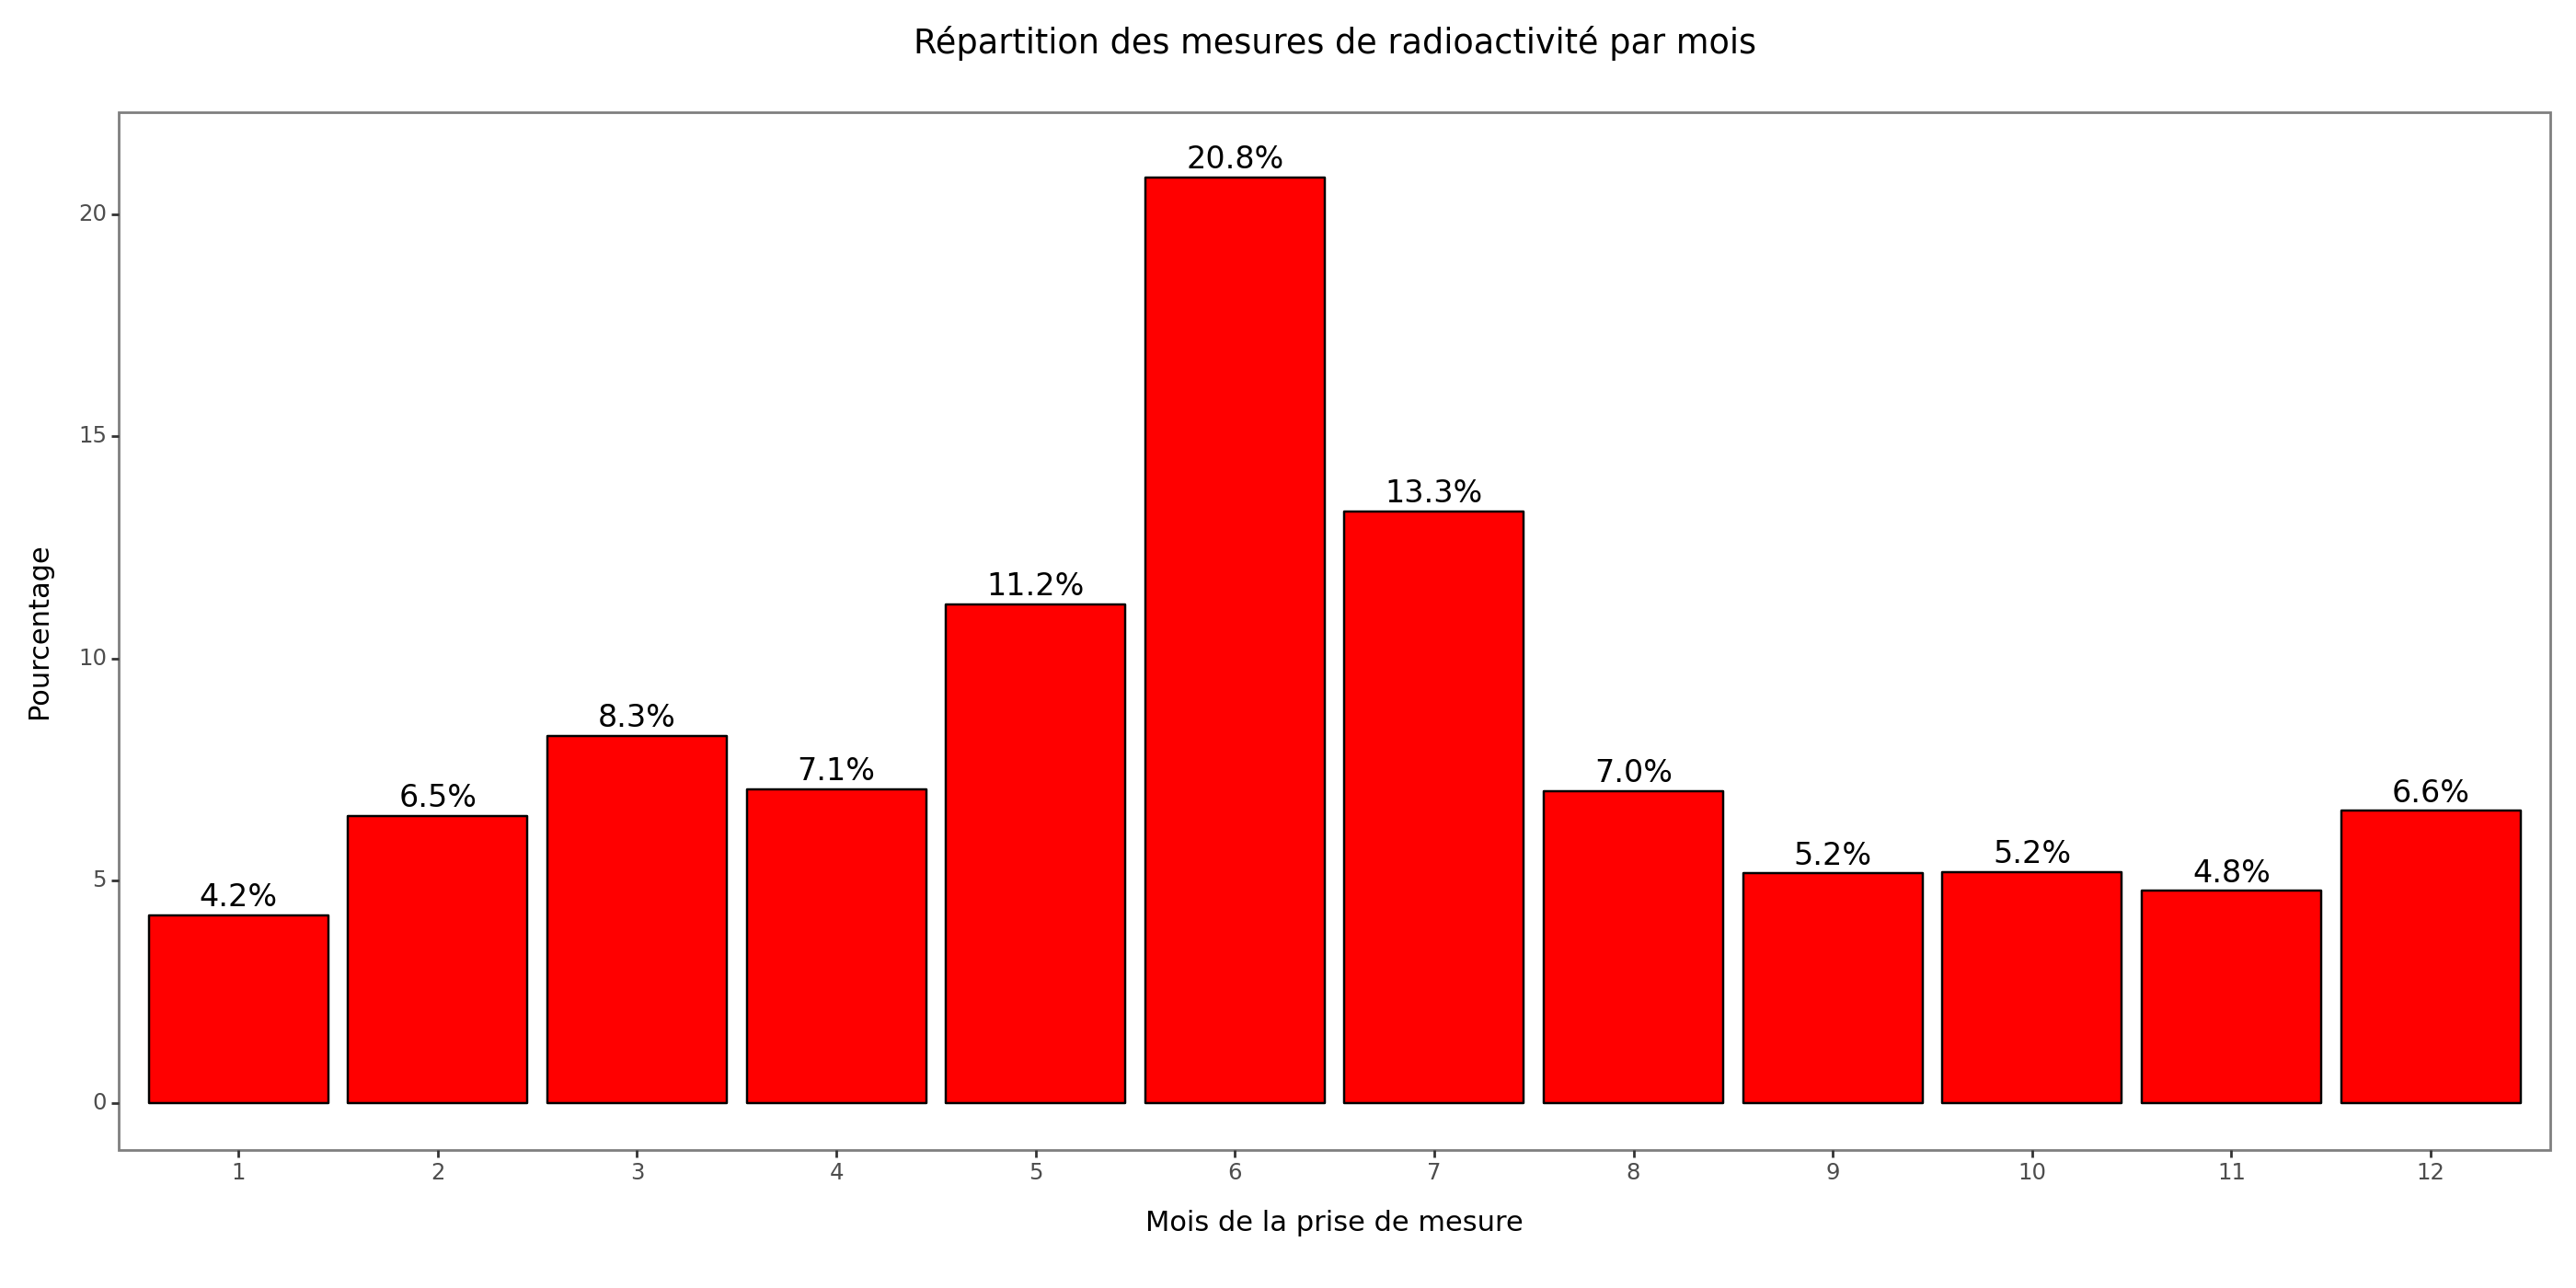

<Figure Size: (1400 x 700)>

In [123]:
# Visuel graphique en pourcentage
(
plt.ggplot(df_percent, plt.aes(x="Mois", y="percent")) # Jeu de données
    + plt.geom_bar(stat = "identity",
                   color="black",
                   fill="red") # Ajout du type de graphique avec couleur des bordures + barres
    + plt.labs(title="Répartition des mesures de radioactivité par mois",
               x = "Mois de la prise de mesure",
               y = "Pourcentage") # Ajout des titres
    + plt.geom_text(
        plt.aes(label = "percent"),
        size = 12,
        nudge_y=0.4,
        format_string="{:.1f}%") # Ajout des pourcentages (labels), format_string=format de la chaîne de caractère
    + plt.theme_bw() # Thème utilisé
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                plot_title=plt.element_text(ha='center'),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

In [124]:
# Analyse du tableau de contingence entre les mois de mesures et l'intervalle de mesure
round(pd.crosstab(open_radiation_mesure["mois_fin"], open_radiation_mesure["intervalle_mesure"], normalize="index") * 100, 2)

intervalle_mesure,"0-0,020","0,020-0,040","0,040-0,060","0,060-0,080","0,080-0,120","0,120-0,130","0,130-0,140","0,140-0,160","0,160-0,180","0,180-0,200","0,200 et plus"
mois_fin,,,,,,,,,,,
1,0.10,1.06,3.32,14.39,39.75,4.39,2.23,2.36,0.99,0.53,30.89
2,0.08,0.53,2.67,11.32,46.09,7.19,3.50,4.11,2.31,1.57,20.64
3,0.05,0.44,2.36,11.37,42.17,5.56,3.04,3.15,1.30,0.53,30.03
4,0.05,0.73,4.47,17.85,53.80,5.57,2.66,2.59,0.91,0.35,11.02
5,0.10,1.36,5.03,15.40,52.06,5.77,2.42,2.55,1.45,1.24,12.62
6,0.06,0.58,3.56,13.44,36.55,5.31,3.11,5.02,3.37,2.52,26.48
7,0.04,0.22,2.16,12.98,42.40,7.28,4.35,7.25,5.01,3.92,14.40
8,0.02,0.27,1.96,14.04,42.55,6.99,4.31,7.79,5.03,3.88,13.15
9,0.24,0.51,2.58,18.51,55.36,7.37,3.07,2.79,1.06,0.65,7.86


In [125]:
# Couleur graduées
import matplotlib.pyplot as mpl
import matplotlib.colors as mcolors
import numpy as np

n = open_radiation_mesure["intervalle_mesure"].nunique()

# RdYlGn_r : vert → rouge, générer n couleurs
colors = [mcolors.to_hex(mpl.cm.RdYlGn_r(i / (n - 1))) for i in range(n)]

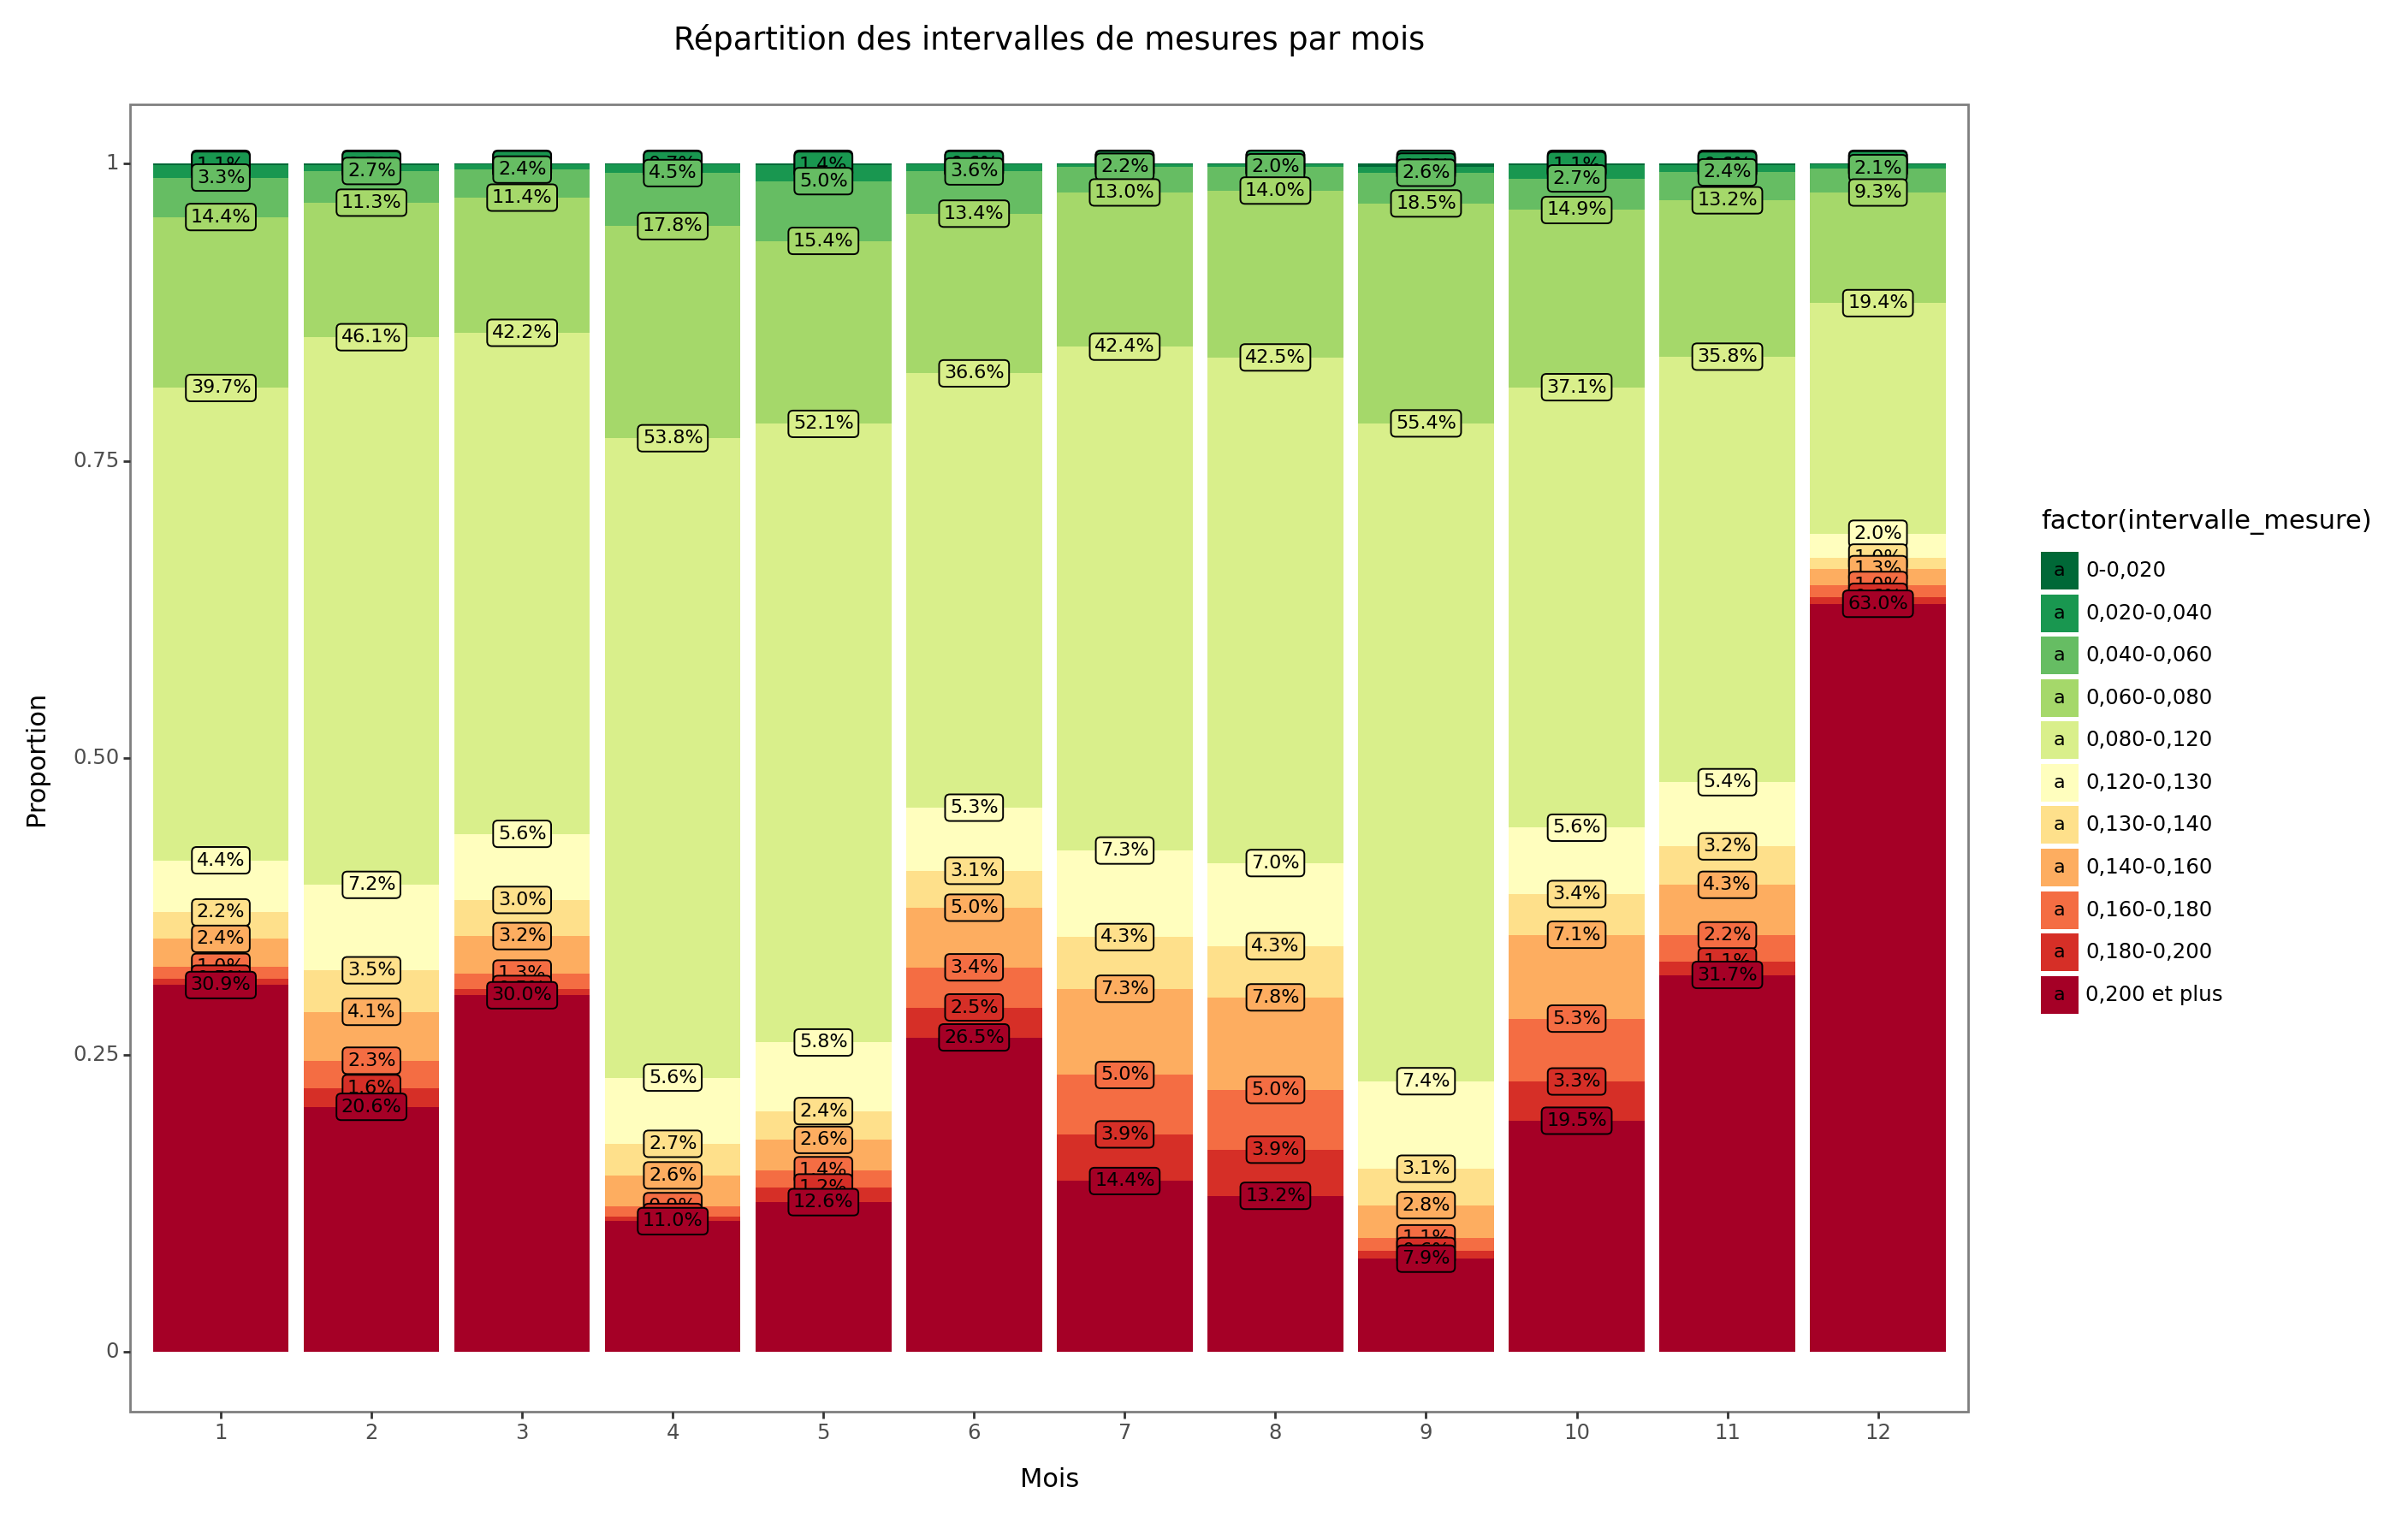

<Figure Size: (1400 x 900)>

In [126]:
# Visuel graphique 
(
    plt.ggplot(open_radiation_mesure, plt.aes("factor(mois_fin)", fill="factor(intervalle_mesure)"))
    + plt.geom_bar(position="fill")
    + plt.geom_label(
        plt.aes(label=plt.after_stat("prop_per_x(x, count) * 100")),
        stat="count",
        position="fill",
        format_string="{:.1f}%",
        size=8,
    )
    + plt.scale_fill_manual(values=colors)
    + plt.labs(
        title="Répartition des intervalles de mesures par mois",
        x="Mois",
        y="Proportion"
    )
    + plt.theme_bw()
    + plt.theme(
        figure_size=(14, 9),
        plot_title=plt.element_text(ha='center'),
        panel_grid=plt.element_blank()
    )
)

### Commentaire :
- Pour le mois de décembre, plus de 60% des mesures ont une valeur entre 0,200 et plus en µSv/h
- Les mois d'avril, mai et septembre ont pour plus de 50% des mesures une valeur entre 0,80-0,120 µSv/h
- Les mois de janvier, mars, juin et novembre ont pour chacun un tiers des mesures entre 0,200 et plus en µSv/h 

In [127]:
# Calcul de la moyenne par mois des mesures de radioactivité
moyenne_mesure = open_radiation_mesure.groupby("mois_fin")["value"].mean().reset_index()
moyenne_mesure

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\3404635337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,mois_fin,value
0,1,1.375314
1,2,1.079112
2,3,1.561648
3,4,0.512417
4,5,0.530385
5,6,1.267889
6,7,0.599820
7,8,0.593836
8,9,0.352734
9,10,0.828610


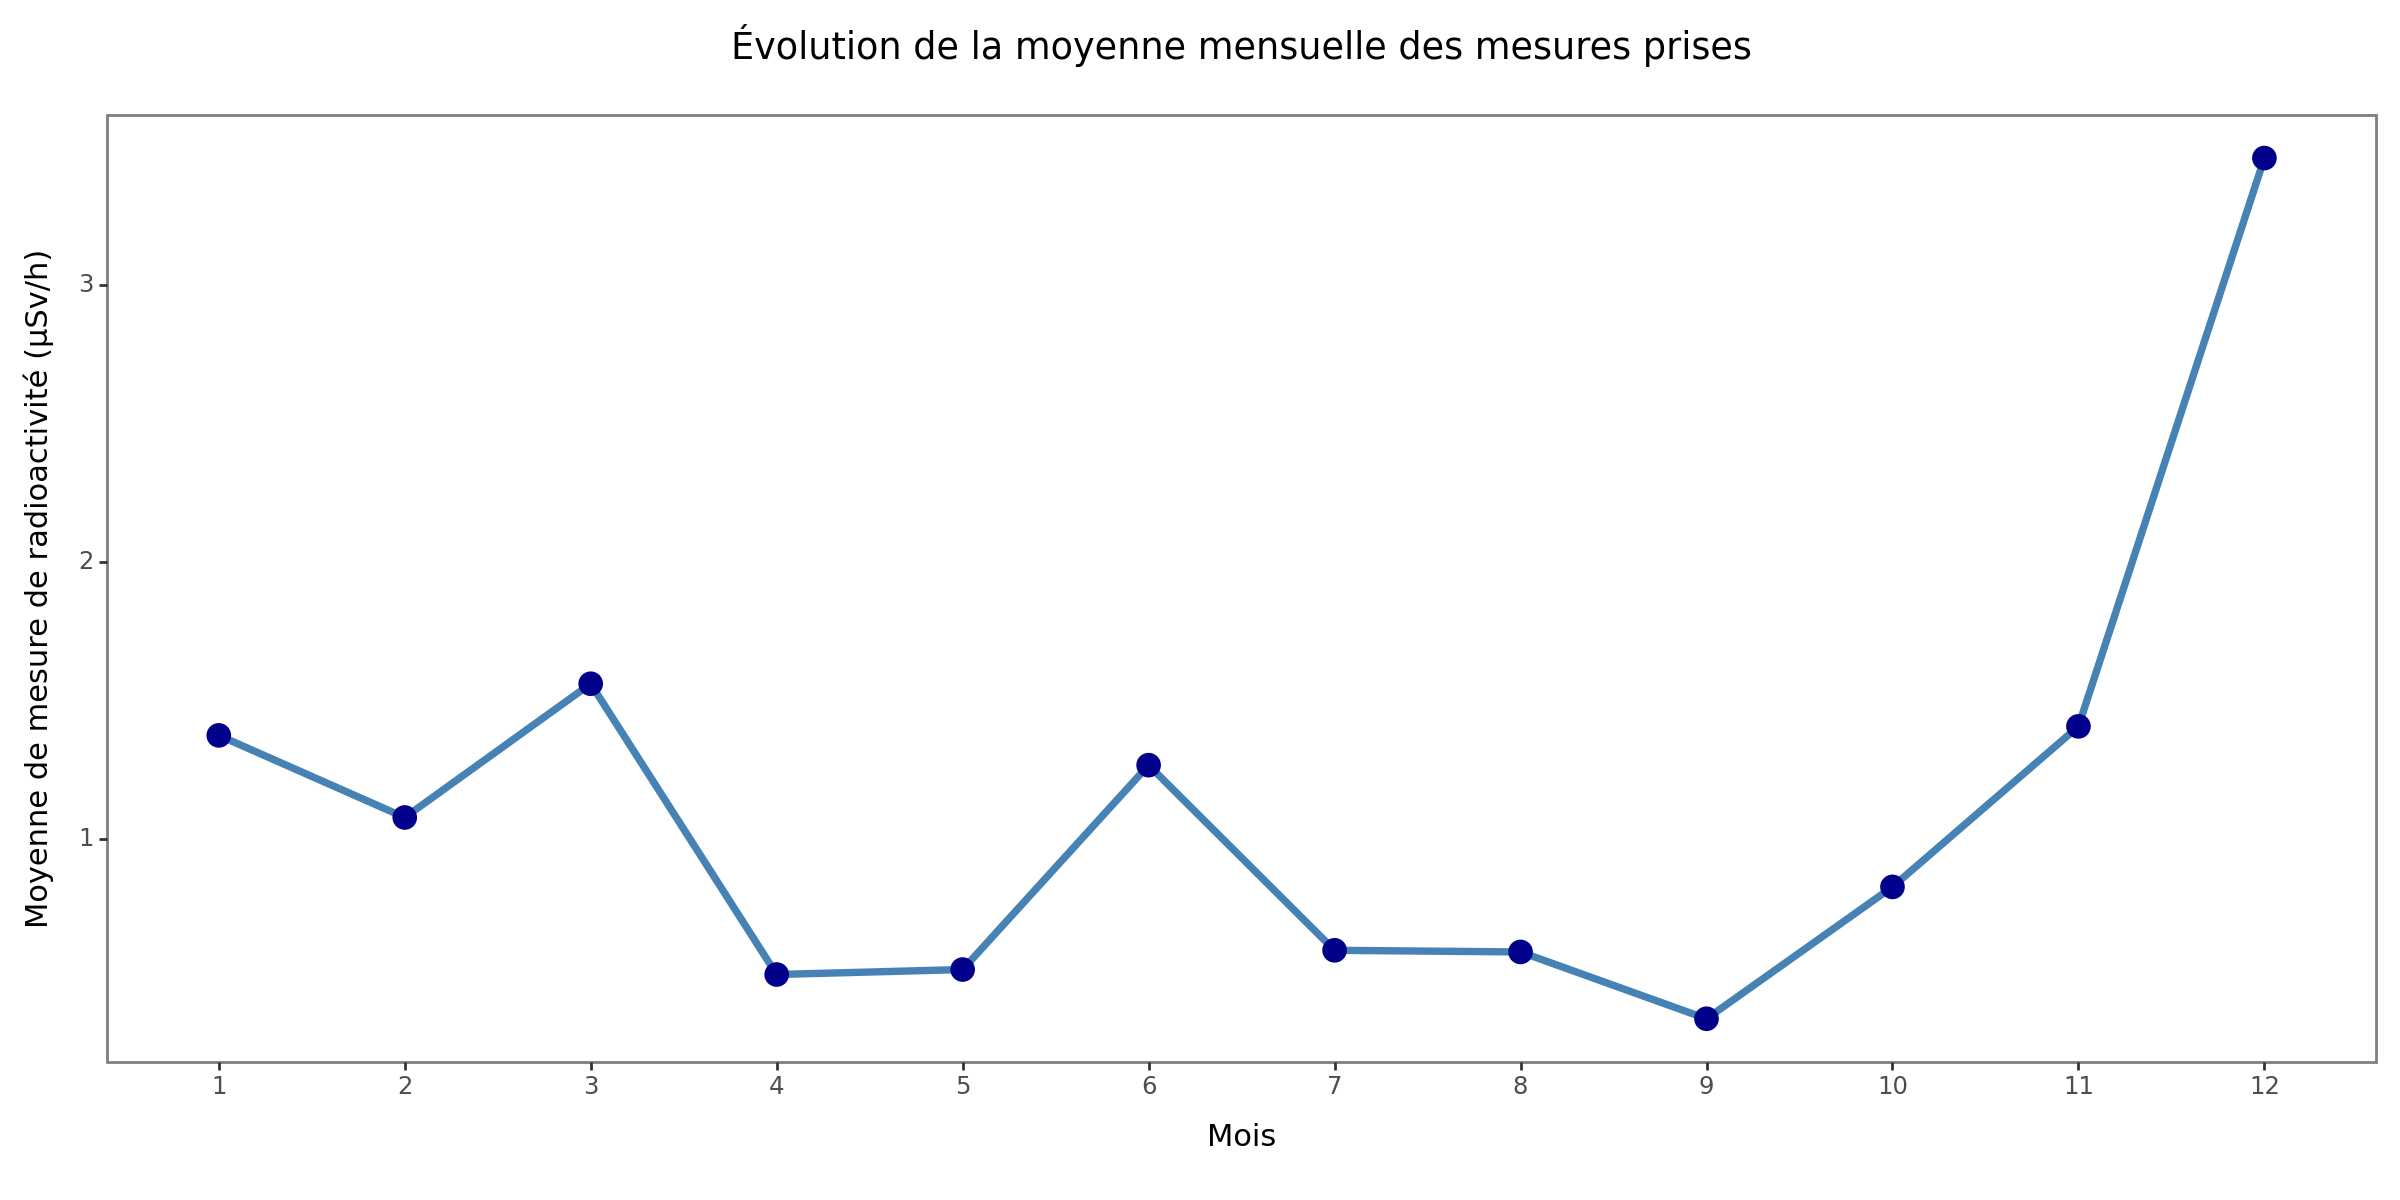

<Figure Size: (1200 x 600)>

In [128]:
# Courbe sur la moyenne des mesures par mois
(
    plt.ggplot(moyenne_mesure, plt.aes(x="mois_fin", y="value", group=1))
    + plt.geom_line(color="steelblue", size=1.5)
    + plt.geom_point(color="darkblue", size=4)
    + plt.labs(
        title="Évolution de la moyenne mensuelle des mesures prises",
        x="Mois",
        y="Moyenne de mesure de radioactivité (µSv/h)"
    )
    + plt.theme_bw()
    + plt.theme(
        figure_size=(12, 6),
        plot_title=plt.element_text(ha='center'),
        panel_grid=plt.element_blank()
    )
)

### Commentaire :
- Observation d'une augmentation énorme de la radioactivité en décembre mesurée en moyenne
- Deux autres pics observés pour le mois de mars et juin en moyenne des mesures observées

### Mesures prises par année (suivi par mois)

In [129]:
# Observons la moyenne de radioactivité par année
moyenne_mesure = open_radiation_mesure.groupby("ann_fin")["value"].mean().reset_index()
moyenne_mesure

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\2770887879.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,ann_fin,value
0,1970,NaN
1,1982,0.100500
2,2000,0.201526
3,2007,0.084000
4,2012,0.093078
5,2013,0.097621
6,2014,1.447140
7,2015,0.190921
8,2016,0.129905
9,2017,0.156112


In [130]:
round(open_radiation_mesure["ann_fin"].value_counts(normalize=True) *100, 2)

ann_fin
2022    17.94
2025    16.55
2023    15.85
2020    12.10
2021    11.66
2024    11.02
2017     5.16
2019     4.75
2018     2.73
2015     1.26
2016     0.85
2013     0.09
2014     0.02
2012     0.01
2000     0.00
1982     0.00
2007     0.00
1970     0.00
Name: proportion, dtype: float64

In [131]:
# Gardons les années 2012 à 2025
moyenne_mesure = moyenne_mesure[~moyenne_mesure["ann_fin"].isin([1970, 1982, 2000])]
moyenne_mesure

,ann_fin,value
3,2007,0.084000
4,2012,0.093078
5,2013,0.097621
6,2014,1.447140
7,2015,0.190921
8,2016,0.129905
9,2017,0.156112
10,2018,0.368584
11,2019,2.720346
12,2020,0.695732


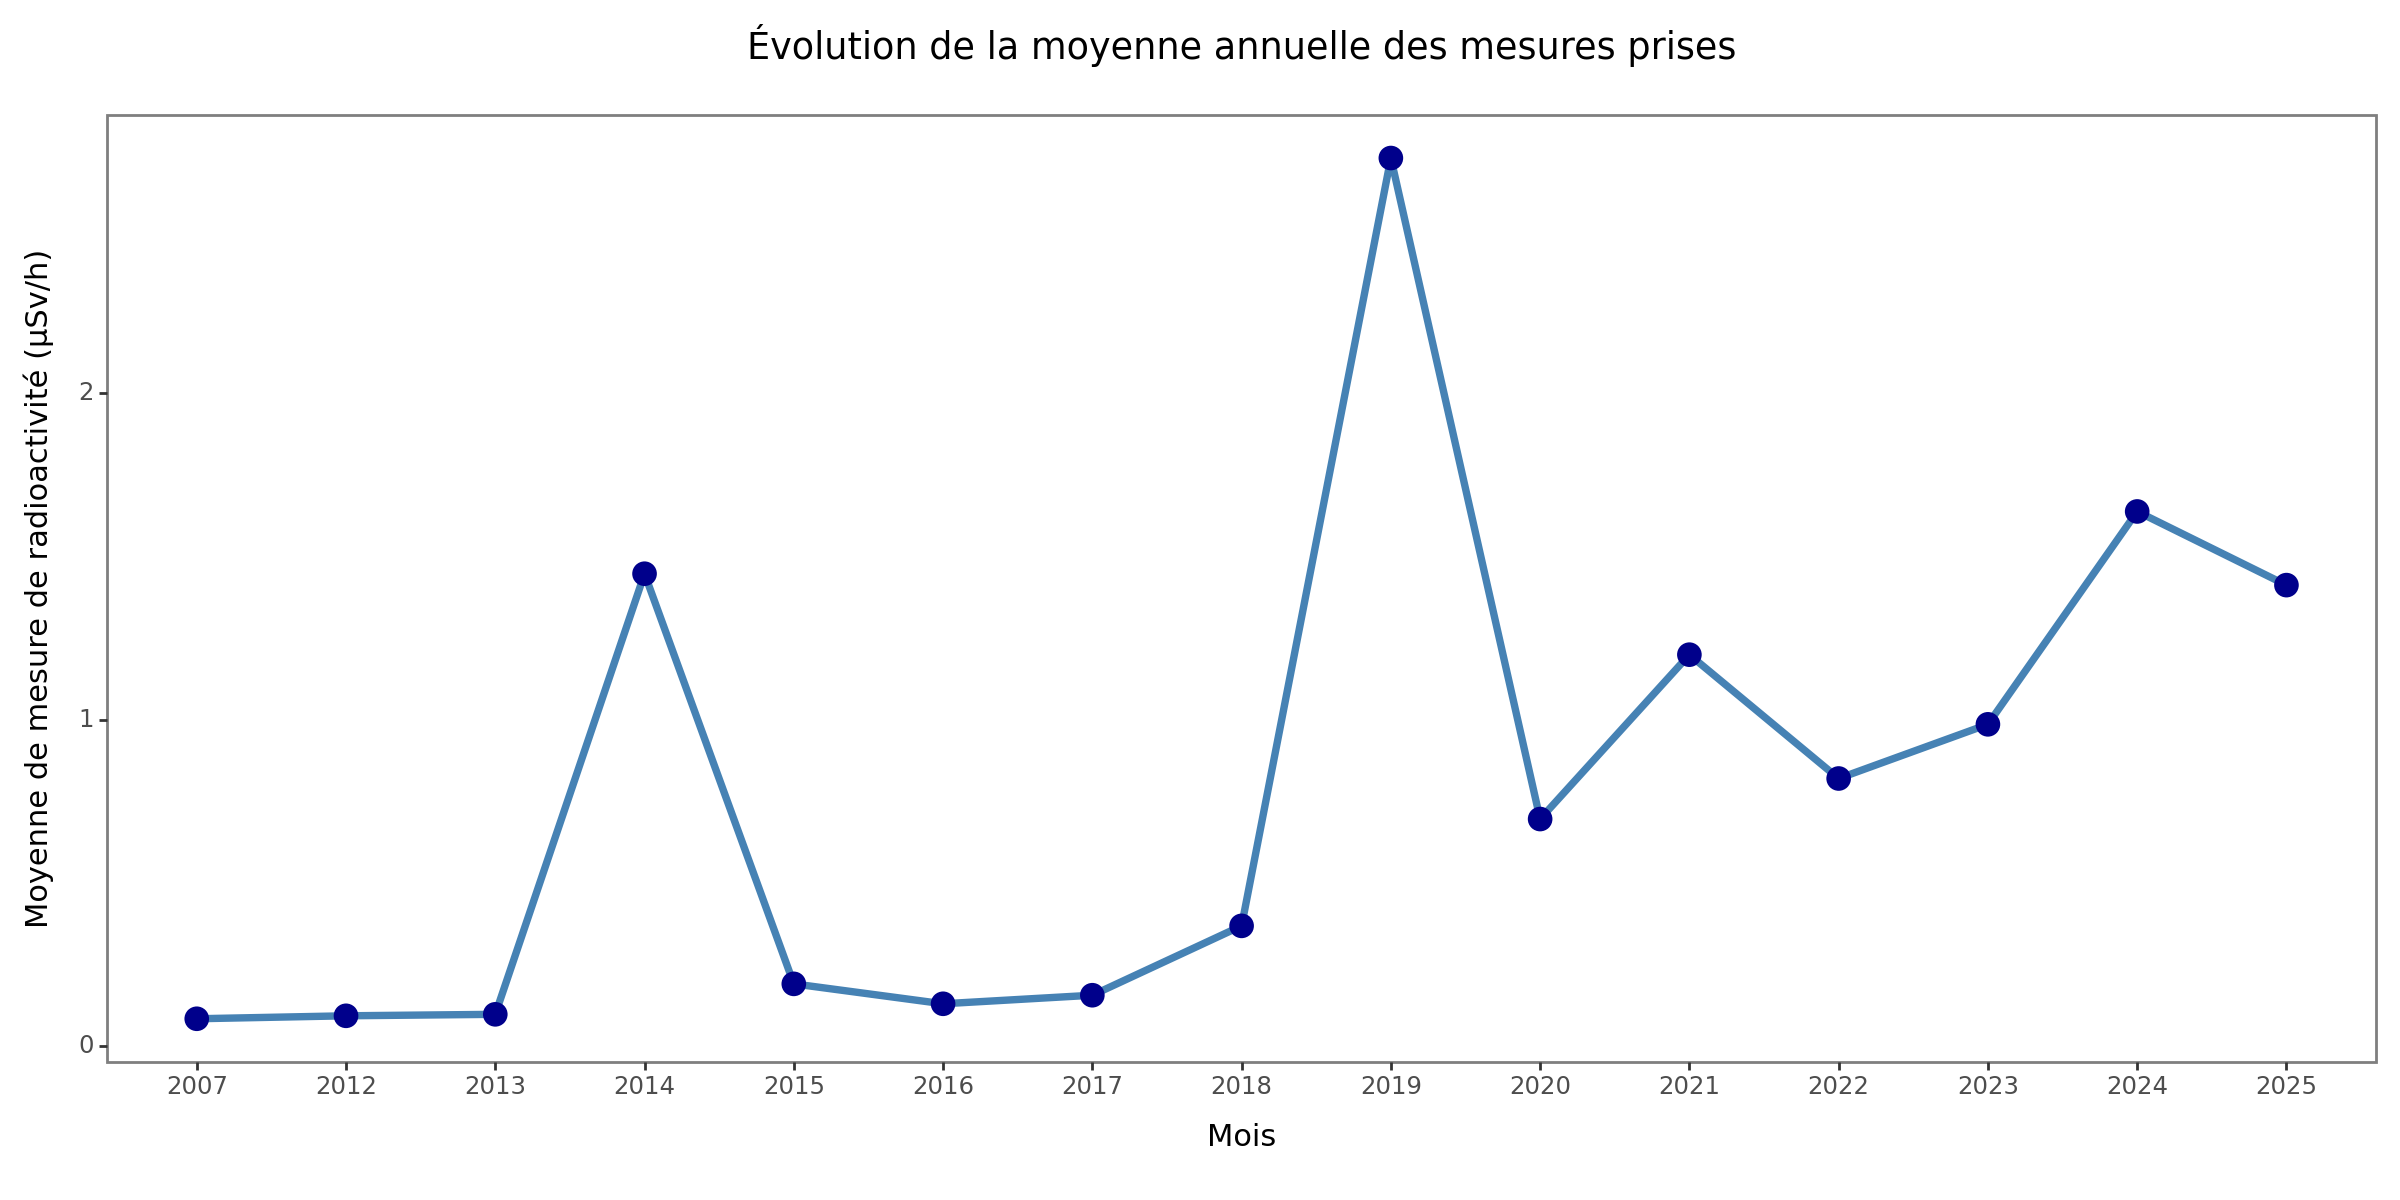

<Figure Size: (1200 x 600)>

In [132]:
# Courbe sur la moyenne des mesures par mois
(
    plt.ggplot(moyenne_mesure, plt.aes(x="ann_fin", y="value", group=1))
    + plt.geom_line(color="steelblue", size=1.5)
    + plt.geom_point(color="darkblue", size=4)
    + plt.labs(
        title="Évolution de la moyenne annuelle des mesures prises",
        x="Mois",
        y="Moyenne de mesure de radioactivité (µSv/h)"
    )
    + plt.theme_bw()
    + plt.theme(
        figure_size=(12, 6),
        plot_title=plt.element_text(ha='center'),
        panel_grid=plt.element_blank()
    )
)

#### Commentaire :
- Deux pics au niveau de la radioactivité pour 2014 et 2019. L'un dépasse plus d'1 µSv/h.
- Augmentation du niveau de radioactivité au cours des années. Cela peut-être dû qu'il y a de plus en plus de mesures prises chaque année.

In [133]:
# Agréger les données par année et par mois en calculant la moyenne de la mesure de radioactivité
df_moyennes = (
    open_radiation_mesure
    .groupby(['ann_fin', 'mois_fin'])['value']
    .mean()
    .reset_index()
)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\2191491034.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [134]:
df_moyennes

,ann_fin,mois_fin,value
0,1970,1,NaN
1,1970,2,NaN
2,1970,3,NaN
3,1970,4,NaN
4,1970,5,NaN
...,...,...,...
211,2025,8,NaN
212,2025,9,NaN
213,2025,10,NaN
214,2025,11,NaN


In [135]:
# Enlever les années manquant de mesures par mois 
df_moyennes = df_moyennes[~df_moyennes["ann_fin"].isin([1970, 2000, 1982, 2025, 
                                          2012, 2013, 2014, 2015, 
                                          2016, 2017])]
df_moyennes

,ann_fin,mois_fin,value
36,2007,1,NaN
37,2007,2,NaN
38,2007,3,NaN
39,2007,4,NaN
40,2007,5,NaN
...,...,...,...
199,2024,8,0.461062
200,2024,9,0.199377
201,2024,10,1.185813
202,2024,11,2.505348


In [136]:
# Enlever les modalités inutilisées
df_moyennes["ann_fin"] = df_moyennes["ann_fin"].cat.remove_unused_categories()

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\1903637814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [137]:
# Observation de 2018 à 2024 les mesures de radioactivité
df_moyennes["ann_fin"].unique()

[2007, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Categories (8, int32): [2007, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

d:\Divers\Annee2024\Mix_sujet\OpenRadiation\envRadio\lib\site-packages\plotnine\geoms\geom_path.py:98: PlotnineWarning: geom_path: Removed 9 rows containing missing values.
d:\Divers\Annee2024\Mix_sujet\OpenRadiation\envRadio\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 11 rows containing missing values.


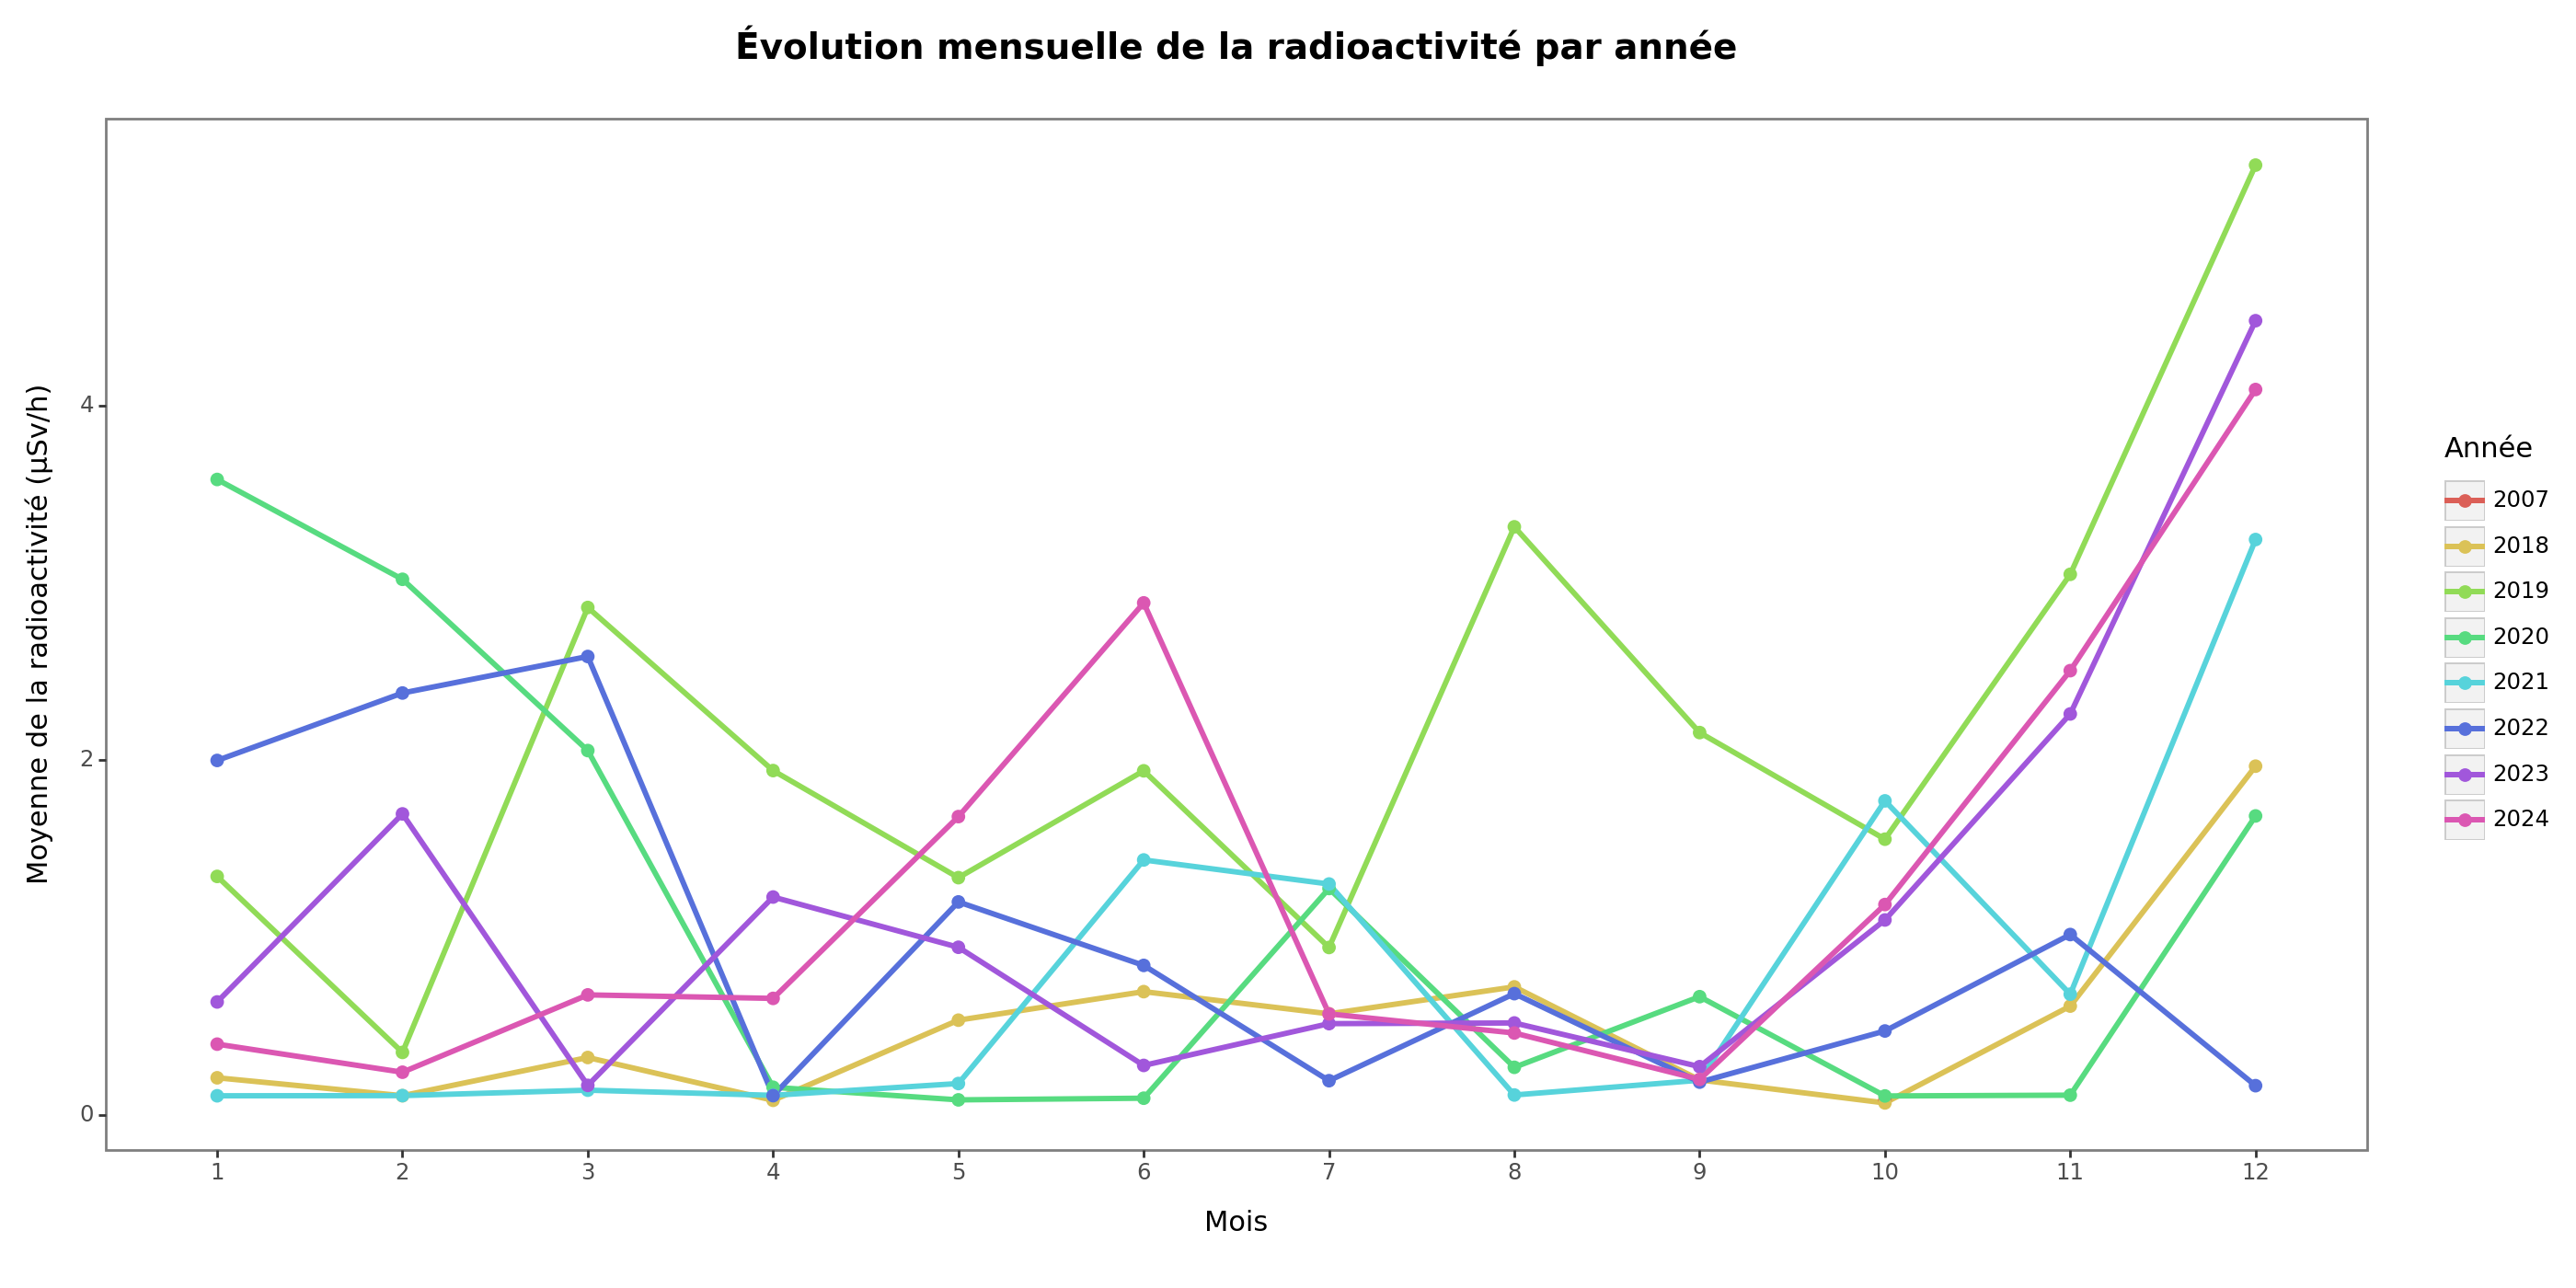

<Figure Size: (1400 x 700)>

In [138]:
# Visuel graphique
(
    plt.ggplot(df_moyennes, plt.aes(x='mois_fin', y='value', color='factor(ann_fin)', group='ann_fin'))
    + plt.geom_line(size=1.2)
    + plt.geom_point(size=2)
    + plt.labs(
        title="Évolution mensuelle de la radioactivité par année",
        x="Mois",
        y="Moyenne de la radioactivité (µSv/h)",
        color="Année"
    )
    + plt.theme_bw()
    + plt.theme(
        figure_size=(14, 7),
        plot_title=plt.element_text(ha='center', size=14, weight='bold'),
        panel_grid=plt.element_blank()
    )
)

In [139]:
open_radiation_mesure.dtypes

apparatusSensorType              category
value                             float64
hitsNumber                        float64
startTime                  datetime64[ns]
endTime                    datetime64[ns]
latitude                          float64
longitude                         float64
altitude                          float64
reportUuid                         object
measurementHeight                 float64
measurementEnvironment           category
qualification                    category
reliability                         int64
atypical                         category
dure                      timedelta64[ns]
dure_min_float                    float64
jour_ann_fin                     category
mois_fin                         category
ann_fin                          category
trim_fin                         category
sem_fin                          category
jour_sem_fin                     category
intervalle_mesure                category
dtype: object

### Carte interactive sur les mesures de radioactivités prises dans le monde

- Premièrement, sous plotnine avec une carte toute simple représentant la moyenne de la zone de radioactivité en France (selon les départements)
- Deuxièmement, sous Folium à la mise en place d'une carte interactive regardant les différentes mesures obtenus sur les emplacements

#### Sous plotnine

In [140]:
# Etape 1 : Charger le fond de carte des régions françaises (source : https://france-geojson.gregoiredavid.fr)
import geopandas as gpd

# Pour les régions françaises
gdf_regions = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/regions.geojson")
regions_outre_mer = ["Guadeloupe", "Martinique", "Guyane", "La Réunion", "Mayotte"] # Régions à exclure

# Filtrer uniquement les régions de la métropole
gdf_regions = gdf_regions[~gdf_regions["nom"].isin(regions_outre_mer)].copy()

In [141]:
# Vérification du succès de l'opération
gdf_regions

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."
5,44,Grand Est,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ..."
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.30479 46.70942, -2.28612 46..."
7,53,Bretagne,"MULTIPOLYGON (((-2.12371 48.60441, -2.13448 48..."
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((-1.02574 45.57469, -0.993 45.5..."
14,76,Occitanie,"MULTIPOLYGON (((1.78613 42.57362, 1.78094 42.5..."


In [142]:
# Etape 2 : Création d'une GéoDataFrame à partir de tes données de mesure

# Copie du DataFrame
open_radiation_geo = open_radiation_mesure.copy()

open_radiation_geo = gpd.GeoDataFrame(
    open_radiation_geo,
    geometry=gpd.points_from_xy(open_radiation_geo["longitude"], open_radiation_geo["latitude"])
)

In [143]:
# Vérification du succès de l'opération
open_radiation_geo

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,...,dure,dure_min_float,jour_ann_fin,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin,intervalle_mesure,geometry
0,geiger,0.111353,255.0,2025-07-22 04:53:06,2025-07-22 05:03:06,50.672861,3.204542,42.0,0fbe593e-3e9e-910a-f7c6-b1fe530ec6fe,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
1,geiger,0.106787,248.0,2025-07-22 04:43:05,2025-07-22 04:53:05,50.672861,3.204542,42.0,73a09d2c-56b4-d9af-58a2-8de649cb1b1f,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
2,geiger,0.105482,246.0,2025-07-22 04:33:05,2025-07-22 04:43:05,50.672861,3.204542,42.0,03de25e5-a5b2-69fe-11af-cd725936b408,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
3,geiger,0.115920,262.0,2025-07-22 04:23:04,2025-07-22 04:33:04,50.672861,3.204542,42.0,83d16655-556a-b2e3-17bf-77a831d02eed,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
4,geiger,0.099613,237.0,2025-07-22 04:13:04,2025-07-22 04:23:04,50.672861,3.204542,42.0,09494c5b-aa79-9d65-e5b8-89bb532024a0,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006972,geiger,0.108136,1.0,2000-01-01 21:20:31,2000-01-01 21:20:36,45.861239,1.271641,366.0,d5706739-17b0-4d38-bead-b7c910e7dcb6,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124)
1006973,geiger,0.216272,2.0,2000-01-01 21:20:26,2000-01-01 21:20:31,45.861239,1.271641,366.0,56722c45-3a60-4ac3-a5e4-da1bef4c00e2,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,200 et plus",POINT (1.27164 45.86124)
1006974,geiger,0.108136,1.0,2000-01-01 21:20:21,2000-01-01 21:20:26,45.861239,1.271641,366.0,c301b210-a47a-4f7c-9f20-24904ca81e7a,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124)
1006976,geiger,0.102000,34.0,1982-04-01 13:50:45,1982-04-01 13:51:50,48.482210,2.192795,58.0,fffbcc5d-c812-4f65-a8a1-570386517045,1.0,...,0 days 00:01:05,1.083333,91,4,1982,2,13,3,"0,080-0,120",POINT (2.1928 48.48221)


In [144]:
# Etape 3 : Filtrer uniquement les points situés en France
open_radiation_geo = open_radiation_geo[open_radiation_geo.within(gdf_regions.unary_union)]

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\1979342303.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


In [145]:
open_radiation_geo

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,...,dure,dure_min_float,jour_ann_fin,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin,intervalle_mesure,geometry
0,geiger,0.111353,255.0,2025-07-22 04:53:06,2025-07-22 05:03:06,50.672861,3.204542,42.0,0fbe593e-3e9e-910a-f7c6-b1fe530ec6fe,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
1,geiger,0.106787,248.0,2025-07-22 04:43:05,2025-07-22 04:53:05,50.672861,3.204542,42.0,73a09d2c-56b4-d9af-58a2-8de649cb1b1f,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
2,geiger,0.105482,246.0,2025-07-22 04:33:05,2025-07-22 04:43:05,50.672861,3.204542,42.0,03de25e5-a5b2-69fe-11af-cd725936b408,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
3,geiger,0.115920,262.0,2025-07-22 04:23:04,2025-07-22 04:33:04,50.672861,3.204542,42.0,83d16655-556a-b2e3-17bf-77a831d02eed,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
4,geiger,0.099613,237.0,2025-07-22 04:13:04,2025-07-22 04:23:04,50.672861,3.204542,42.0,09494c5b-aa79-9d65-e5b8-89bb532024a0,1.0,...,0 days 00:10:00,10.000000,203,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006972,geiger,0.108136,1.0,2000-01-01 21:20:31,2000-01-01 21:20:36,45.861239,1.271641,366.0,d5706739-17b0-4d38-bead-b7c910e7dcb6,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124)
1006973,geiger,0.216272,2.0,2000-01-01 21:20:26,2000-01-01 21:20:31,45.861239,1.271641,366.0,56722c45-3a60-4ac3-a5e4-da1bef4c00e2,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,200 et plus",POINT (1.27164 45.86124)
1006974,geiger,0.108136,1.0,2000-01-01 21:20:21,2000-01-01 21:20:26,45.861239,1.271641,366.0,c301b210-a47a-4f7c-9f20-24904ca81e7a,0.0,...,0 days 00:00:05,0.083333,1,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124)
1006976,geiger,0.102000,34.0,1982-04-01 13:50:45,1982-04-01 13:51:50,48.482210,2.192795,58.0,fffbcc5d-c812-4f65-a8a1-570386517045,1.0,...,0 days 00:01:05,1.083333,91,4,1982,2,13,3,"0,080-0,120",POINT (2.1928 48.48221)


In [146]:
# Etape 4 : Joindre chaque point à sa région
open_radiation_geo_fr = gpd.sjoin(open_radiation_geo, gdf_regions, how='left', predicate='within')

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\257095642.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326



In [147]:
open_radiation_geo_fr

,apparatusSensorType,value,hitsNumber,startTime,endTime,latitude,longitude,altitude,reportUuid,measurementHeight,...,mois_fin,ann_fin,trim_fin,sem_fin,jour_sem_fin,intervalle_mesure,geometry,index_right,code,nom
0,geiger,0.111353,255.0,2025-07-22 04:53:06,2025-07-22 05:03:06,50.672861,3.204542,42.0,0fbe593e-3e9e-910a-f7c6-b1fe530ec6fe,1.0,...,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286),4,32,Hauts-de-France
1,geiger,0.106787,248.0,2025-07-22 04:43:05,2025-07-22 04:53:05,50.672861,3.204542,42.0,73a09d2c-56b4-d9af-58a2-8de649cb1b1f,1.0,...,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286),4,32,Hauts-de-France
2,geiger,0.105482,246.0,2025-07-22 04:33:05,2025-07-22 04:43:05,50.672861,3.204542,42.0,03de25e5-a5b2-69fe-11af-cd725936b408,1.0,...,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286),4,32,Hauts-de-France
3,geiger,0.115920,262.0,2025-07-22 04:23:04,2025-07-22 04:33:04,50.672861,3.204542,42.0,83d16655-556a-b2e3-17bf-77a831d02eed,1.0,...,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286),4,32,Hauts-de-France
4,geiger,0.099613,237.0,2025-07-22 04:13:04,2025-07-22 04:23:04,50.672861,3.204542,42.0,09494c5b-aa79-9d65-e5b8-89bb532024a0,1.0,...,7,2025,3,30,1,"0,080-0,120",POINT (3.20454 50.67286),4,32,Hauts-de-France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006972,geiger,0.108136,1.0,2000-01-01 21:20:31,2000-01-01 21:20:36,45.861239,1.271641,366.0,d5706739-17b0-4d38-bead-b7c910e7dcb6,0.0,...,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124),8,75,Nouvelle-Aquitaine
1006973,geiger,0.216272,2.0,2000-01-01 21:20:26,2000-01-01 21:20:31,45.861239,1.271641,366.0,56722c45-3a60-4ac3-a5e4-da1bef4c00e2,0.0,...,1,2000,1,52,5,"0,200 et plus",POINT (1.27164 45.86124),8,75,Nouvelle-Aquitaine
1006974,geiger,0.108136,1.0,2000-01-01 21:20:21,2000-01-01 21:20:26,45.861239,1.271641,366.0,c301b210-a47a-4f7c-9f20-24904ca81e7a,0.0,...,1,2000,1,52,5,"0,080-0,120",POINT (1.27164 45.86124),8,75,Nouvelle-Aquitaine
1006976,geiger,0.102000,34.0,1982-04-01 13:50:45,1982-04-01 13:51:50,48.482210,2.192795,58.0,fffbcc5d-c812-4f65-a8a1-570386517045,1.0,...,4,1982,2,13,3,"0,080-0,120",POINT (2.1928 48.48221),0,11,Île-de-France


In [148]:
# Etape 5 : Calculer la moyenne des mesures obtenus par région
moyennes_region = (
    open_radiation_geo_fr.groupby("nom")["value"]
    .mean()
    .reset_index(name="moyenne_value")
)

In [149]:
moyennes_region

,nom,moyenne_value
0,Auvergne-Rhône-Alpes,0.384758
1,Bourgogne-Franche-Comté,0.210526
2,Bretagne,0.139890
3,Centre-Val de Loire,0.456633
4,Corse,0.153949
5,Grand Est,1.824952
6,Hauts-de-France,0.123003
7,Normandie,0.567458
8,Nouvelle-Aquitaine,0.302246
9,Occitanie,0.176343


In [150]:
# Etape 6 : fusion des moyennes avec les valeurs spatiaux pour la réalisation de la carte
gdf_regions_tout = gdf_regions.merge(moyennes_region, on="nom", how="left")

In [151]:
gdf_regions_tout

,code,nom,geometry,moyenne_value
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",0.777025
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ...",0.456633
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6...",0.210526
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,...",0.567458
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ...",0.123003
5,44,Grand Est,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ...",1.824952
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.30479 46.70942, -2.28612 46...",0.273539
7,53,Bretagne,"MULTIPOLYGON (((-2.12371 48.60441, -2.13448 48...",0.139890
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((-1.02574 45.57469, -0.993 45.5...",0.302246
9,76,Occitanie,"MULTIPOLYGON (((1.78613 42.57362, 1.78094 42.5...",0.176343


In [152]:
# Etape 7 : préparation pour plotnine (décomposer les multipolygones et extraction des longitude et latitude en x et y)

# Exploser les géométries (MultiPolygon -> Polygon)
gdf_exploded = gdf_regions_tout.explode(index_parts=True).reset_index()

# Extraire les coordonnées de chaque polygone
rows = []
for _, row in gdf_exploded.iterrows():
    geom = row.geometry
    if geom and geom.geom_type == "Polygon":
        xs, ys = geom.exterior.coords.xy
        for x, y in zip(xs, ys):
            rows.append({
                "region": row["nom"],  # ou autre nom de colonne de la région
                "x": x,
                "y": y,
                "moyenne_value": row["moyenne_value"]
            })

# Créer le DataFrame final pour plotnine
df_plot = pd.DataFrame(rows)


In [153]:
df_plot

,region,x,y,moyenne_value
0,Île-de-France,1.922146,48.457599,0.777025
1,Île-de-France,1.920738,48.447750,0.777025
2,Île-de-France,1.906555,48.445672,0.777025
3,Île-de-France,1.906408,48.440147,0.777025
4,Île-de-France,1.877489,48.440614,0.777025
...,...,...,...,...
12436,Corse,9.414998,41.925108,0.153949
12437,Corse,9.411248,41.911001,0.153949
12438,Corse,9.402064,41.897155,0.153949
12439,Corse,9.397019,41.874613,0.153949


In [154]:
df_plot.region.unique()

array(['Île-de-France', 'Centre-Val de Loire', 'Bourgogne-Franche-Comté',
       'Normandie', 'Hauts-de-France', 'Grand Est', 'Pays de la Loire',
       'Bretagne', 'Nouvelle-Aquitaine', 'Occitanie',
       'Auvergne-Rhône-Alpes', "Provence-Alpes-Côte d'Azur", 'Corse'],
      dtype=object)

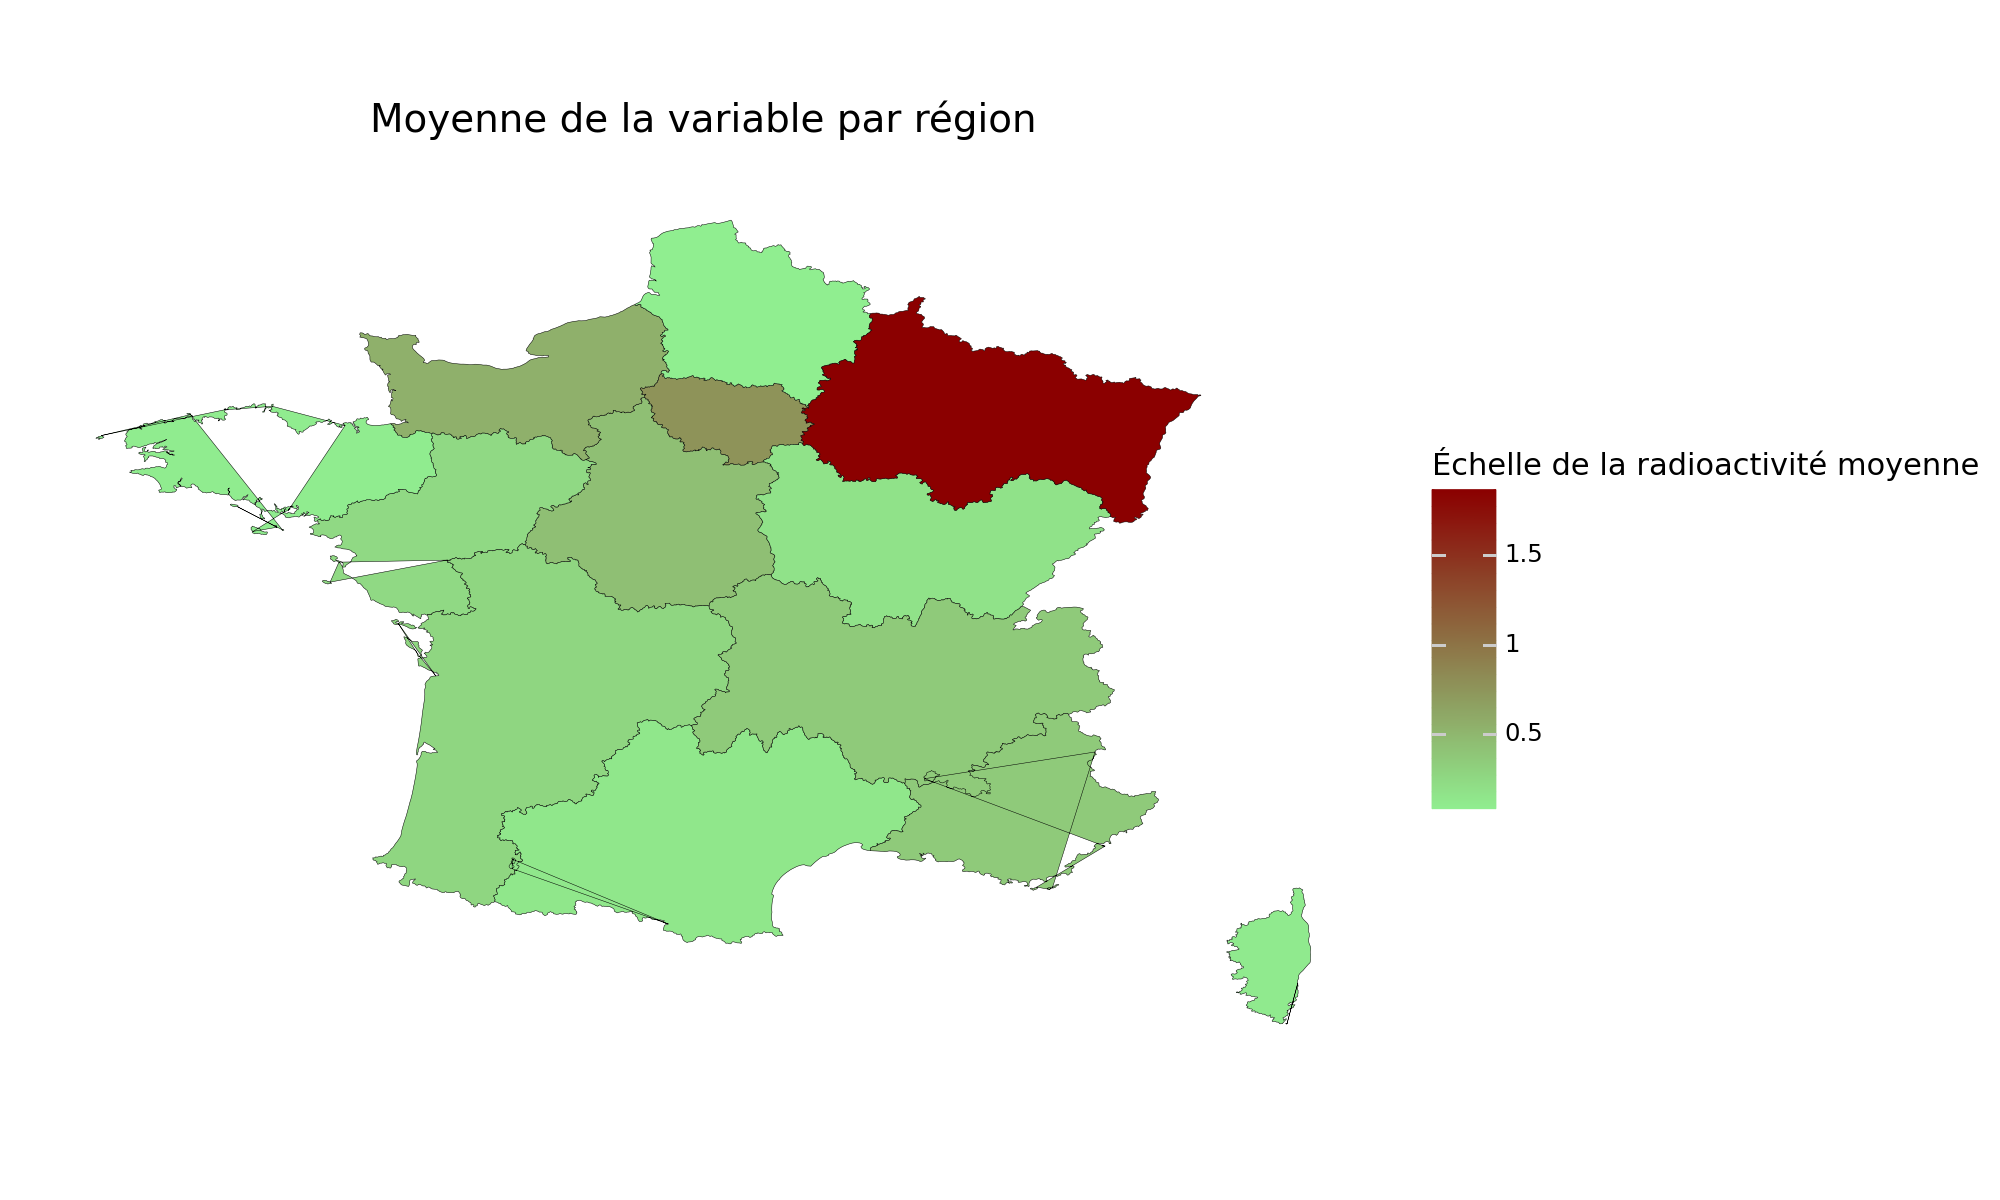

<Figure Size: (1000 x 600)>

In [155]:
# Etape 8 : Tracer la carte de la France avec les valeurs moyennes
(
    plt.ggplot(df_plot, plt.aes(x="x", y="y", group="region", fill="moyenne_value"))
    + plt.geom_polygon(color="black", size=0.1)
    + plt.coord_equal()
    + plt.scale_fill_gradient(name="Échelle de la radioactivité moyenne", low="lightgreen", high="darkred", na_value="lightgrey")
    + plt.labs(title="Moyenne de la variable par région")
    + plt.theme_bw()
    + plt.theme(
        figure_size=(10, 6),
        plot_title=plt.element_text(ha='center', size=14),
        axis_title_x=plt.element_blank(),
        axis_title_y=plt.element_blank(),
        axis_text_x=plt.element_blank(),
        axis_text_y=plt.element_blank(),
        axis_ticks_major=plt.element_blank(),
        axis_ticks_minor=plt.element_blank(),
        panel_grid_major=plt.element_blank(),
        panel_grid_minor=plt.element_blank(),
        panel_border=plt.element_blank()
    )
)

In [156]:
# Création d'une carte par année pour observer l'évolution des mesures
# Etape 1 : calculer la moyenne par année des mesures de radioactivités dans les différentes régions
moyennes_region = (
    open_radiation_geo_fr.groupby(["nom", "ann_fin"])["value"]
    .mean()
    .reset_index(name="moyenne_value")
)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\3907851178.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [157]:
moyennes_region

,nom,ann_fin,moyenne_value
0,Auvergne-Rhône-Alpes,1970,NaN
1,Auvergne-Rhône-Alpes,1982,NaN
2,Auvergne-Rhône-Alpes,2000,NaN
3,Auvergne-Rhône-Alpes,2007,NaN
4,Auvergne-Rhône-Alpes,2012,NaN
...,...,...,...
229,Île-de-France,2021,1.820681
230,Île-de-France,2022,0.603961
231,Île-de-France,2023,0.840504
232,Île-de-France,2024,1.112052


In [158]:
# Fusion des moyennes avec les valeurs spatiaux pour la réalisation de la carte
gdf_regions_annee = gdf_regions.merge(moyennes_region, on="nom", how="left")

In [159]:
gdf_regions_annee

,code,nom,geometry,ann_fin,moyenne_value
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",1970,NaN
1,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",1982,0.100500
2,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",2000,NaN
3,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",2007,0.084000
4,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1...",2012,NaN
...,...,...,...,...,...
229,94,Corse,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36...",2021,0.181979
230,94,Corse,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36...",2022,0.146901
231,94,Corse,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36...",2023,NaN
232,94,Corse,"MULTIPOLYGON (((9.27103 41.36496, 9.2657 41.36...",2024,0.224480


In [160]:
# Exploser les géométries (MultiPolygon -> Polygon)
gdf_exploded = gdf_regions_annee.explode(index_parts=True).reset_index()

# Extraire les coordonnées de chaque polygone
rows = []
for _, row in gdf_exploded.iterrows():
    geom = row.geometry
    if geom and geom.geom_type == "Polygon":
        xs, ys = geom.exterior.coords.xy
        for x, y in zip(xs, ys):
            rows.append({
                "region": row["nom"],  # ou autre nom de colonne de la région
                "x": x,
                "y": y,
                "ann_fin" : row["ann_fin"],
                "moyenne_value": row["moyenne_value"]
            })

# Créer le DataFrame final pour plotnine
df_plot_ann = pd.DataFrame(rows)


In [161]:
# Vérification du succès de l'opération
df_plot_ann

,region,x,y,ann_fin,moyenne_value
0,Île-de-France,1.922146,48.457599,1970,NaN
1,Île-de-France,1.920738,48.447750,1970,NaN
2,Île-de-France,1.906555,48.445672,1970,NaN
3,Île-de-France,1.906408,48.440147,1970,NaN
4,Île-de-France,1.877489,48.440614,1970,NaN
...,...,...,...,...,...
223933,Corse,9.414998,41.925108,2025,0.142037
223934,Corse,9.411248,41.911001,2025,0.142037
223935,Corse,9.402064,41.897155,2025,0.142037
223936,Corse,9.397019,41.874613,2025,0.142037


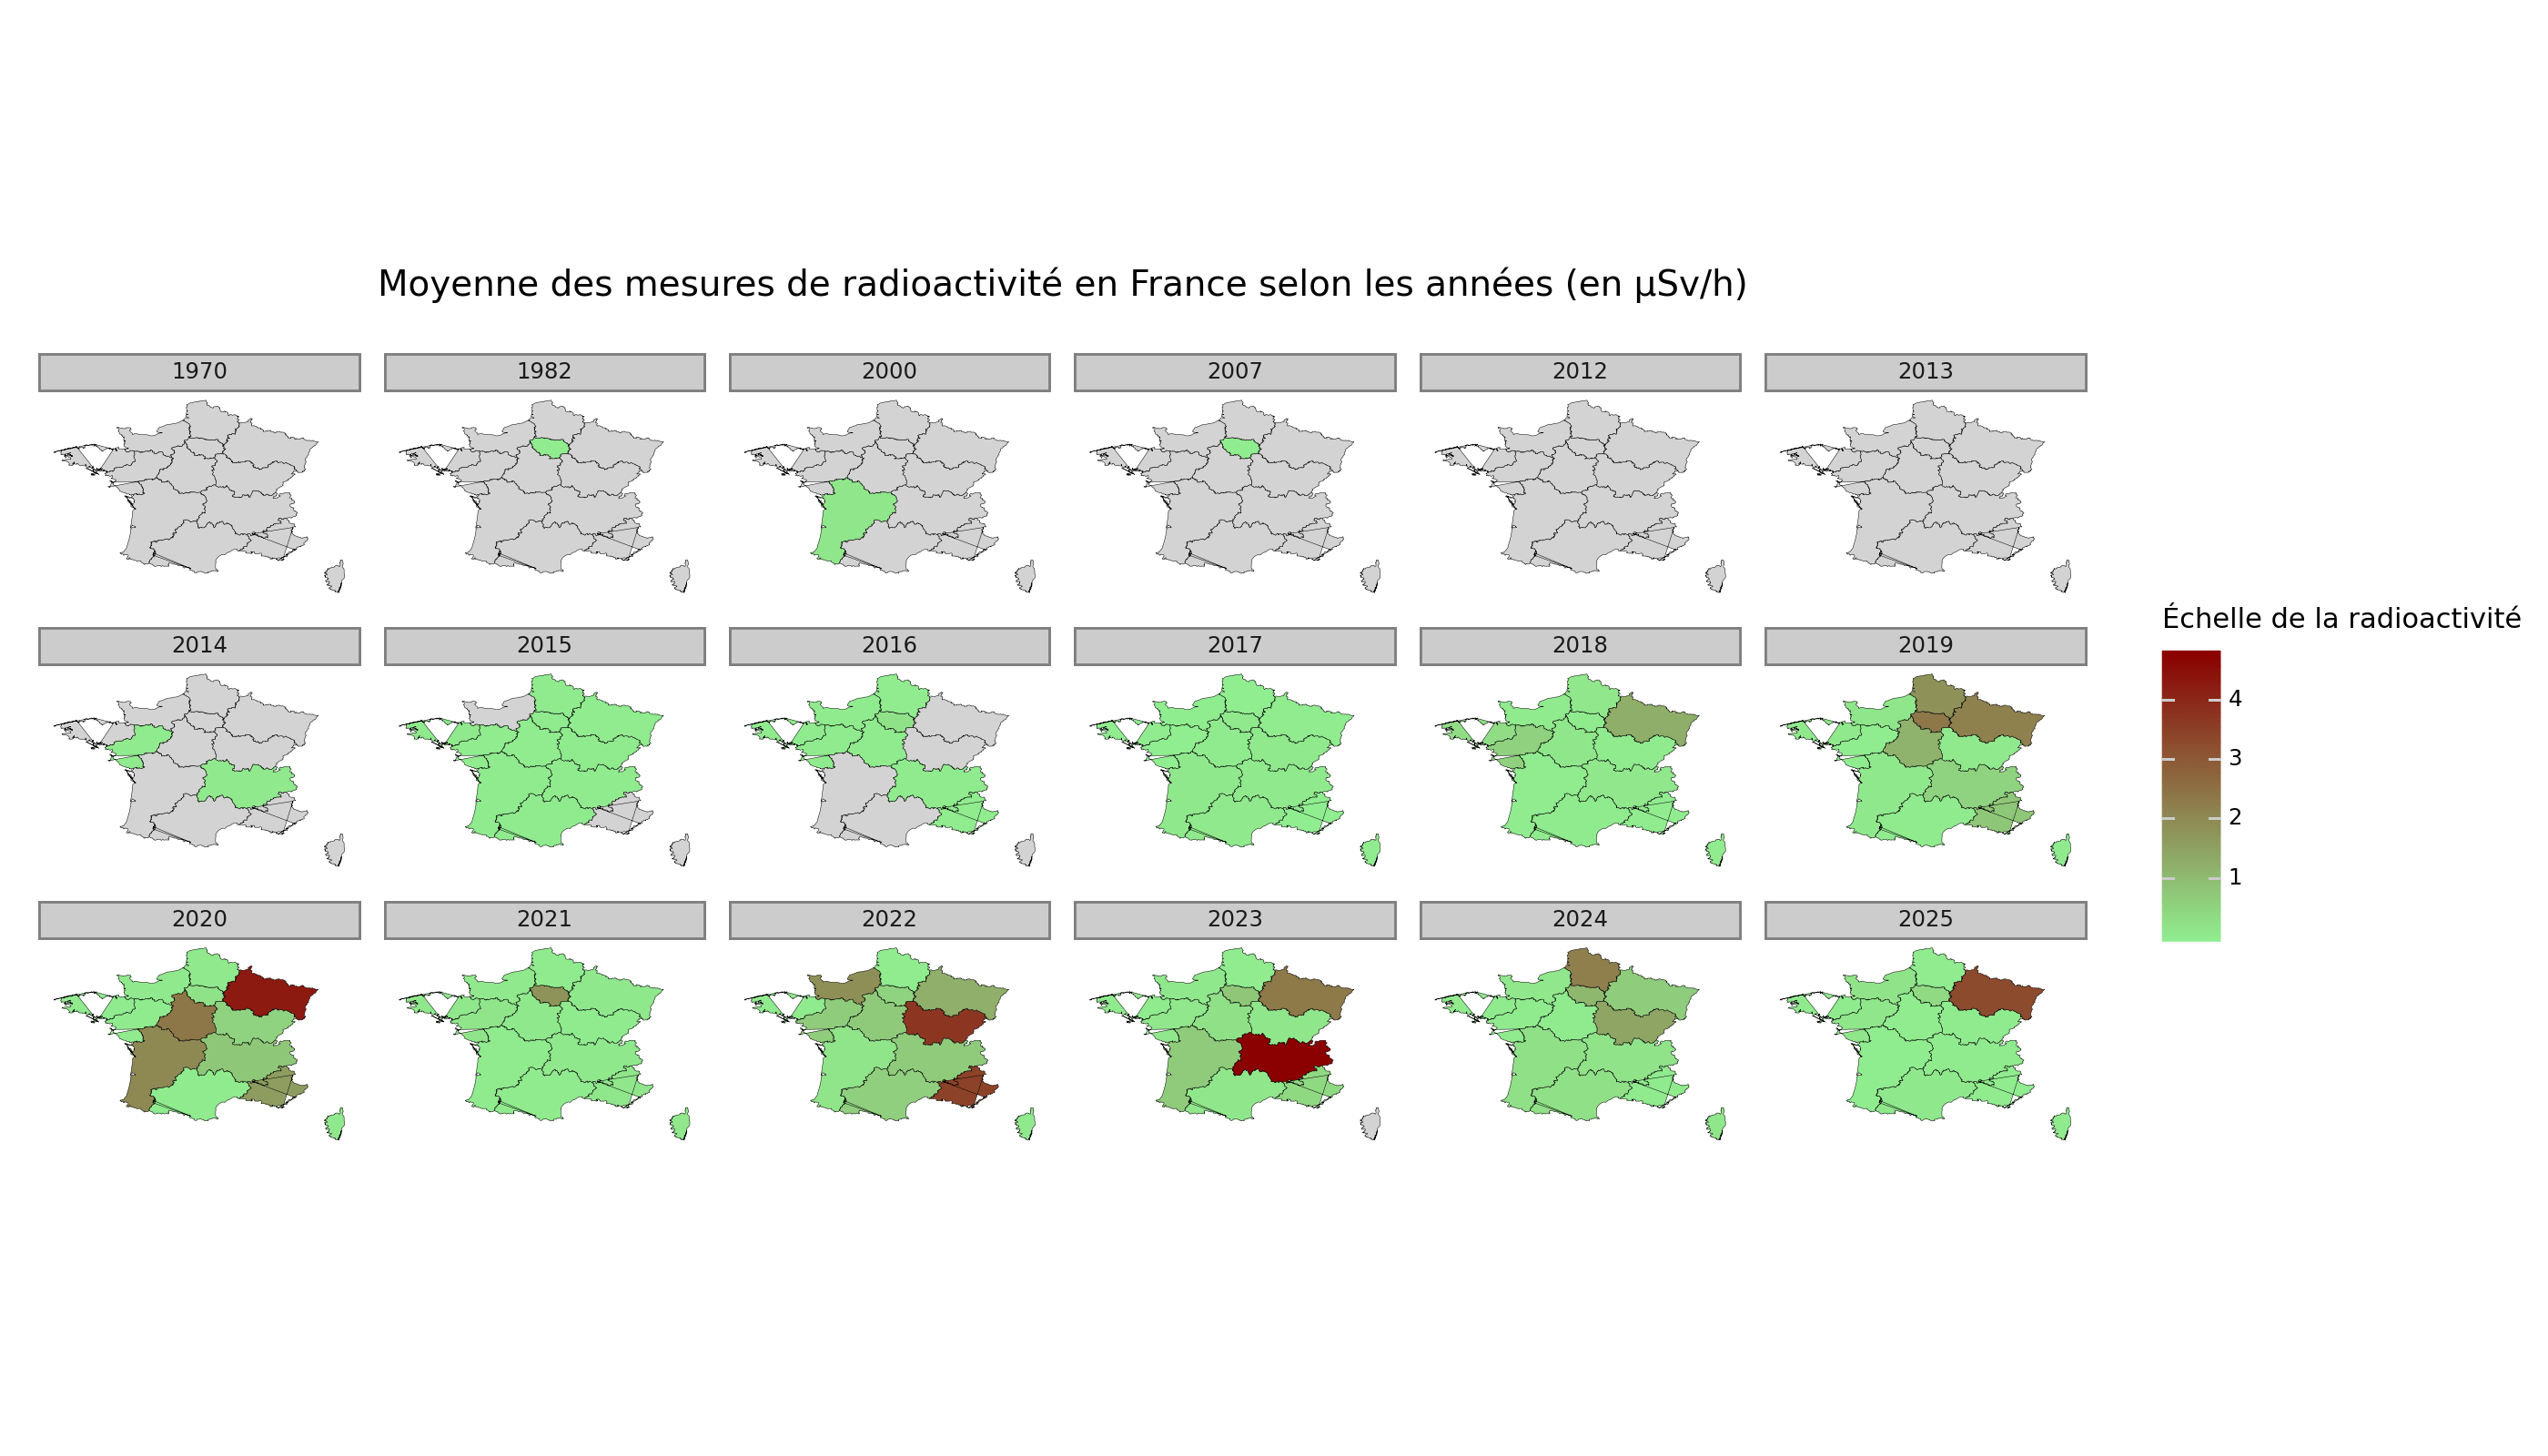

<Figure Size: (1400 x 800)>

In [162]:
# Visuel graphique final
(
    plt.ggplot(df_plot_ann, plt.aes(x="x", y="y", group="region", fill="moyenne_value"))
    + plt.geom_polygon(color="black", size=0.1)
    + plt.coord_equal()
    + plt.scale_fill_gradient(name="Échelle de la radioactivité", low="lightgreen", high="darkred", na_value="lightgrey")
    + plt.labs(title="Moyenne des mesures de radioactivité en France selon les années (en µSv/h)")
    + plt.theme_bw()
    + plt.theme(
        figure_size=(14, 8),
        plot_title=plt.element_text(ha='center', size=14),
        axis_title_x=plt.element_blank(),
        axis_title_y=plt.element_blank(),
        axis_text_x=plt.element_blank(),
        axis_text_y=plt.element_blank(),
        axis_ticks_major=plt.element_blank(),
        axis_ticks_minor=plt.element_blank(),
        panel_grid_major=plt.element_blank(),
        panel_grid_minor=plt.element_blank(),
        panel_border=plt.element_blank()
    )
    + plt.facet_wrap("~ann_fin", ncol=6)
)

#### Sous Folium (en carte interactive)

In [163]:
# Charger les régions françaises (métropole et outre-mer)
url = "https://france-geojson.gregoiredavid.fr/repo/regions.geojson"
gdf_regions = gpd.read_file(url)

In [164]:
gdf_regions

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."
5,44,Grand Est,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ..."
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.30479 46.70942, -2.28612 46..."
7,53,Bretagne,"MULTIPOLYGON (((-2.12371 48.60441, -2.13448 48..."
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((-1.02574 45.57469, -0.993 45.5..."
9,01,Guadeloupe,"MULTIPOLYGON (((-61.63356 15.83977, -61.64798 ..."


In [165]:
moyennes = (
    open_radiation_geo_fr
    .groupby(['nom', 'ann_fin'])['value']
    .mean()
    .reset_index(name='moyenne_value')
)

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_12760\1065475280.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [166]:
moyennes

,nom,ann_fin,moyenne_value
0,Auvergne-Rhône-Alpes,1970,NaN
1,Auvergne-Rhône-Alpes,1982,NaN
2,Auvergne-Rhône-Alpes,2000,NaN
3,Auvergne-Rhône-Alpes,2007,NaN
4,Auvergne-Rhône-Alpes,2012,NaN
...,...,...,...
229,Île-de-France,2021,1.820681
230,Île-de-France,2022,0.603961
231,Île-de-France,2023,0.840504
232,Île-de-France,2024,1.112052


In [167]:
gdf_regions_all_years = gdf_regions.merge(moyennes_region, on='nom', how='left')

In [168]:
import folium
from folium import Choropleth

# 4. Créer la carte
m = folium.Map(location=[46.5, 2], zoom_start=6)

# Liste des années à visualiser
annees = sorted(gdf_regions_all_years["ann_fin"].dropna().unique())

# 5. Pour chaque année, ajouter une couche Choropleth
for annee in annees:
    gdf_annee = gdf_regions_all_years[gdf_regions_all_years["ann_fin"] == annee]
    
    # Choropleth attend un DataFrame séparé
    df_choro = gdf_annee[["nom", "moyenne_value"]].dropna()

    choropleth = Choropleth(
        geo_data=gdf_annee,
        name=str(annee),
        data=df_choro,
        columns=["nom", "moyenne_value"],
        key_on="feature.properties.nom",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.3,
        nan_fill_color="lightgrey",
        legend_name=f"Moyenne par région ({annee})",
        highlight=True,
        show=(annee == annees[0])  # Montrer seulement la première année au début
    )
    choropleth.add_to(m)

    # Ajouter des infobulles avec les noms de régions
    folium.GeoJsonTooltip(
        fields=["nom", "moyenne_value"],
        aliases=["Région", "Moyenne"],
        localize=True
    ).add_to(choropleth.geojson)

# 6. Ajout du sélecteur de couche
folium.LayerControl(collapsed=False).add_to(m)

In [169]:
# 7. Sauvegarder
m.save("carte_choropleth_par_annee.html")

In [170]:
annees

[1970,
 1982,
 2000,
 2007,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025]

## *Durée des mesures de radioactivité en minutes*

In [171]:
# Observation de la durée
open_radiation_mesure["dure_min_float"].describe()

count    1.003041e+06
mean     3.439697e+00
std      1.133464e+01
min      1.666667e-02
25%      1.000000e+00
50%      1.016667e+00
75%      3.699917e+00
max      1.439917e+03
Name: dure_min_float, dtype: float64

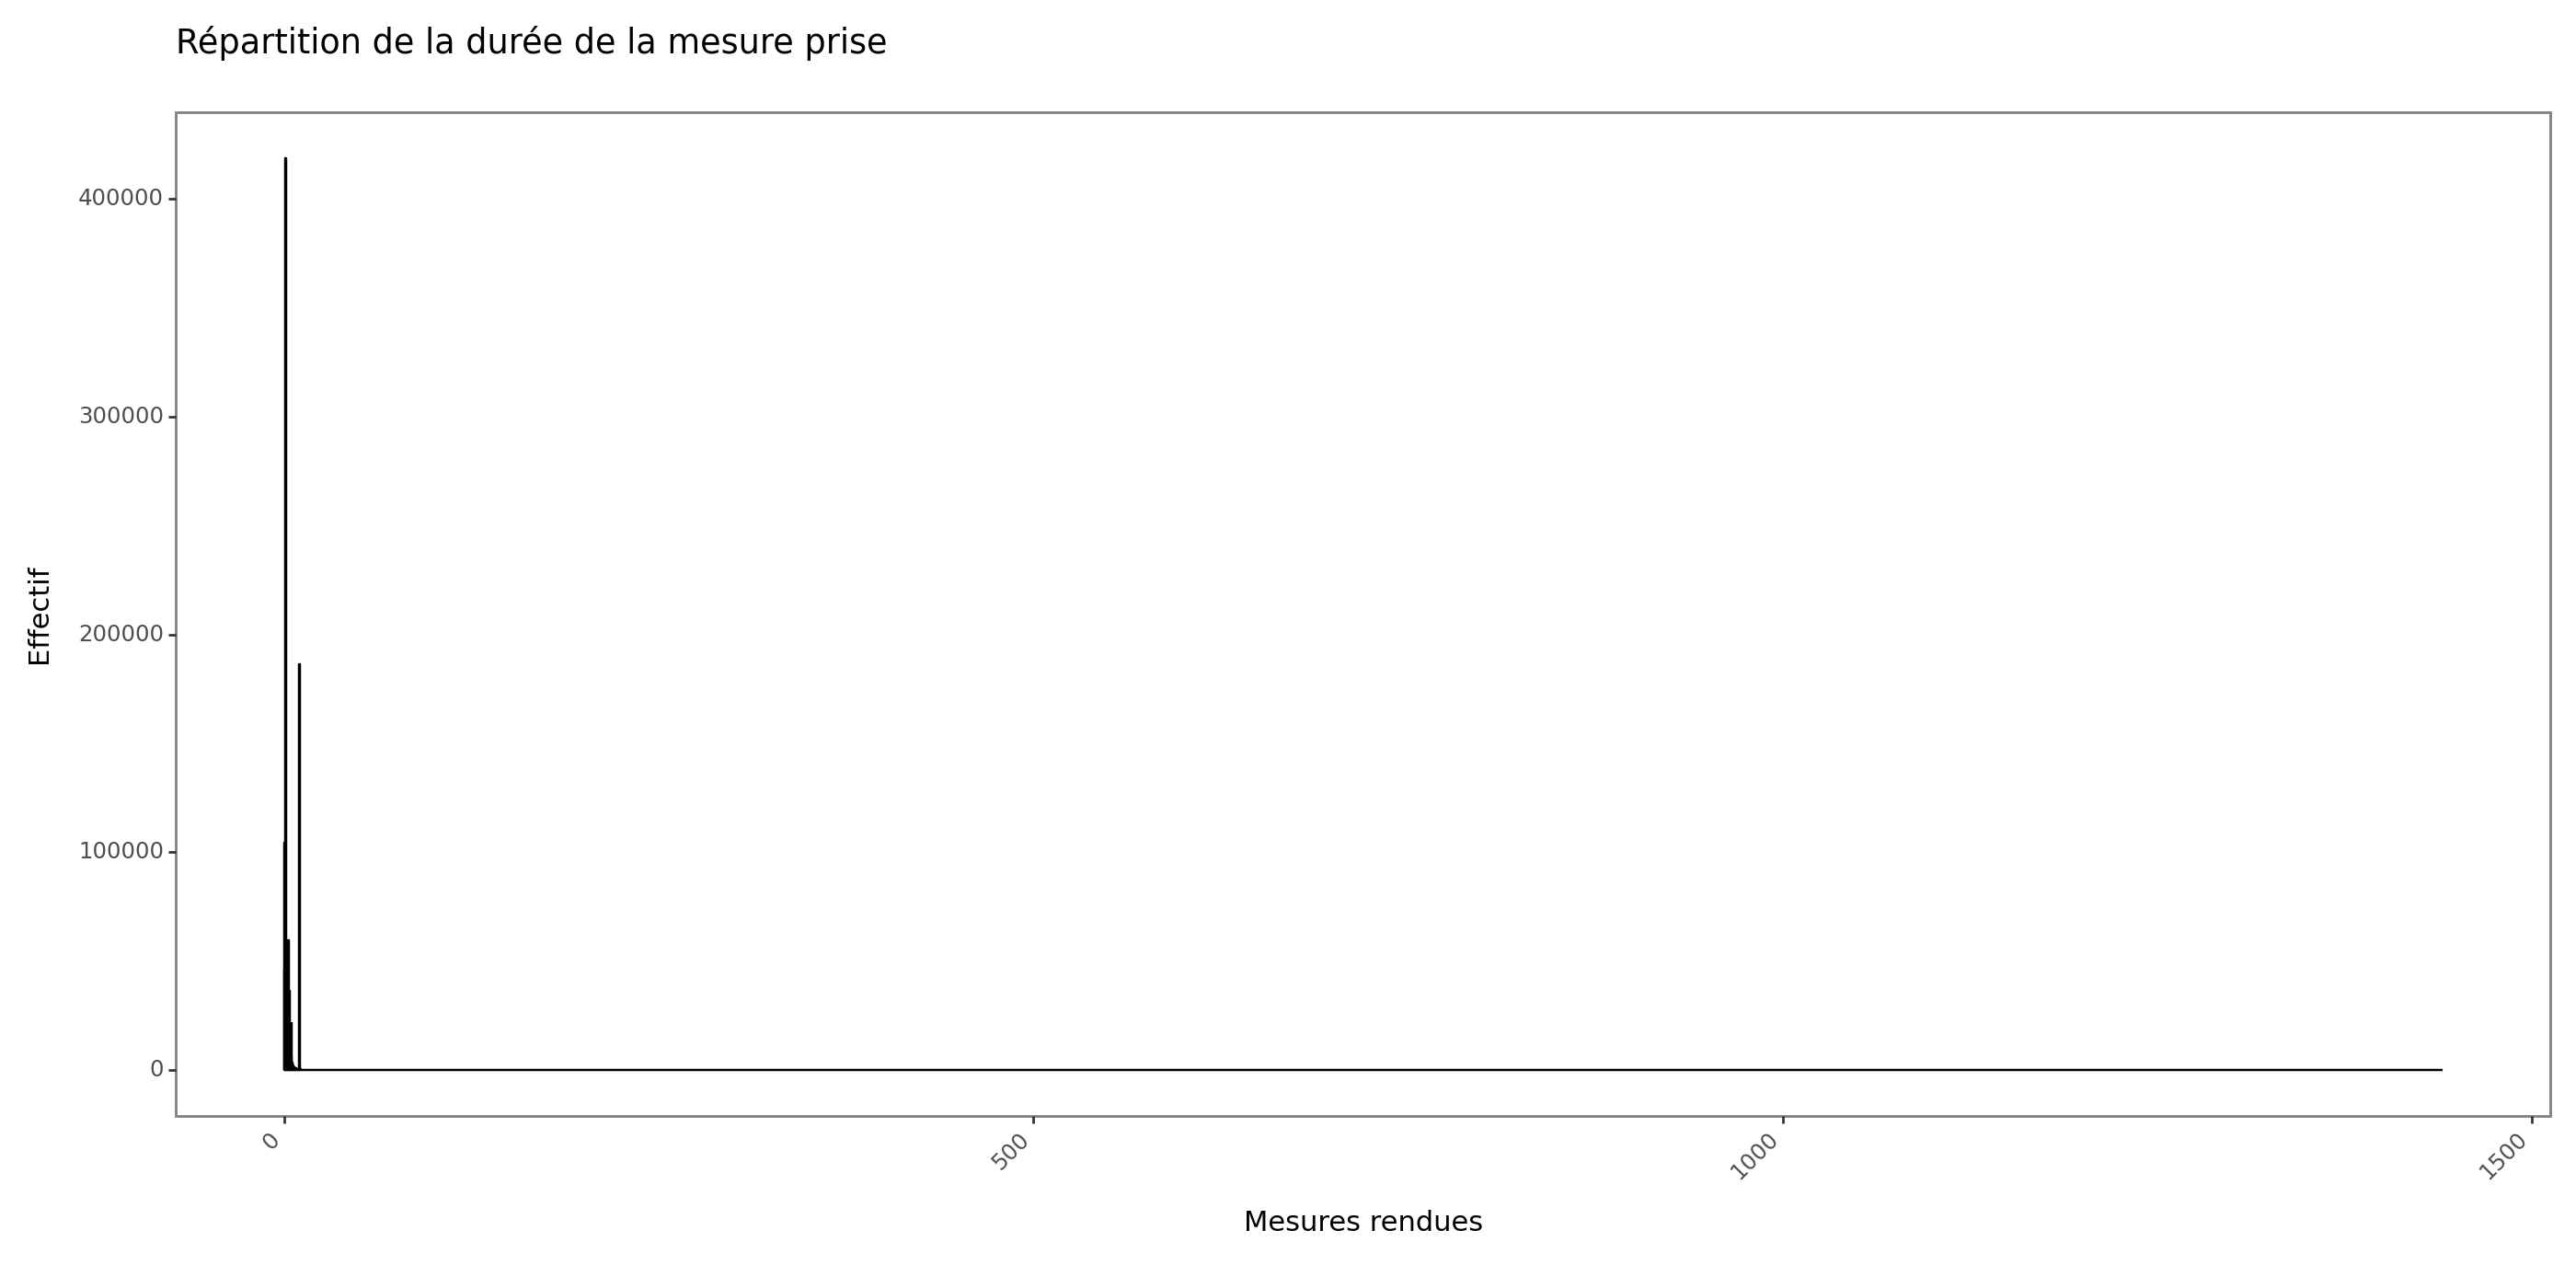

<Figure Size: (1400 x 700)>

In [172]:
# Voir sur un histogramme avec une échelle plus réduite
(
    plt.ggplot(open_radiation_mesure, plt.aes(x="dure_min_float"))
    + plt.geom_histogram(binwidth=0.5, color="black", fill="blue")
    + plt.labs(title="Répartition de la durée de la mesure prise",
               x = "Mesures rendues",
               y = "Effectif") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

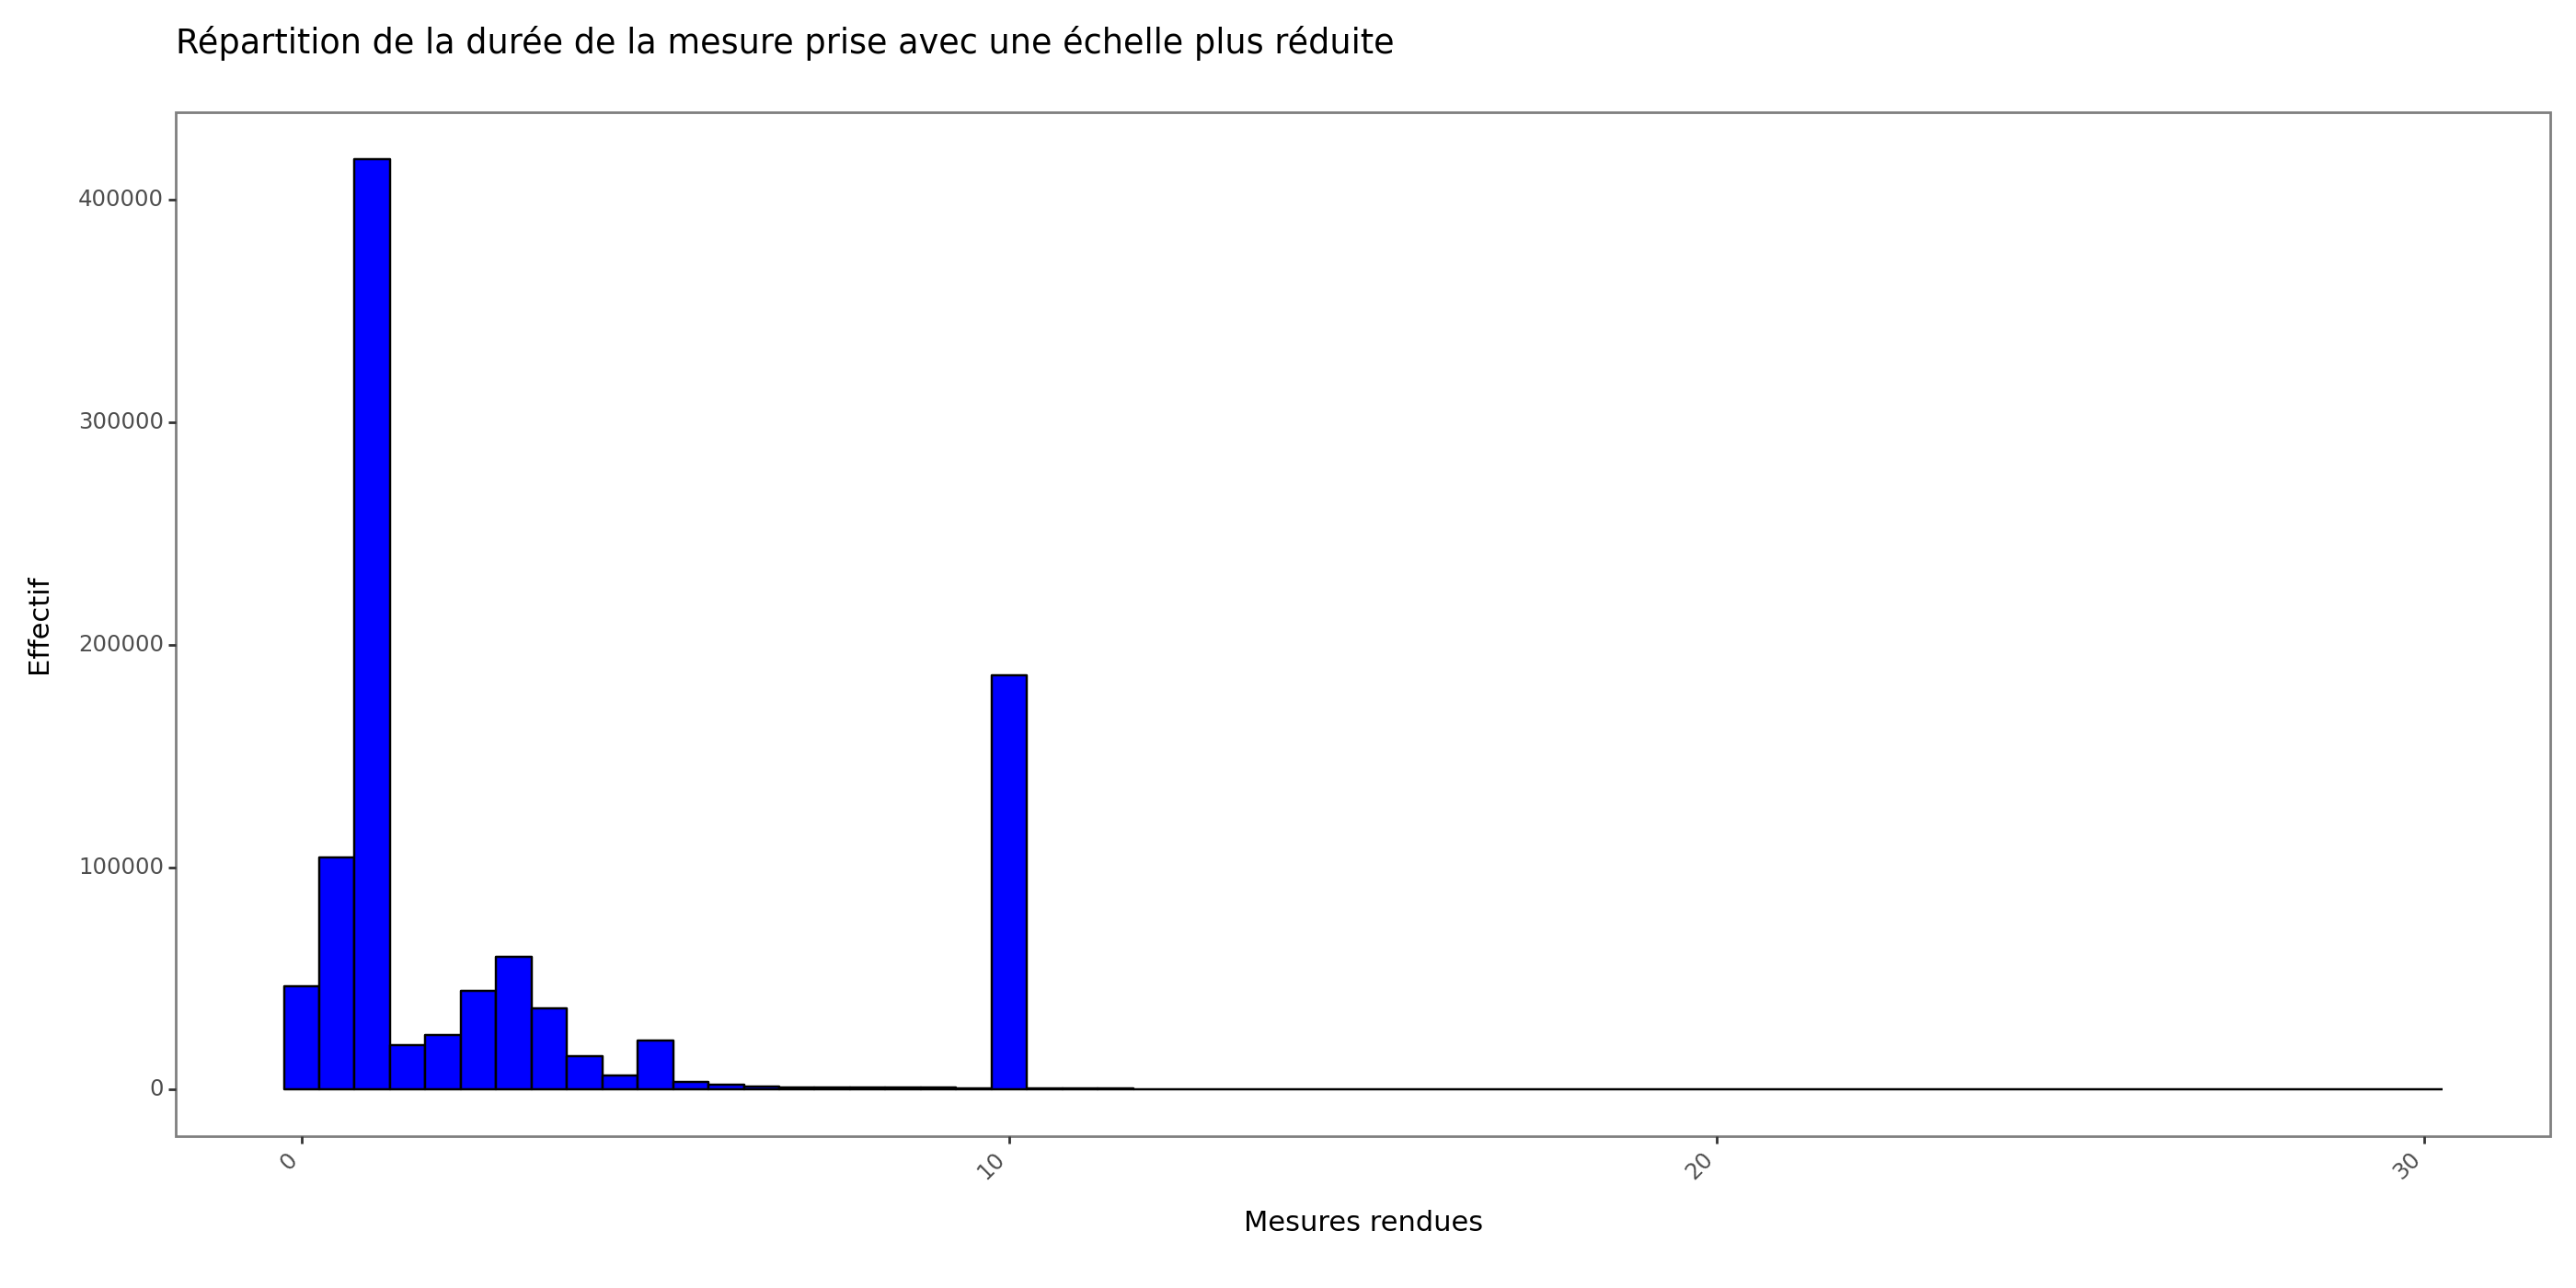

<Figure Size: (1400 x 700)>

In [173]:
# Voir sur un histogramme avec une échelle plus réduite
(
    plt.ggplot(open_radiation_mesure[open_radiation_mesure["dure_min_float"] <= 30], plt.aes(x="dure_min_float"))
    + plt.geom_histogram(binwidth=0.5, color="black", fill="blue")
    + plt.labs(title="Répartition de la durée de la mesure prise avec une échelle plus réduite",
               x = "Mesures rendues",
               y = "Effectif") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(14, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

In [174]:
# Faire les deux histogrammes pour observer la différence entre atypique et non atypique
(
    plt.ggplot(open_radiation_mesure, plt.aes(x="dure_min_float", y=plt.after_stat("ncount")))
    + plt.geom_histogram(color="black", fill="blue", binwidth=0.5)
    + plt.facet_wrap("atypical", ncol=1, nrow=2)
    + plt.labs(title="Répartition des durées de mesures selon si la valeur est ressortie est atypique ou non",
               x = "Mesures rendues") # Ajout des titres
    + plt.theme_bw()
    + plt.theme(figure_size=(10, 7), # Taille de la figure
                axis_text_x = plt.element_text(angle = 45, hjust = 1),
                panel_grid= plt.element_blank()) # Enlever les carreaux gris
)

KeyboardInterrupt: 

In [175]:
open_radiation_mesure.dtypes

apparatusSensorType              category
value                             float64
hitsNumber                        float64
startTime                  datetime64[ns]
endTime                    datetime64[ns]
latitude                          float64
longitude                         float64
altitude                          float64
reportUuid                         object
measurementHeight                 float64
measurementEnvironment           category
qualification                    category
reliability                         int64
atypical                         category
dure                      timedelta64[ns]
dure_min_float                    float64
jour_ann_fin                     category
mois_fin                         category
ann_fin                          category
trim_fin                         category
sem_fin                          category
jour_sem_fin                     category
intervalle_mesure                category
dtype: object